In [1]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots

pi = torch.pi

In [2]:
batchSize = 1024
path_data = '../../dataset/v7/all_jets_fullRun2_v1.parquet'
device = torch.device('cpu')

path_unscaled = 'results_preTraining/runs_noprov_newInput_GlVersion2/preTraining-MEMFlow_noprov_v19_v19/unscaledRegressedPartonsTensor_4.pt'

path_to_conf = 'results_preTraining/runs_noprov_newInput_GlVersion2/preTraining-MEMFlow_noprov_v19_v19/config_preTraining-MEMFlow_noprov_v19_v19.yaml'

with open(path_to_conf) as f:
        conf = OmegaConf.load(path_to_conf)

log_mean = torch.tensor(conf.scaling_params.log_mean, device=device)
log_std = torch.tensor(conf.scaling_params.log_std, device=device)

In [3]:
data = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=['data_boost'],
                        parton_list=['data_higgs_t_tbar_ISR_cartesian',
                                    'phasespace_intermediateParticles',
                                    'phasespace_rambo_detjacobian'])

dataCorrect = data.parton_data.data_higgs_t_tbar_ISR_cartesian

higgsCorrect = vector.array(
    {
        "E": dataCorrect[:,0,0].detach().numpy(),
        "px": dataCorrect[:,0,1].detach().numpy(),
        "py": dataCorrect[:,0,2].detach().numpy(),
        "pz": dataCorrect[:,0,3].detach().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": dataCorrect[:,1,0].detach().numpy(),
        "px": dataCorrect[:,1,1].detach().numpy(),
        "py": dataCorrect[:,1,2].detach().numpy(),
        "pz": dataCorrect[:,1,3].detach().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": dataCorrect[:,2,0].detach().numpy(),
        "px": dataCorrect[:,2,1].detach().numpy(),
        "py": dataCorrect[:,2,2].detach().numpy(),
        "pz": dataCorrect[:,2,3].detach().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": dataCorrect[:,3,0].detach().numpy(),
        "px": dataCorrect[:,3,1].detach().numpy(),
        "py": dataCorrect[:,3,2].detach().numpy(),
        "pz": dataCorrect[:,3,3].detach().numpy(),
    }
)

higgsCorrect = ak.with_name(higgsCorrect, name="Momentum4D")
thadCorrect = ak.with_name(thadCorrect, name="Momentum4D")
tlepCorrect = ak.with_name(tlepCorrect, name="Momentum4D")
glISRCorrect = ak.with_name(glISRCorrect, name="Momentum4D")


RecoLevel
Reading reco_level Files

PartonLevel
Reading parton_level Files
Load phasespace_intermediateParticles
Load phasespace_rambo_detjacobian



In [4]:
unscaledTensor = torch.load(path_unscaled, map_location=device)
unscaledlog = unscaledTensor*log_std[1:] + log_mean[1:]
data_regressed = torch.sign(unscaledlog)*(torch.exp(torch.abs(unscaledlog)) - 1)

print(data_regressed.shape)

torch.Size([1414130, 3, 3])


In [5]:
M_HIGGS = 125.25
M_TOP = 172.76

higgs = data_regressed[:,0]
thad = data_regressed[:,1]
tlep = data_regressed[:,2]

E_higgs = torch.sqrt(M_HIGGS**2 + higgs[:,0]**2 + \
                    higgs[:,1]**2 + higgs[:,2]**2).unsqueeze(dim=1)
            
E_thad = torch.sqrt(M_TOP**2 + thad[:,0]**2 + \
                    thad[:,1]**2 + thad[:,2]**2).unsqueeze(dim=1)

E_tlep = torch.sqrt(M_TOP**2 + tlep[:,0]**2 + \
                    tlep[:,1]**2 + tlep[:,2]**2).unsqueeze(dim=1)

higgs = torch.cat((E_higgs, higgs), dim=1).unsqueeze(dim=1)
thad = torch.cat((E_thad, thad), dim=1).unsqueeze(dim=1)
tlep = torch.cat((E_tlep, tlep), dim=1).unsqueeze(dim=1)

print(higgs.shape)

gluon_px = -(higgs[:,0,1] + thad[:,0,1] + tlep[:,0,1]).unsqueeze(dim=1)
gluon_py = -(higgs[:,0,2] + thad[:,0,2] + tlep[:,0,2]).unsqueeze(dim=1)
gluon_pz = -(higgs[:,0,3] + thad[:,0,3] + tlep[:,0,3]).unsqueeze(dim=1)
E_gluon = torch.sqrt(gluon_px**2 + gluon_py**2 + gluon_pz**2)

gluon = torch.cat((E_gluon, gluon_px, gluon_py, gluon_pz), dim=1).unsqueeze(dim=1)
print(gluon.shape)

new_data_regressed = torch.cat((higgs, thad, tlep, gluon), dim=1)
print(new_data_regressed.shape)

torch.Size([1414130, 1, 4])
torch.Size([1414130, 1, 4])
torch.Size([1414130, 4, 4])


In [6]:
higgs = vector.array(
    {
        "E": new_data_regressed[:,0,0].detach().numpy(),
        "px": new_data_regressed[:,0,1].detach().numpy(),
        "py": new_data_regressed[:,0,2].detach().numpy(),
        "pz": new_data_regressed[:,0,3].detach().numpy(),
    }
)

thad = vector.array(
    {
        "E": new_data_regressed[:,1,0].detach().numpy(),
        "px": new_data_regressed[:,1,1].detach().numpy(),
        "py": new_data_regressed[:,1,2].detach().numpy(),
        "pz": new_data_regressed[:,1,3].detach().numpy(),
    }
)

tlep = vector.array(
    {
        "E": new_data_regressed[:,2,0].detach().numpy(),
        "px": new_data_regressed[:,2,1].detach().numpy(),
        "py": new_data_regressed[:,2,2].detach().numpy(),
        "pz": new_data_regressed[:,2,3].detach().numpy(),
    }
)

glISR = vector.array(
    {
        "E": new_data_regressed[:,3,0].detach().numpy(),
        "px": new_data_regressed[:,3,1].detach().numpy(),
        "py": new_data_regressed[:,3,2].detach().numpy(),
        "pz": new_data_regressed[:,3,3].detach().numpy(),
    }
)

higgs = ak.with_name(higgs, name="Momentum4D")
thad = ak.with_name(thad, name="Momentum4D")
tlep = ak.with_name(tlep, name="Momentum4D")
glISR = ak.with_name(glISR, name="Momentum4D")

boost_regressed = higgs + thad + tlep + glISR
boost_regressed = to_flat_tensor(boost_regressed, ["t", "x", "y", "z"], axis=1, allow_missing=False)

# Split in matched/unmatched

In [7]:
df = ak.from_parquet(path_data)
jets = df.jets
jets = ak.with_name(jets, name="Momentum4D")

x = FindMasks()
higgs_mask = x.higgs_mask(jets)
thad_mask = x.thad_mask(jets)
tlep_mask = x.tlep_mask(jets)
ISR_mask = x.ISR_mask(jets)

# Plots (higgsCorrect/thadCorrect/... higgs/thad ...)


In [16]:
plots = SavePlots('plots/GluonVersion')

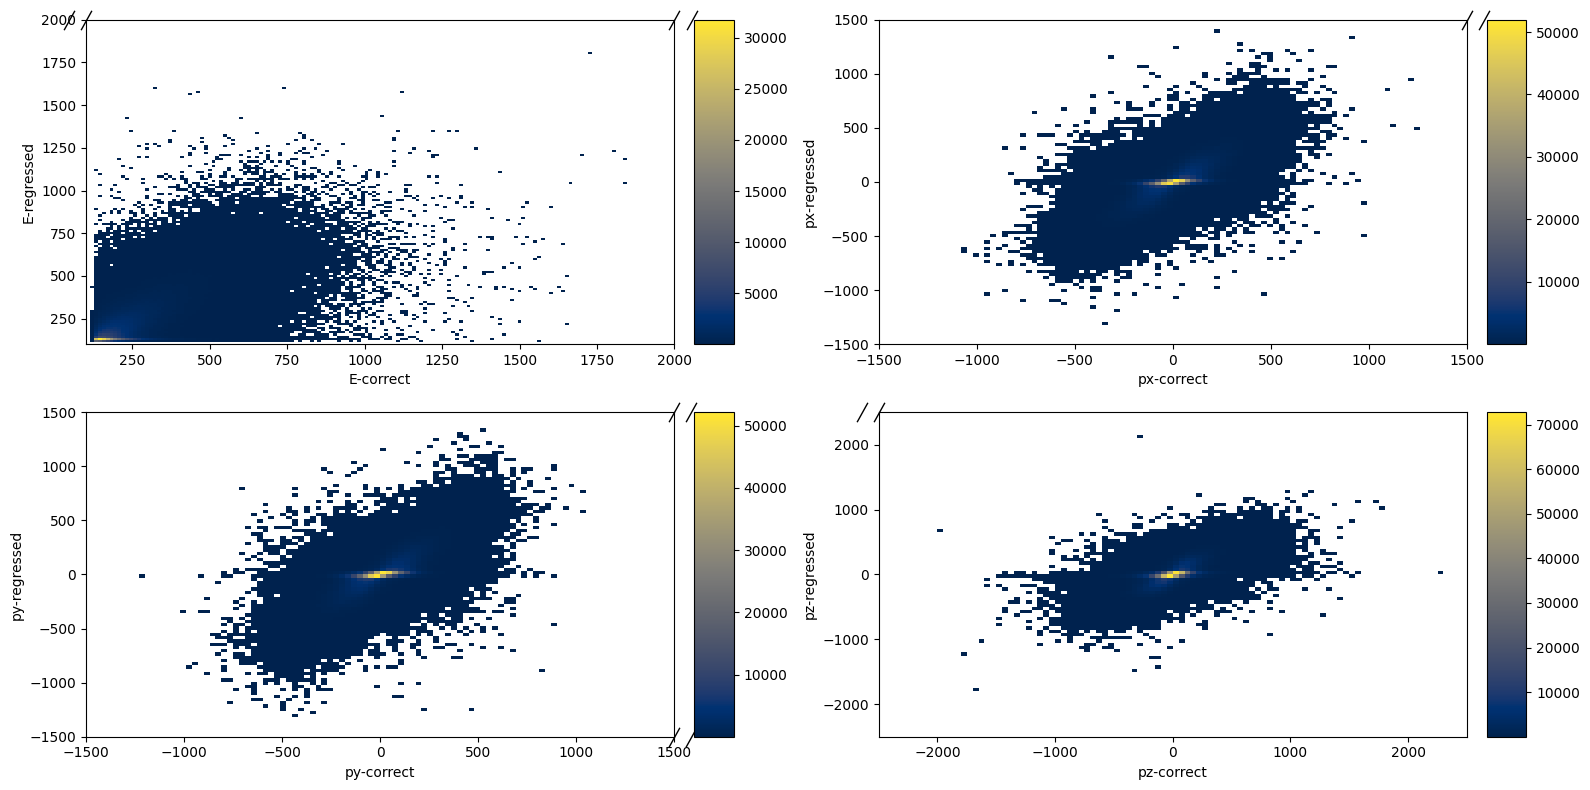

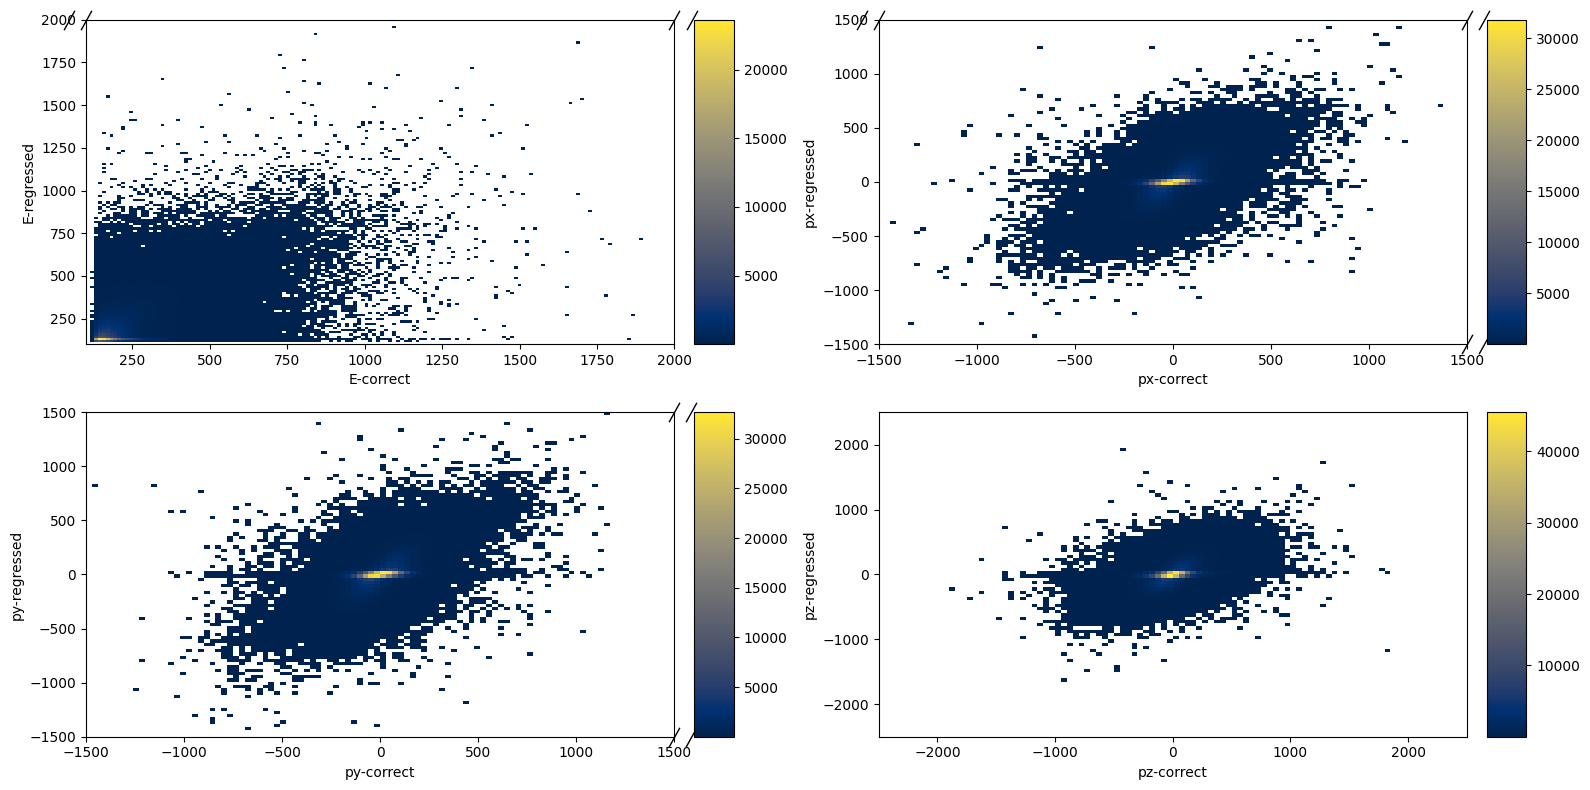

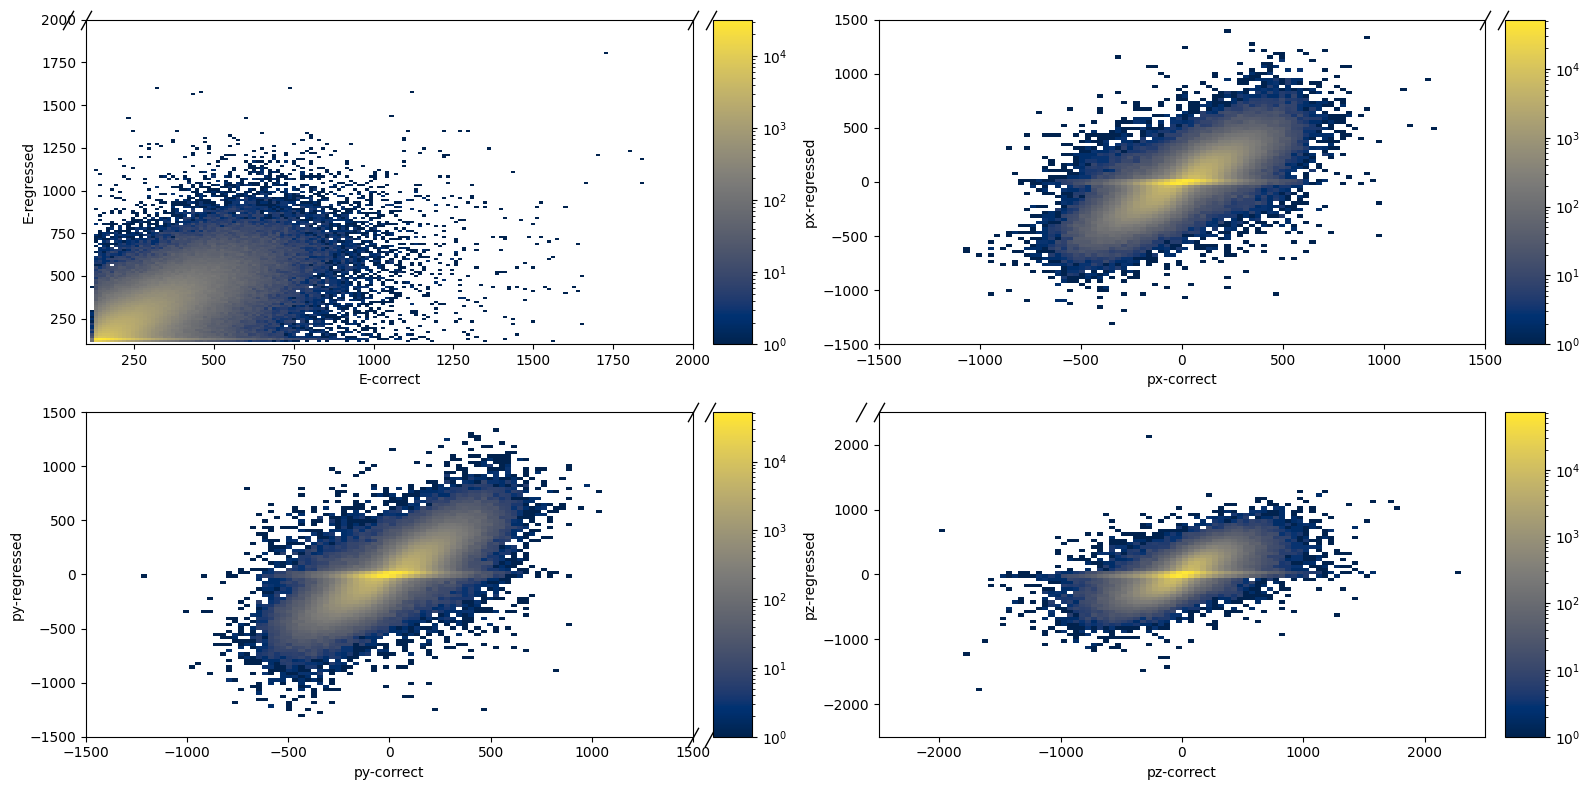

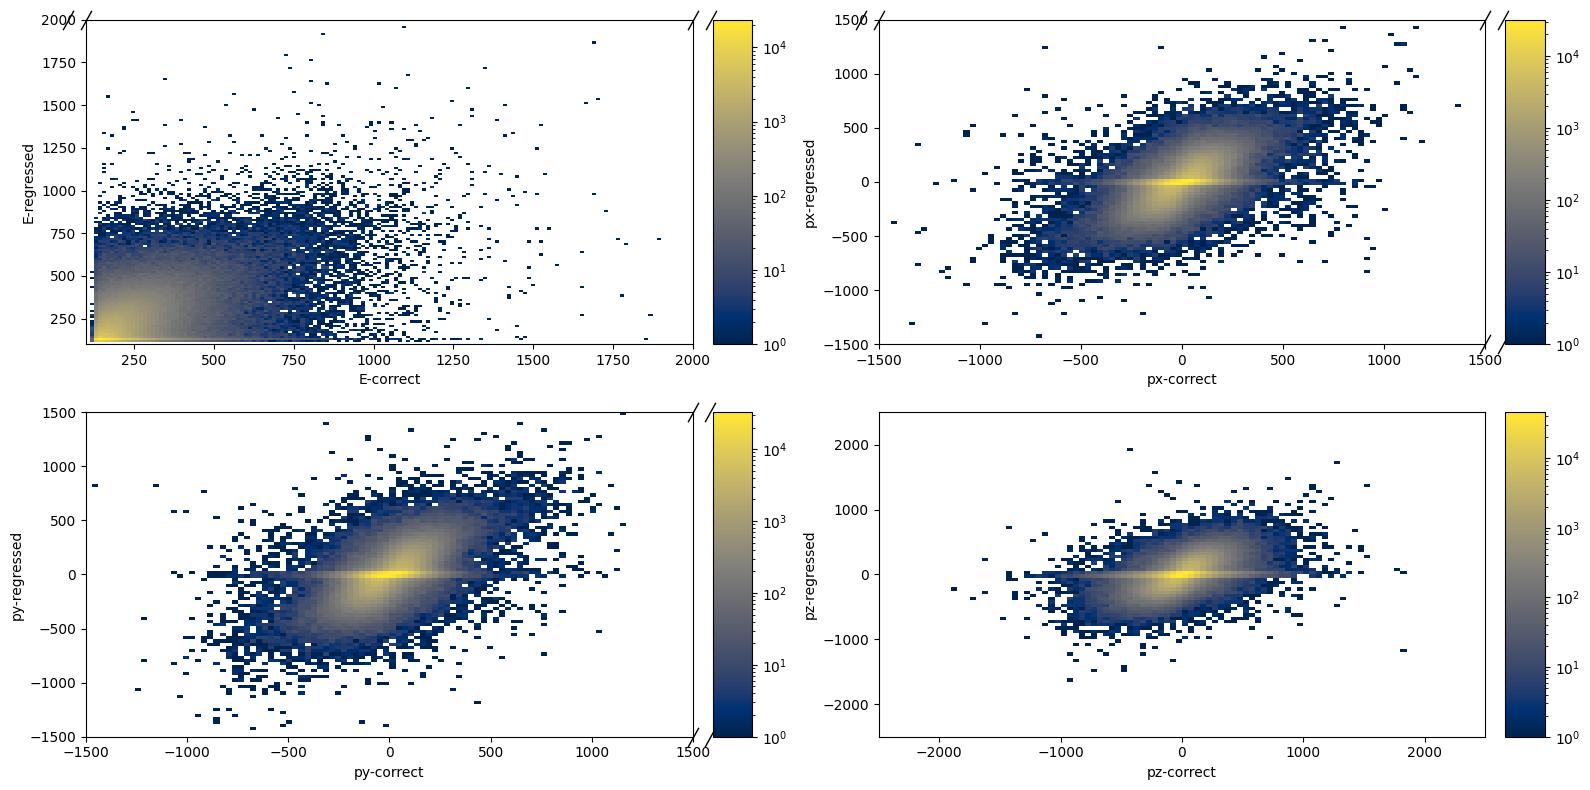

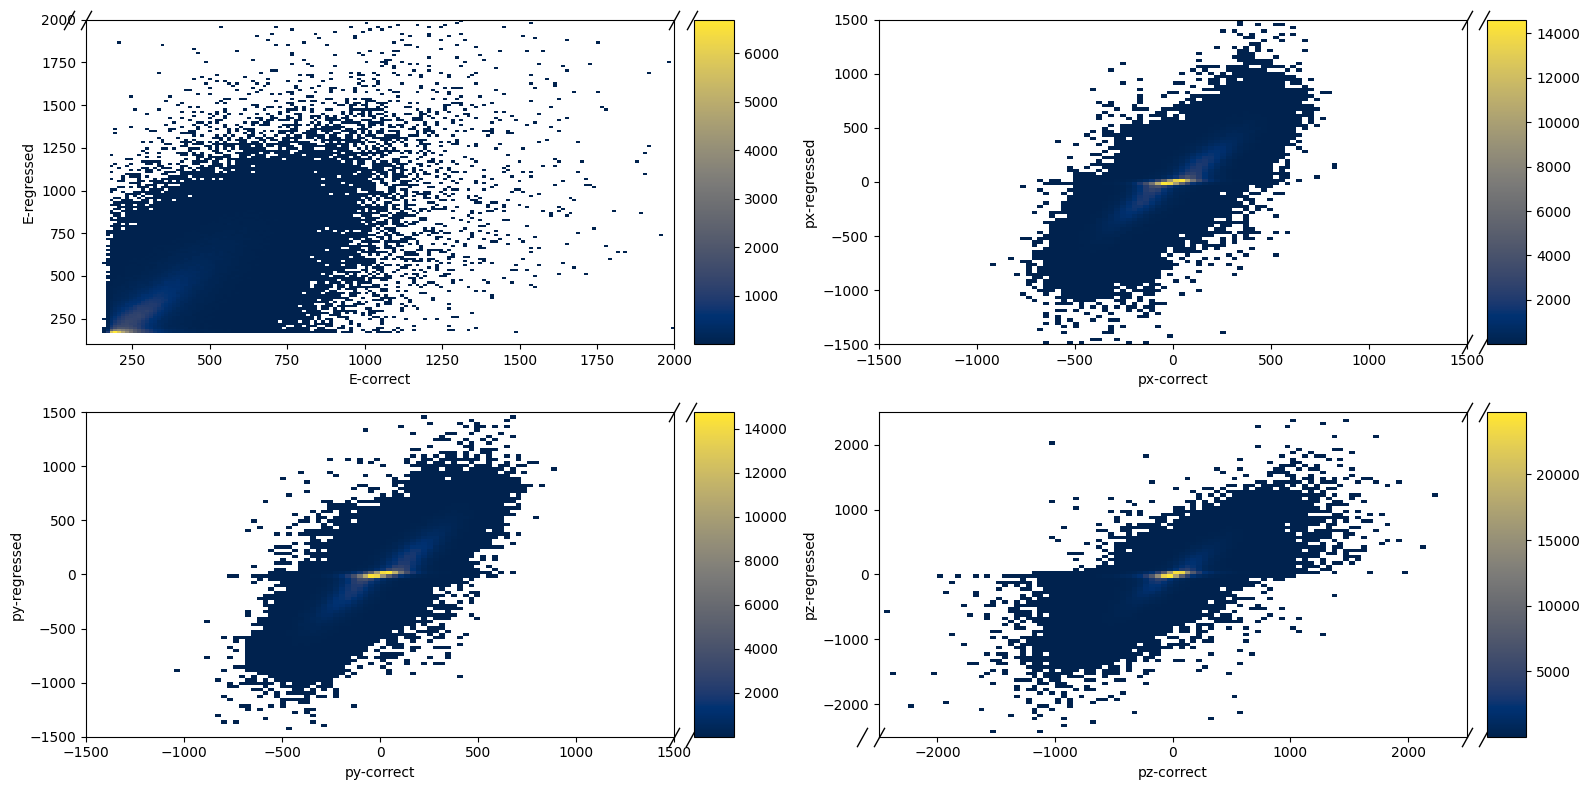

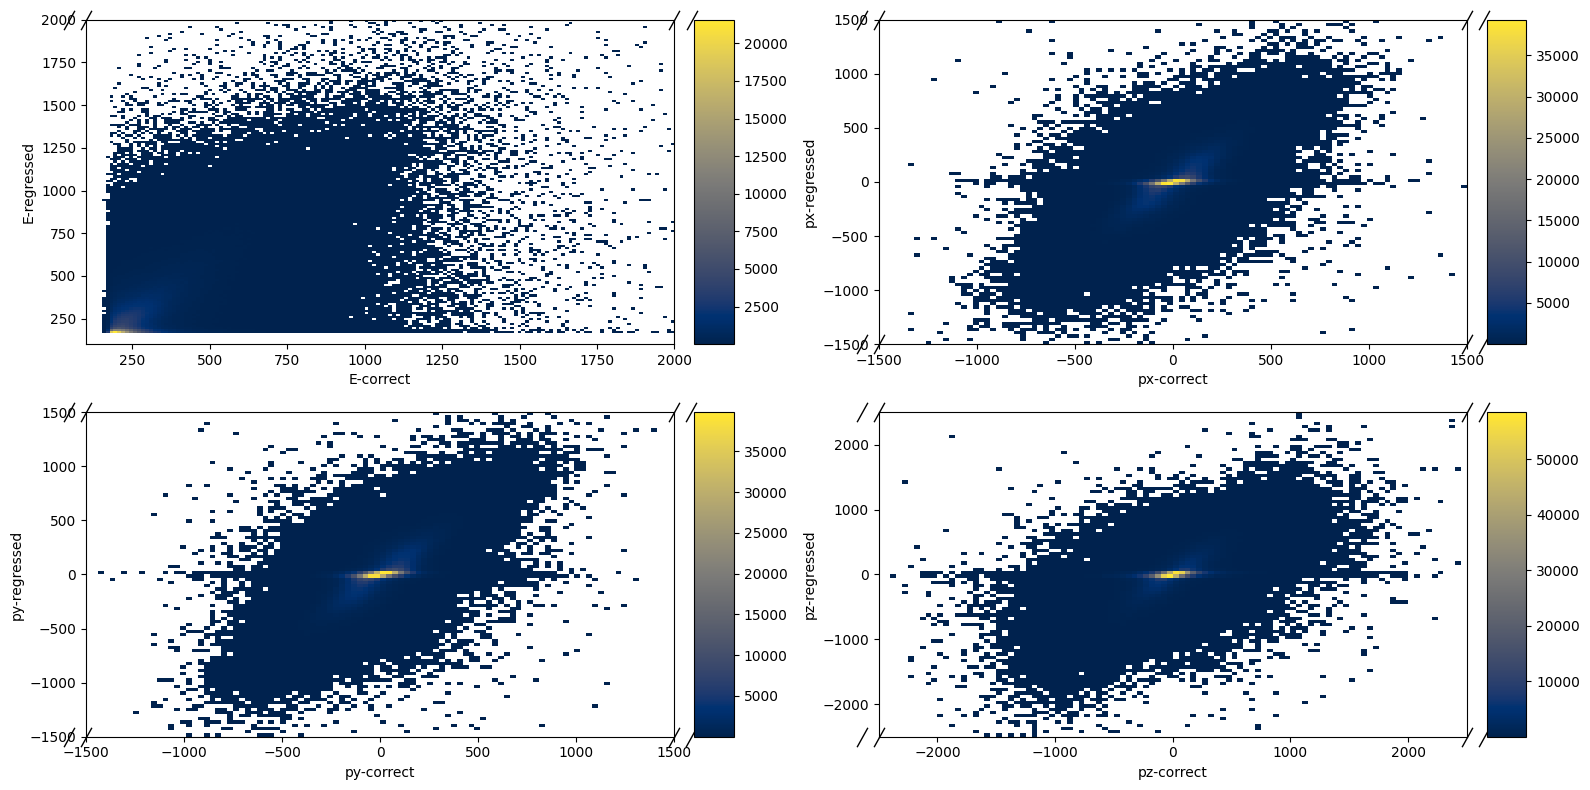

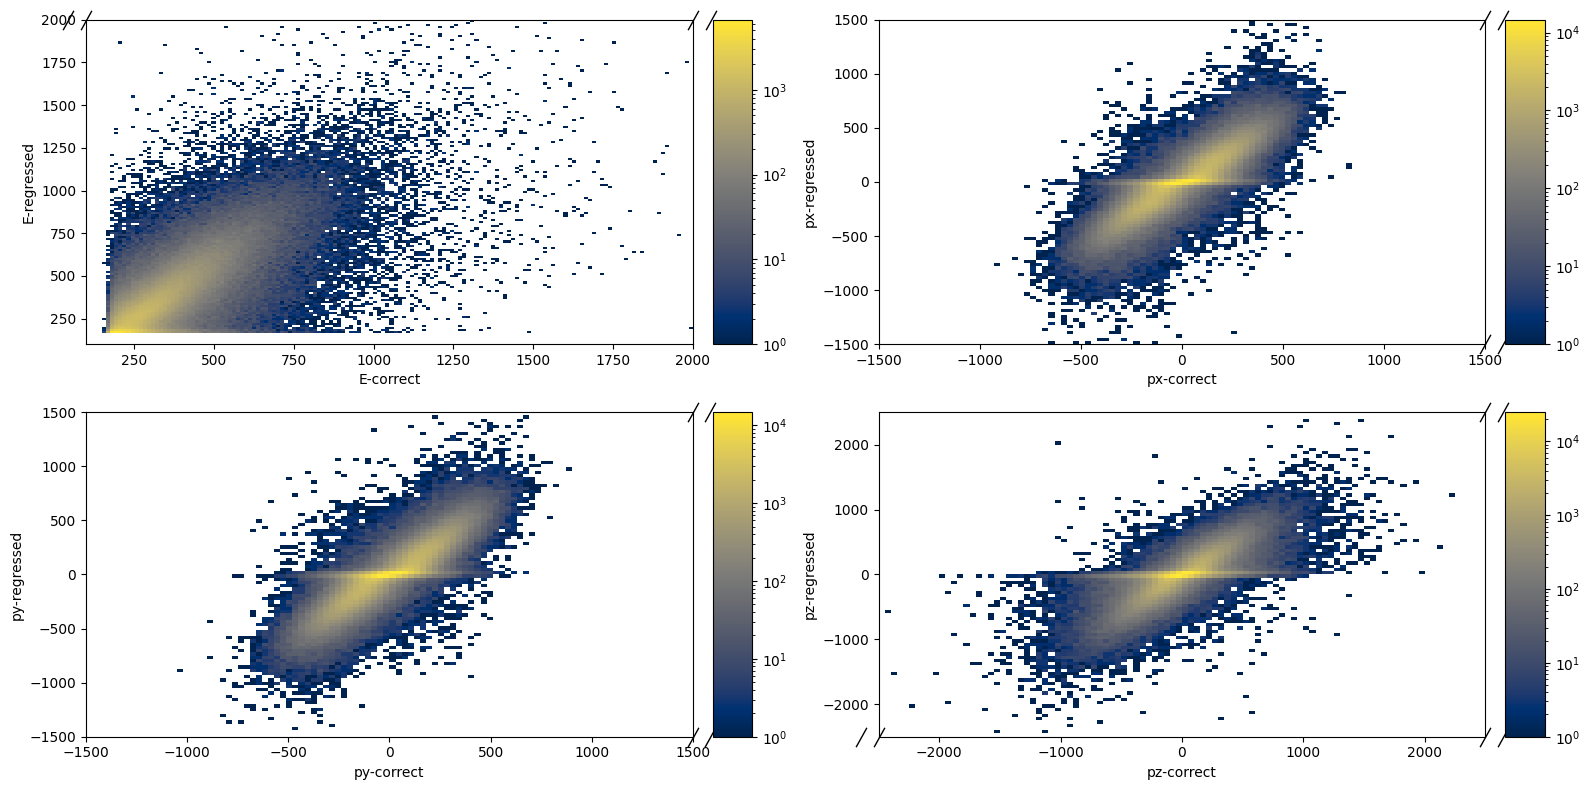

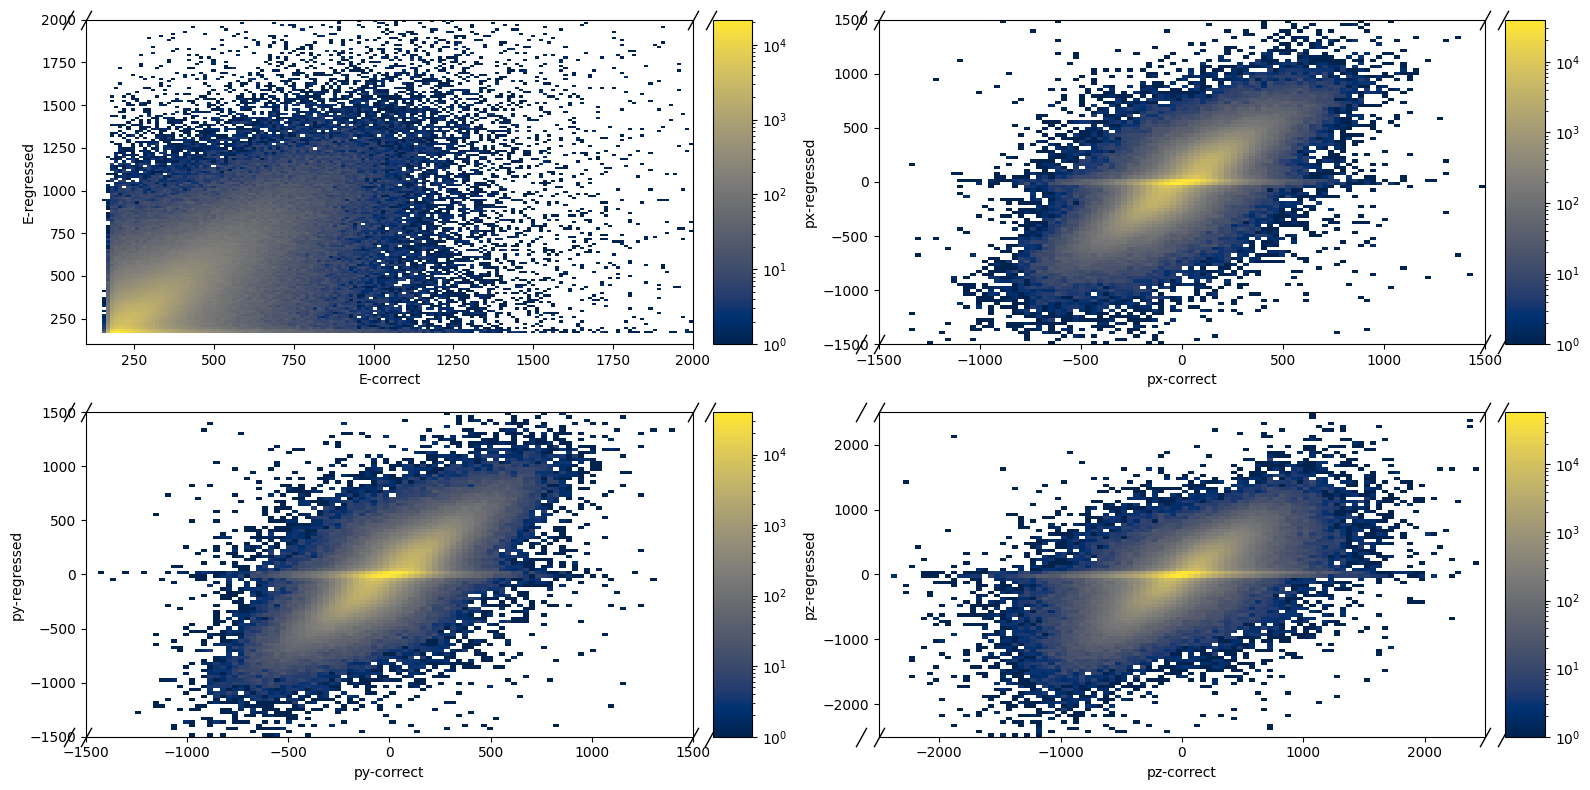

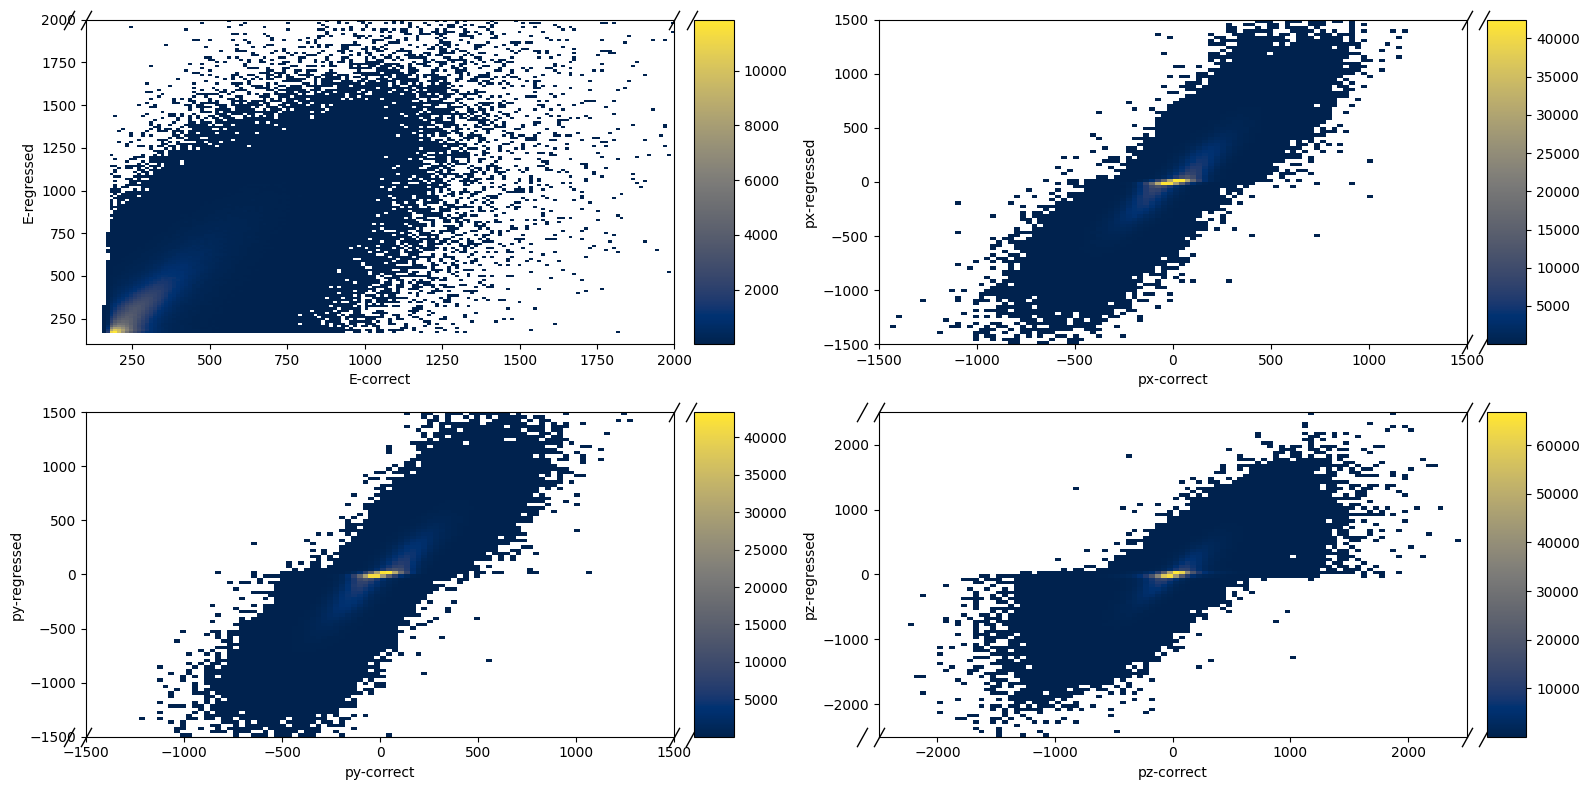

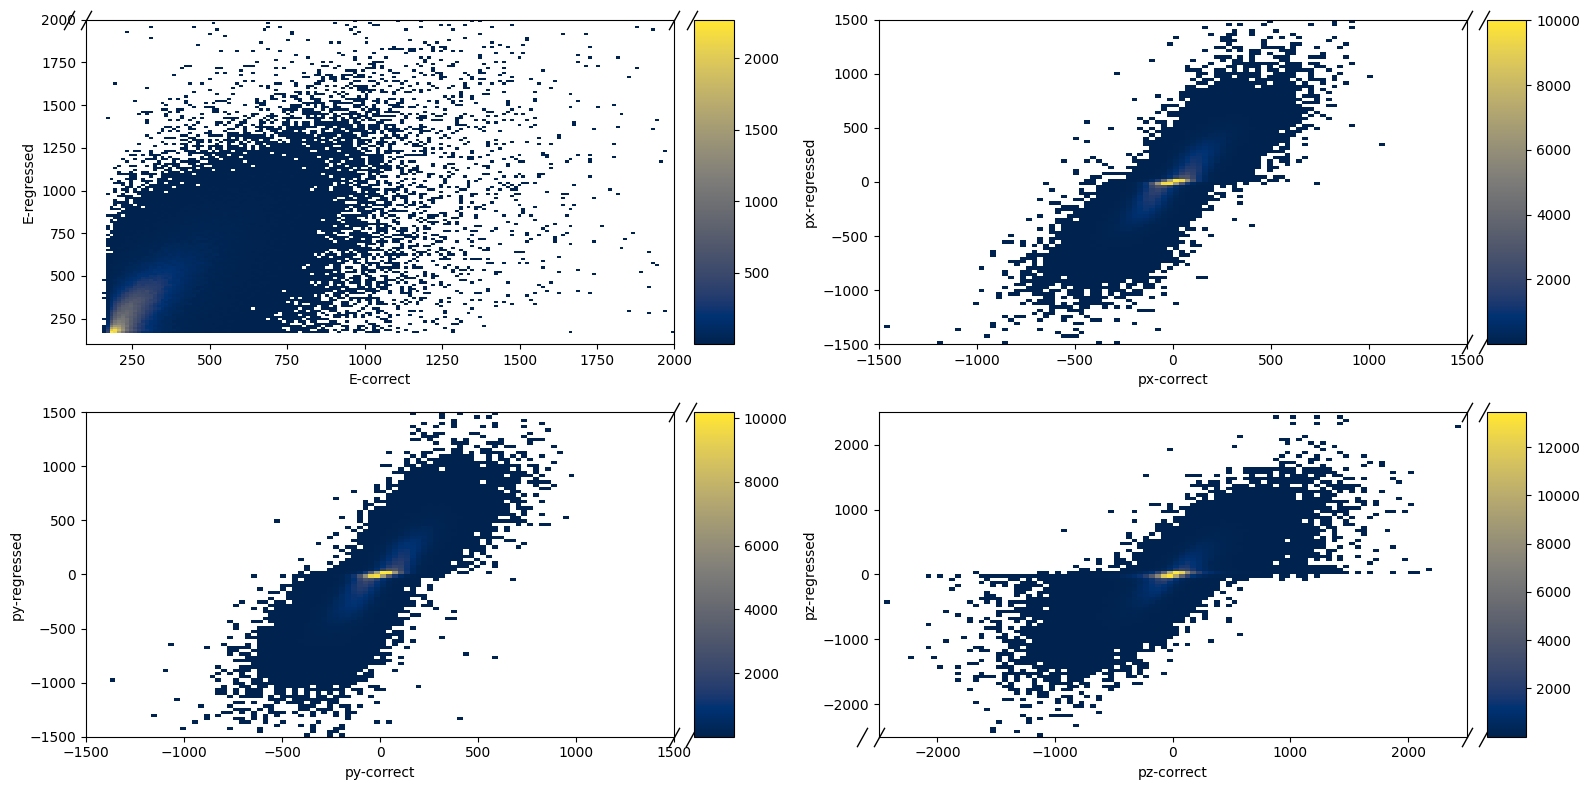

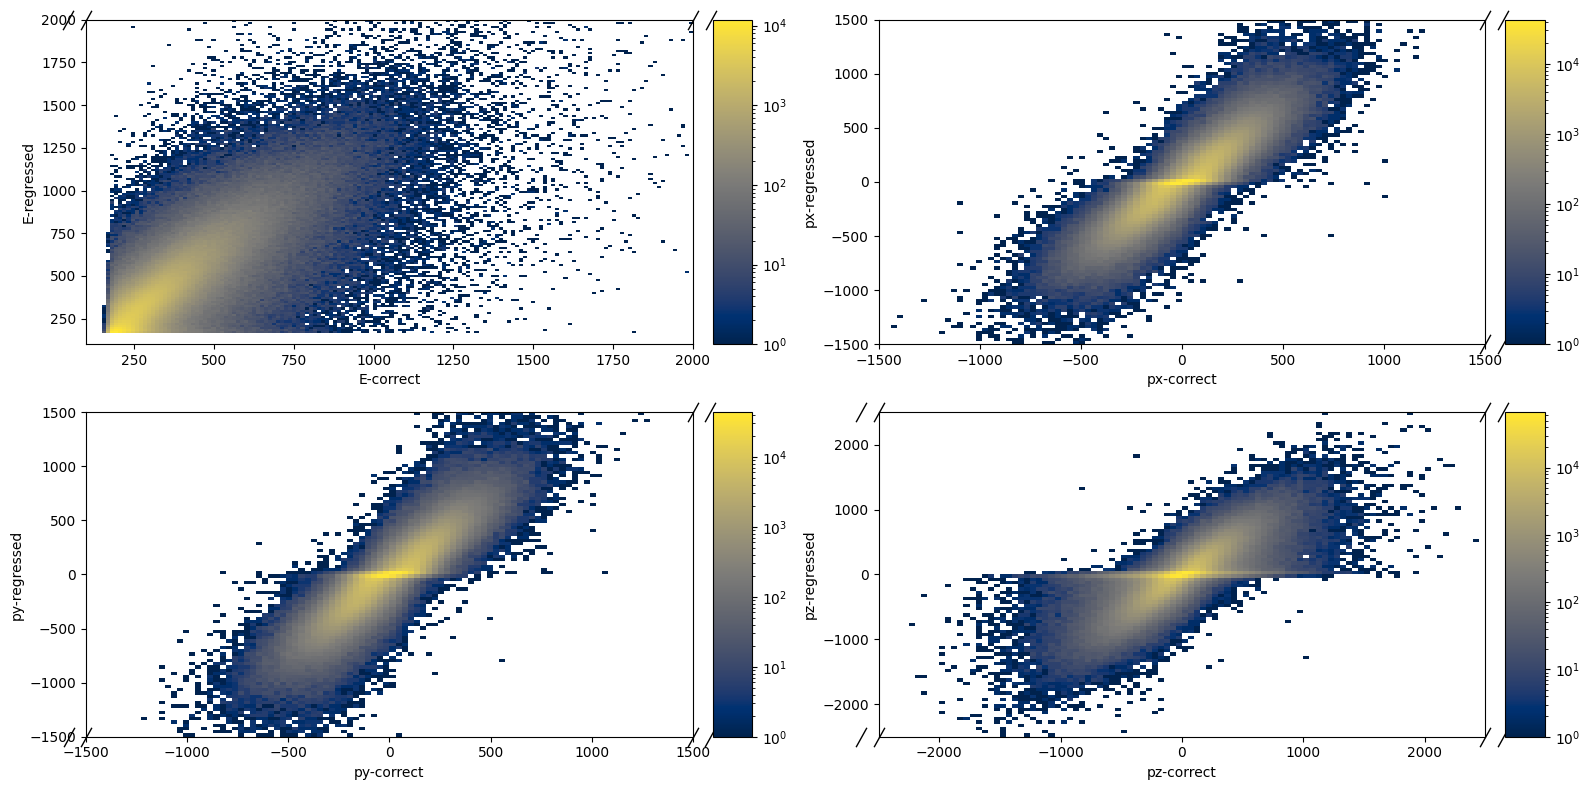

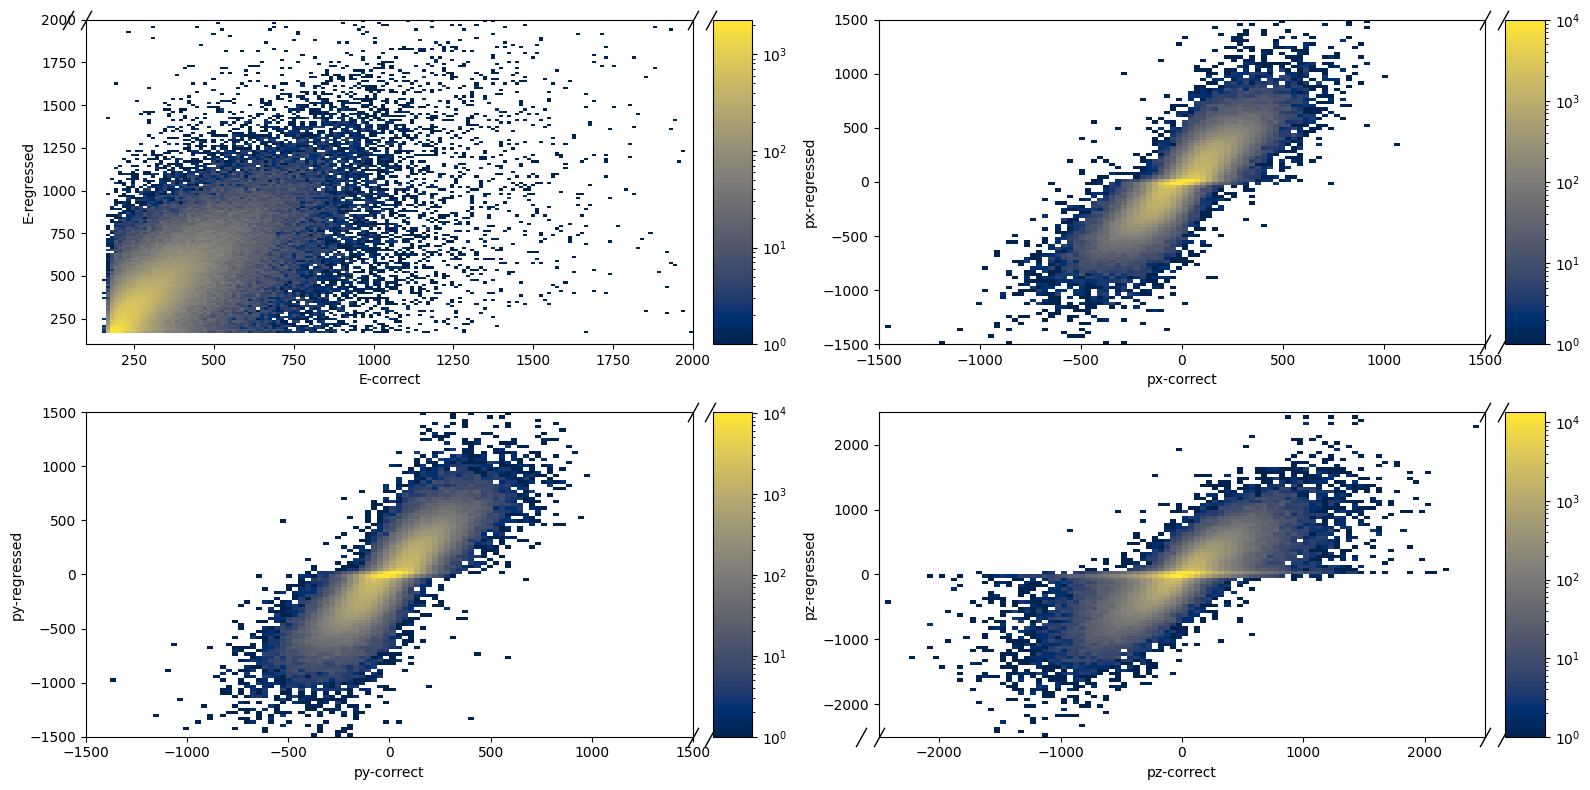

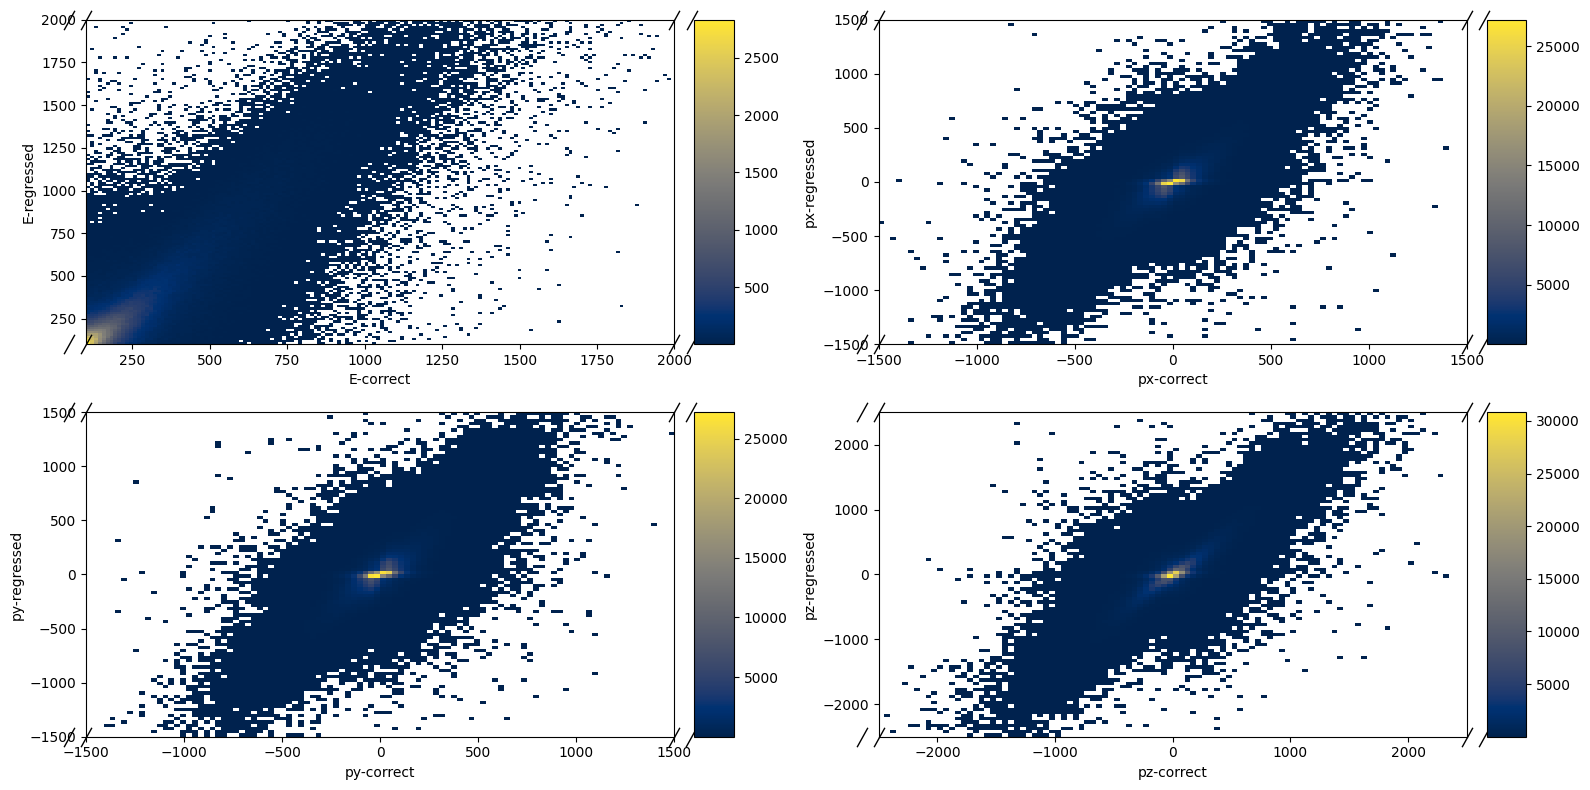

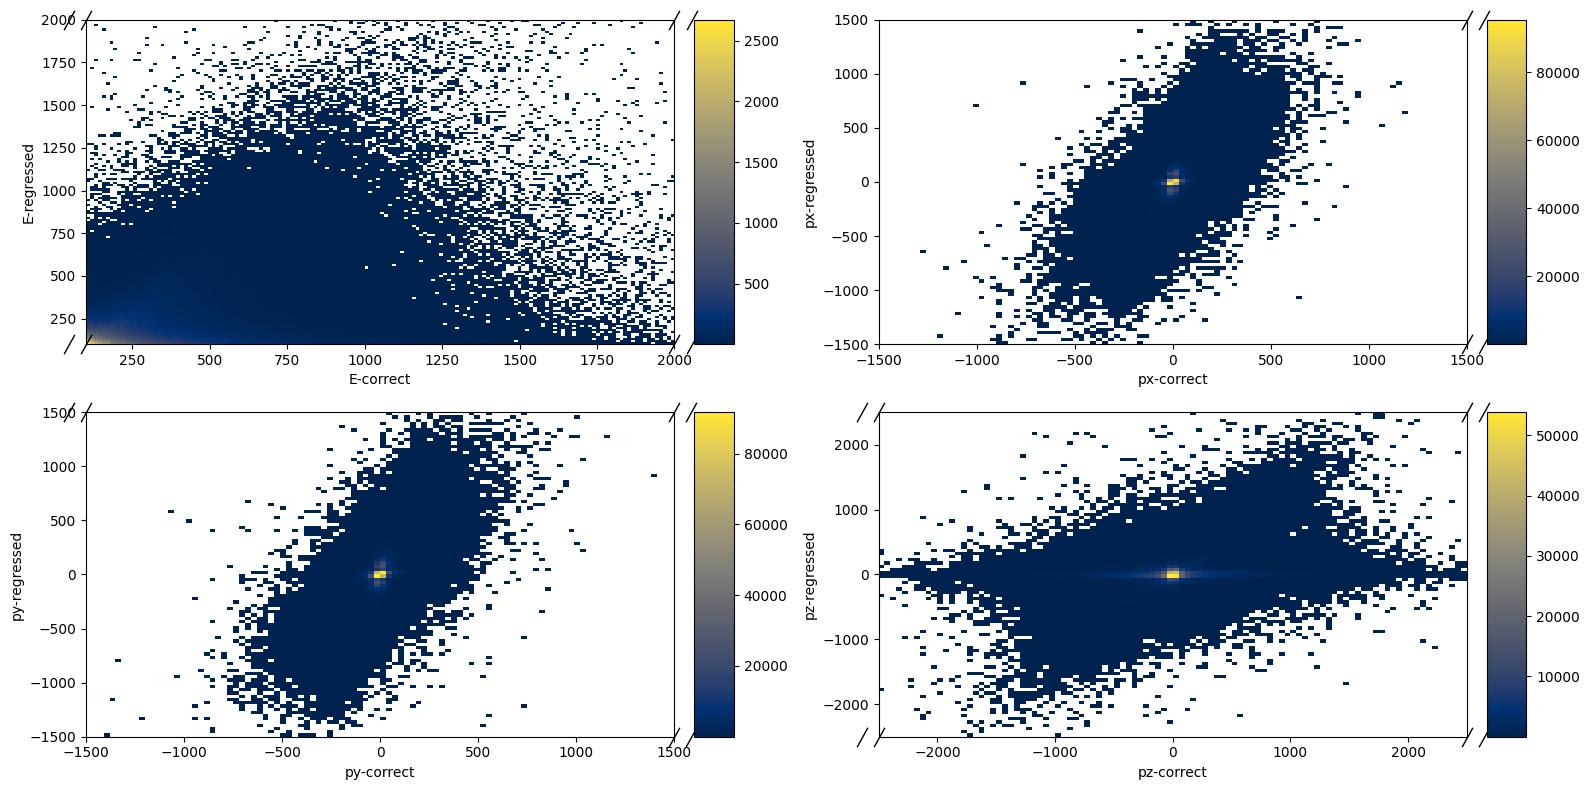

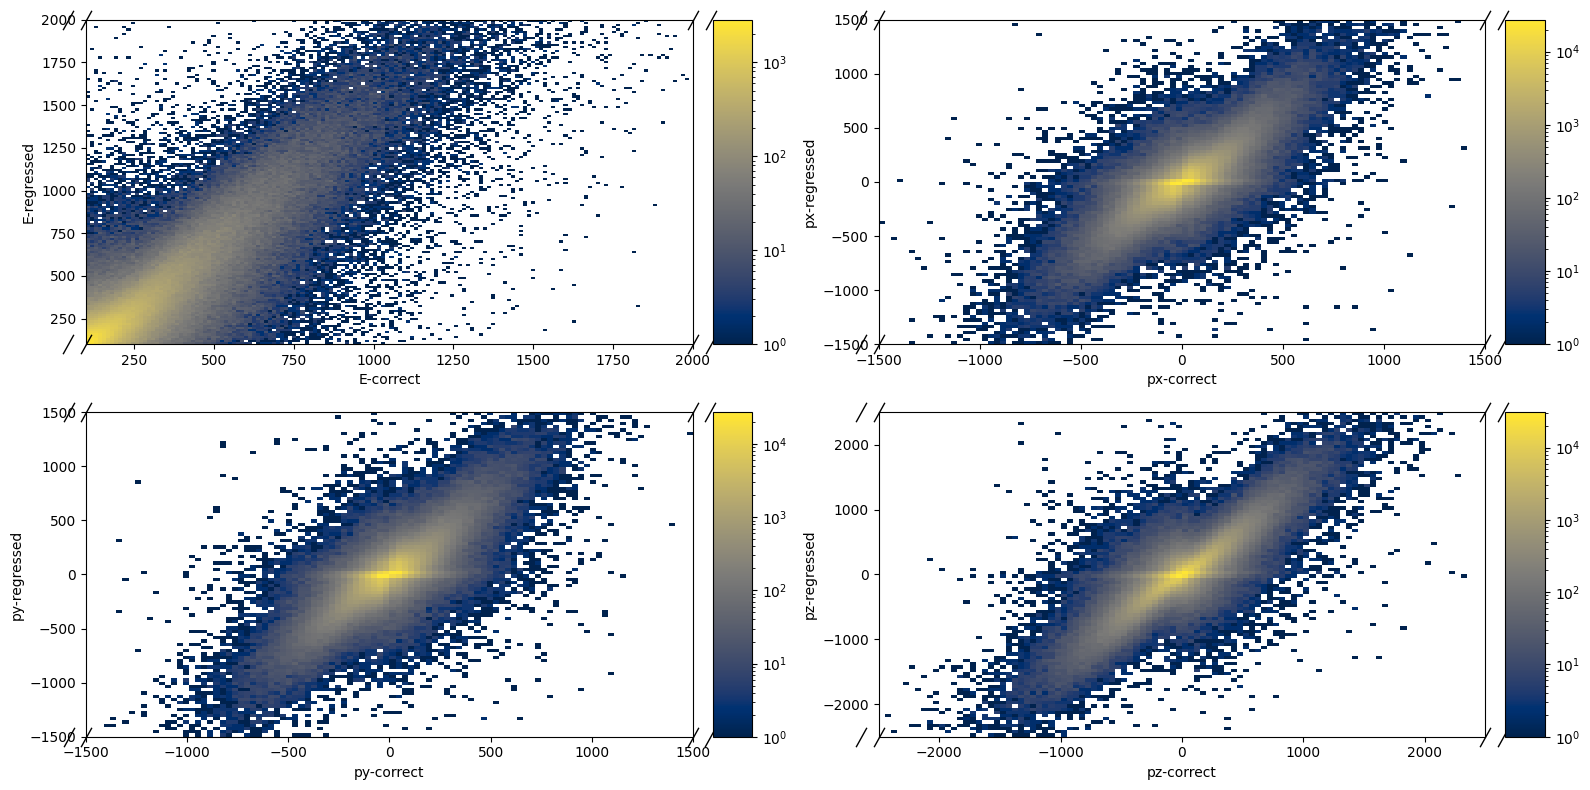

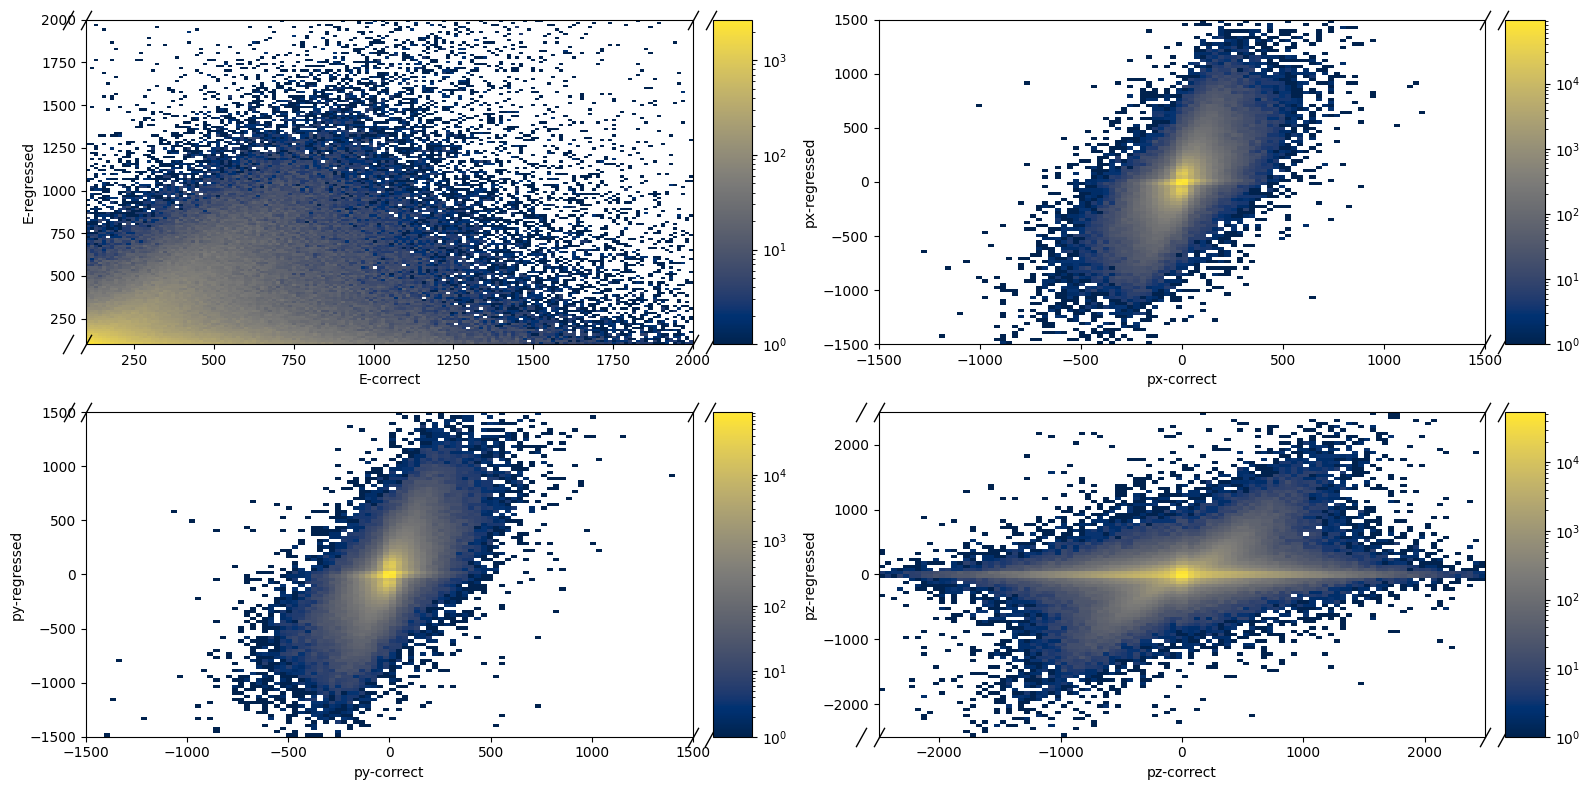

In [17]:
plots.plot_particle(particleCorrect=higgsCorrect, particle=higgs, particle_mask=higgs_mask,
                    nameFig='1.png', neg_Mask=False, log=False)
plots.plot_particle(particleCorrect=higgsCorrect, particle=higgs, particle_mask=higgs_mask,
                    nameFig='2.png', neg_Mask=True, log=False)
plots.plot_particle(particleCorrect=higgsCorrect, particle=higgs, particle_mask=higgs_mask,
                    nameFig='3.png', neg_Mask=False, log=True)
plots.plot_particle(particleCorrect=higgsCorrect, particle=higgs, particle_mask=higgs_mask,
                    nameFig='4.png', neg_Mask=True, log=True)

plots.plot_particle(particleCorrect=thadCorrect, particle=thad, particle_mask=thad_mask,
                    nameFig='5.png', neg_Mask=False, log=False)
plots.plot_particle(particleCorrect=thadCorrect, particle=thad, particle_mask=thad_mask,
                    nameFig='6.png', neg_Mask=True, log=False)
plots.plot_particle(particleCorrect=thadCorrect, particle=thad, particle_mask=thad_mask,
                    nameFig='7.png', neg_Mask=False, log=True)
plots.plot_particle(particleCorrect=thadCorrect, particle=thad, particle_mask=thad_mask,
                    nameFig='8.png', neg_Mask=True, log=True)

plots.plot_particle(particleCorrect=tlepCorrect, particle=tlep, particle_mask=tlep_mask,
                    nameFig='9.png', neg_Mask=False, log=False)
plots.plot_particle(particleCorrect=tlepCorrect, particle=tlep, particle_mask=tlep_mask,
                    nameFig='10.png', neg_Mask=True, log=False)
plots.plot_particle(particleCorrect=tlepCorrect, particle=tlep, particle_mask=tlep_mask,
                    nameFig='11.png', neg_Mask=False, log=True)
plots.plot_particle(particleCorrect=tlepCorrect, particle=tlep, particle_mask=tlep_mask,
                    nameFig='12.png', neg_Mask=True, log=True)

plots.plot_particle(particleCorrect=glISRCorrect, particle=glISR, particle_mask=ISR_mask,
                    nameFig='13.png', neg_Mask=False, log=False)
plots.plot_particle(particleCorrect=glISRCorrect, particle=glISR, particle_mask=ISR_mask,
                    nameFig='14.png', neg_Mask=True, log=False)
plots.plot_particle(particleCorrect=glISRCorrect, particle=glISR, particle_mask=ISR_mask,
                    nameFig='15.png', neg_Mask=False, log=True)
plots.plot_particle(particleCorrect=glISRCorrect, particle=glISR, particle_mask=ISR_mask,
                    nameFig='16.png', neg_Mask=True, log=True)

/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is insta

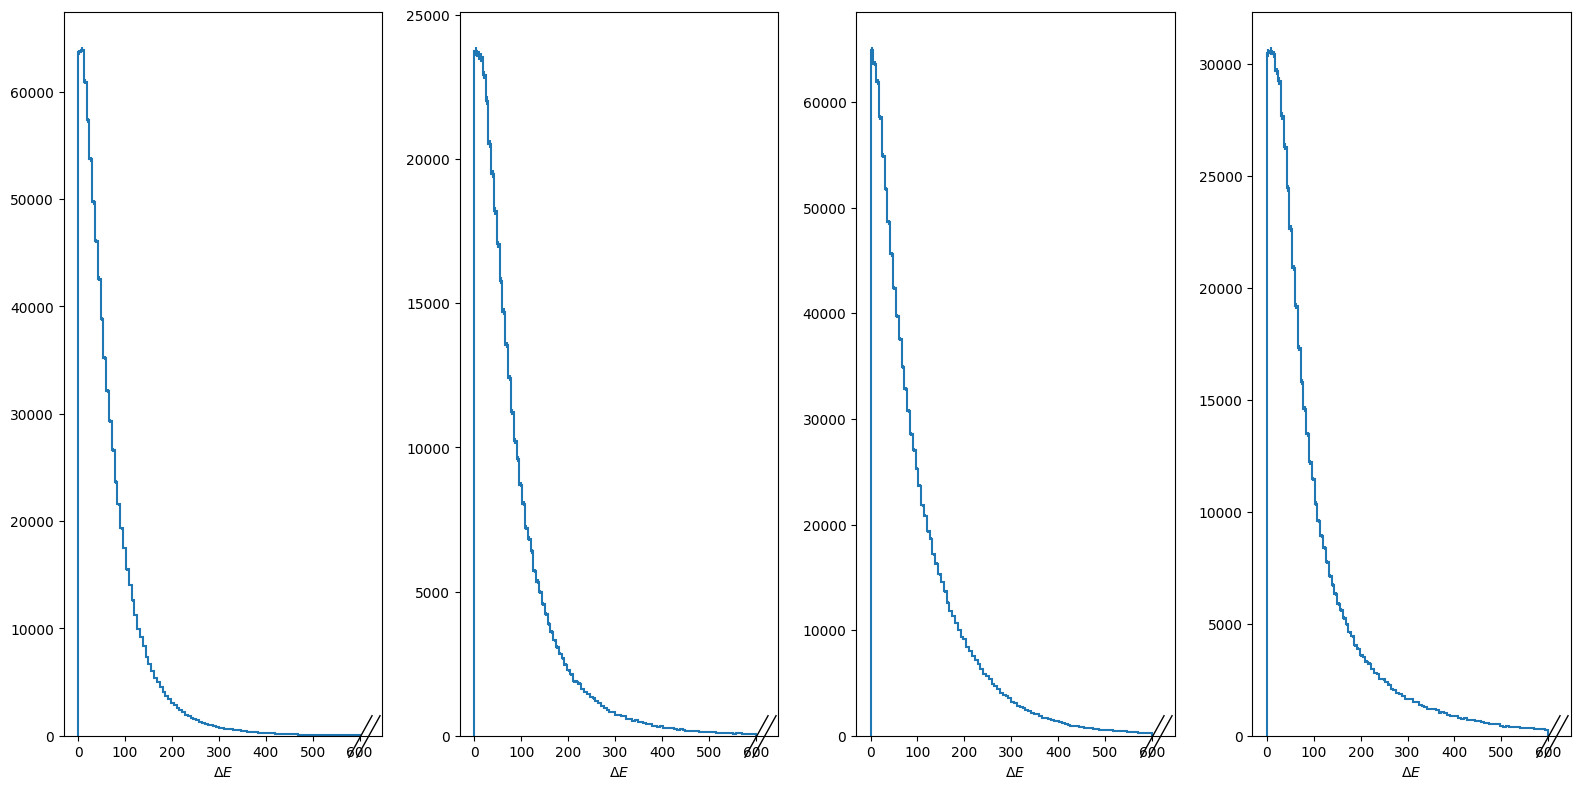

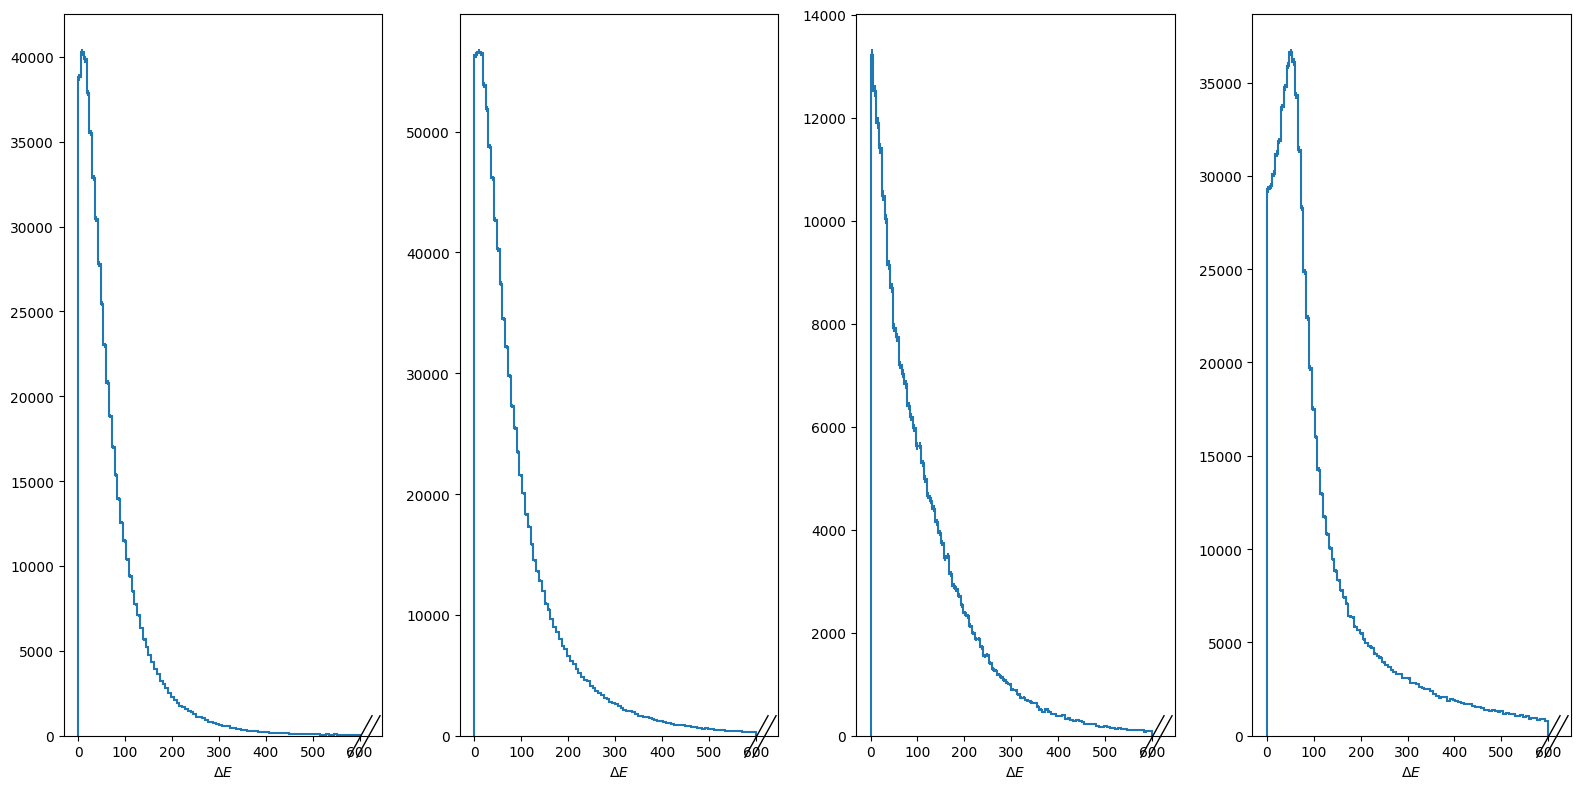

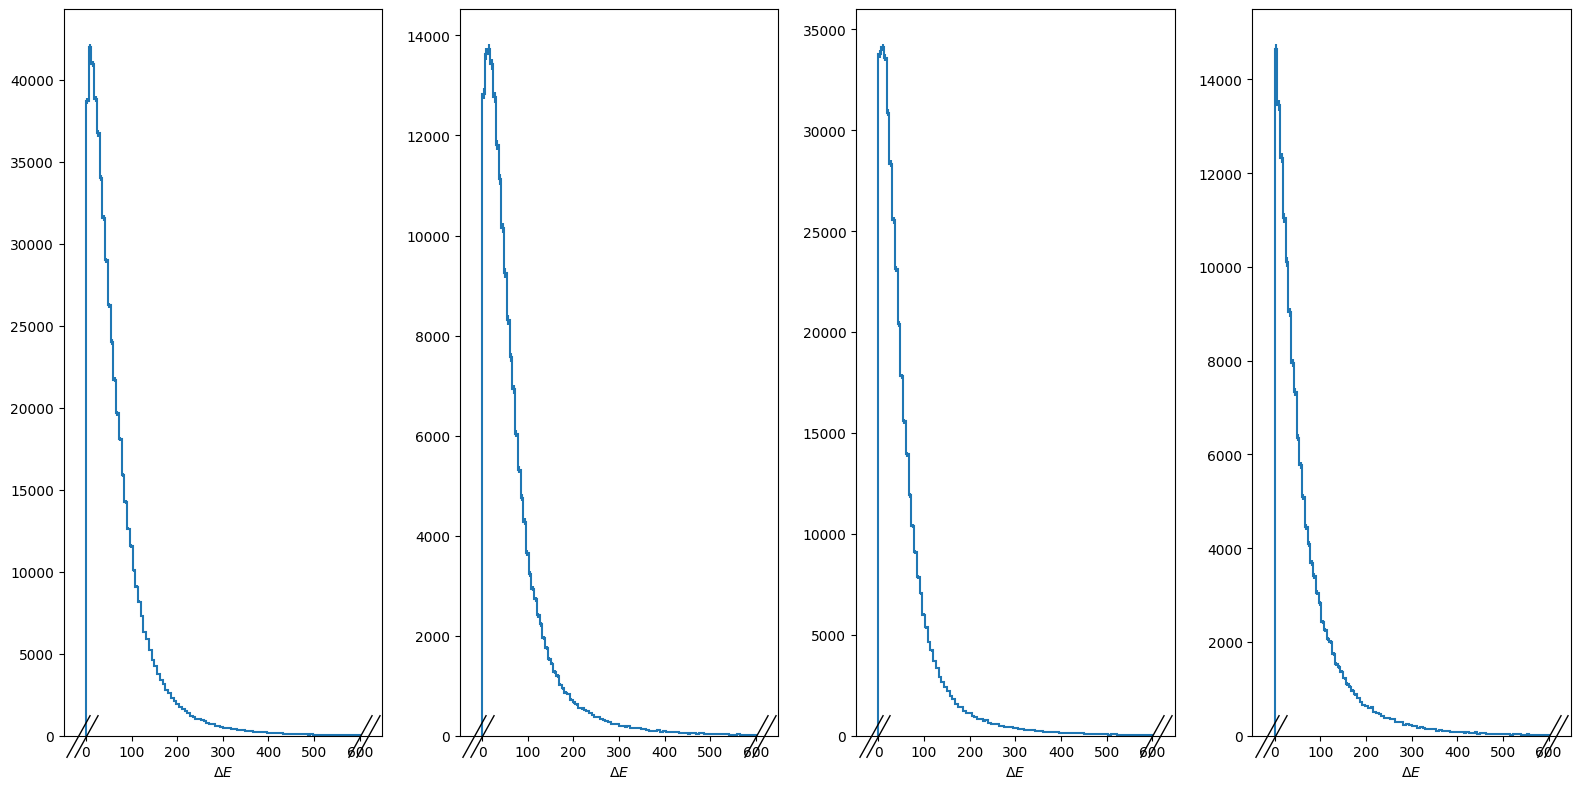

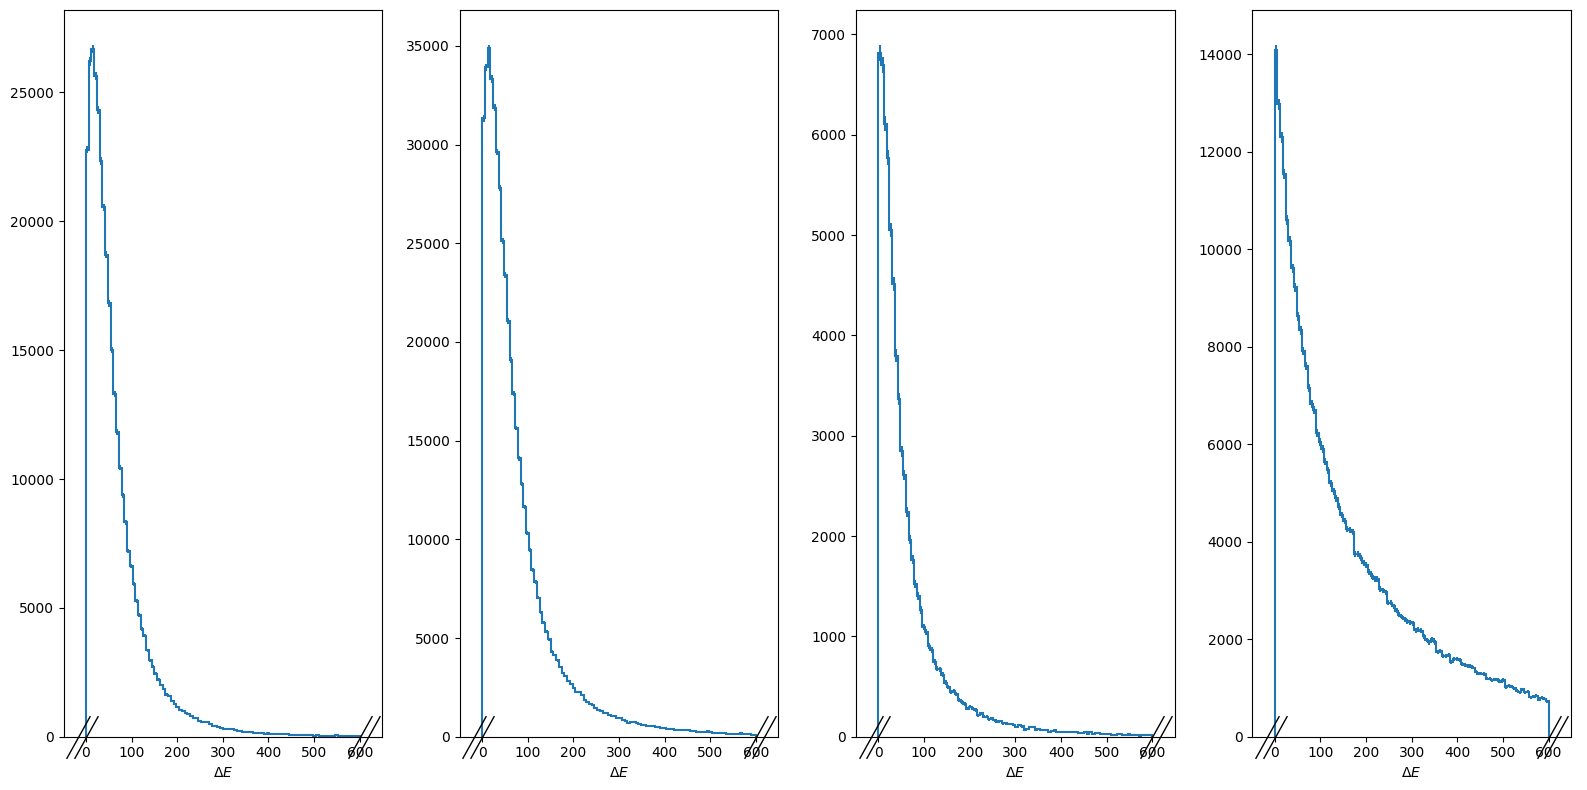

In [18]:
higgs_DiffE = np.abs(higgsCorrect.E - higgs.E)
thad_DiffE = np.abs(thadCorrect.E - thad.E)
tlep_DiffE = np.abs(tlepCorrect.E - tlep.E)
glISR_DiffE = np.abs(glISRCorrect.E - glISR.E)

plots.plot_var1d(higgs_var1=higgs_DiffE, thad_var1=thad_DiffE,
                 tlep_var1=tlep_DiffE, ISR_var1=glISR_DiffE,
                 name1='$\Delta E$', nameFig='17.png',
                 start1=0, stop1=600, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=False, log=False)

plots.plot_var1d(higgs_var1=higgs_DiffE, thad_var1=thad_DiffE,
                 tlep_var1=tlep_DiffE, ISR_var1=glISR_DiffE,
                 name1='$\Delta E$', nameFig='18.png',
                 start1=0, stop1=600, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=True, log=False)

higgs_DiffE = higgsCorrect.E - higgs.E
thad_DiffE = thadCorrect.E - thad.E
tlep_DiffE = tlepCorrect.E - tlep.E
glISR_DiffE = glISRCorrect.E - glISR.E

plots.plot_var1d(higgs_var1=higgs_DiffE, thad_var1=thad_DiffE,
                 tlep_var1=tlep_DiffE, ISR_var1=glISR_DiffE,
                 name1='$\Delta E$', nameFig='19.png',
                 start1=0, stop1=600, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=False, log=False)

plots.plot_var1d(higgs_var1=higgs_DiffE, thad_var1=thad_DiffE,
                 tlep_var1=tlep_DiffE, ISR_var1=glISR_DiffE,
                 name1='$\Delta E$', nameFig='20.png',
                 start1=0, stop1=600, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=True, log=False)

/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is insta

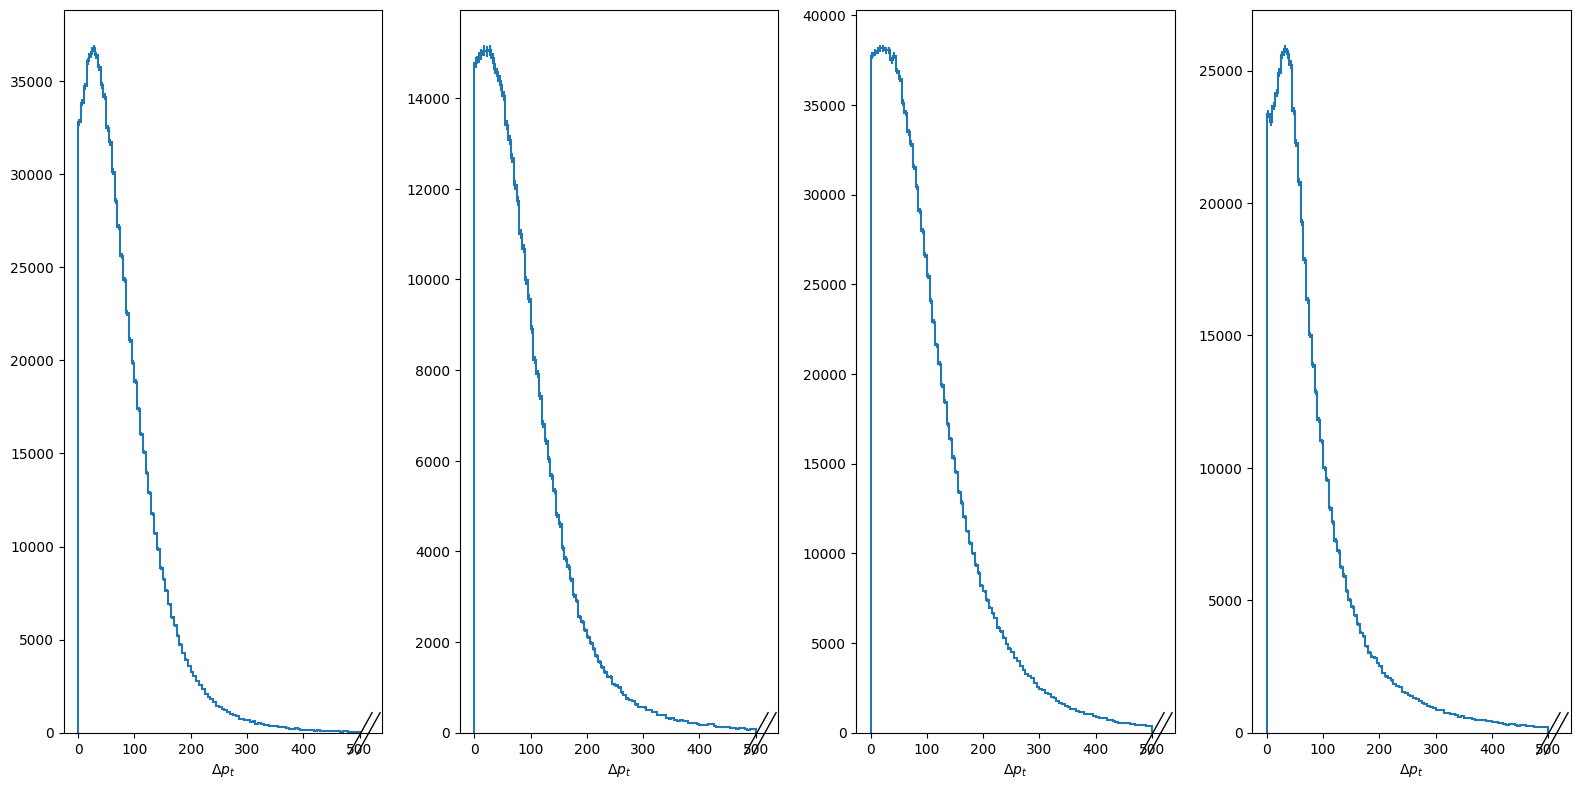

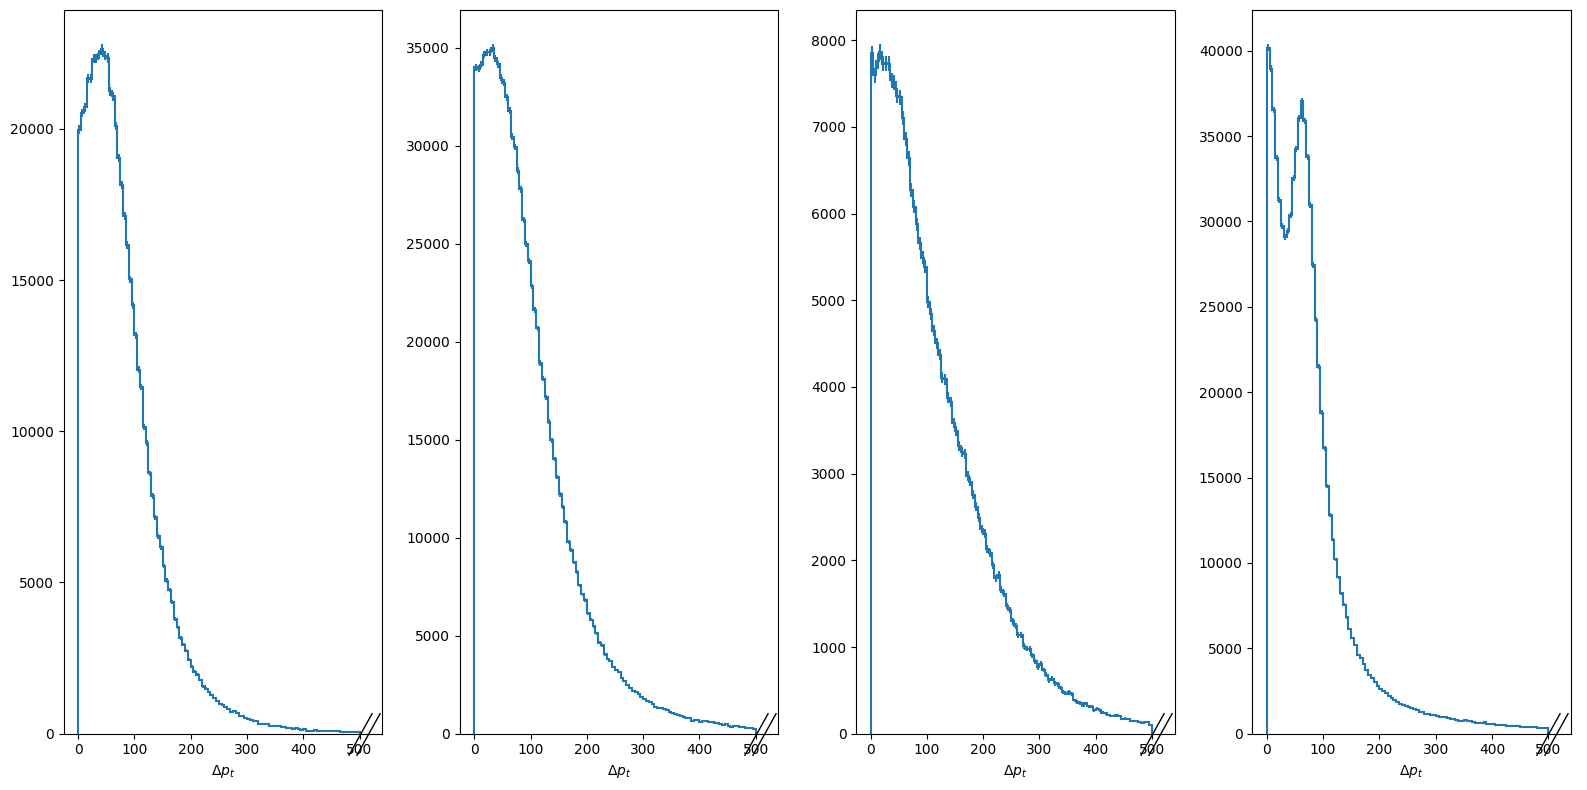

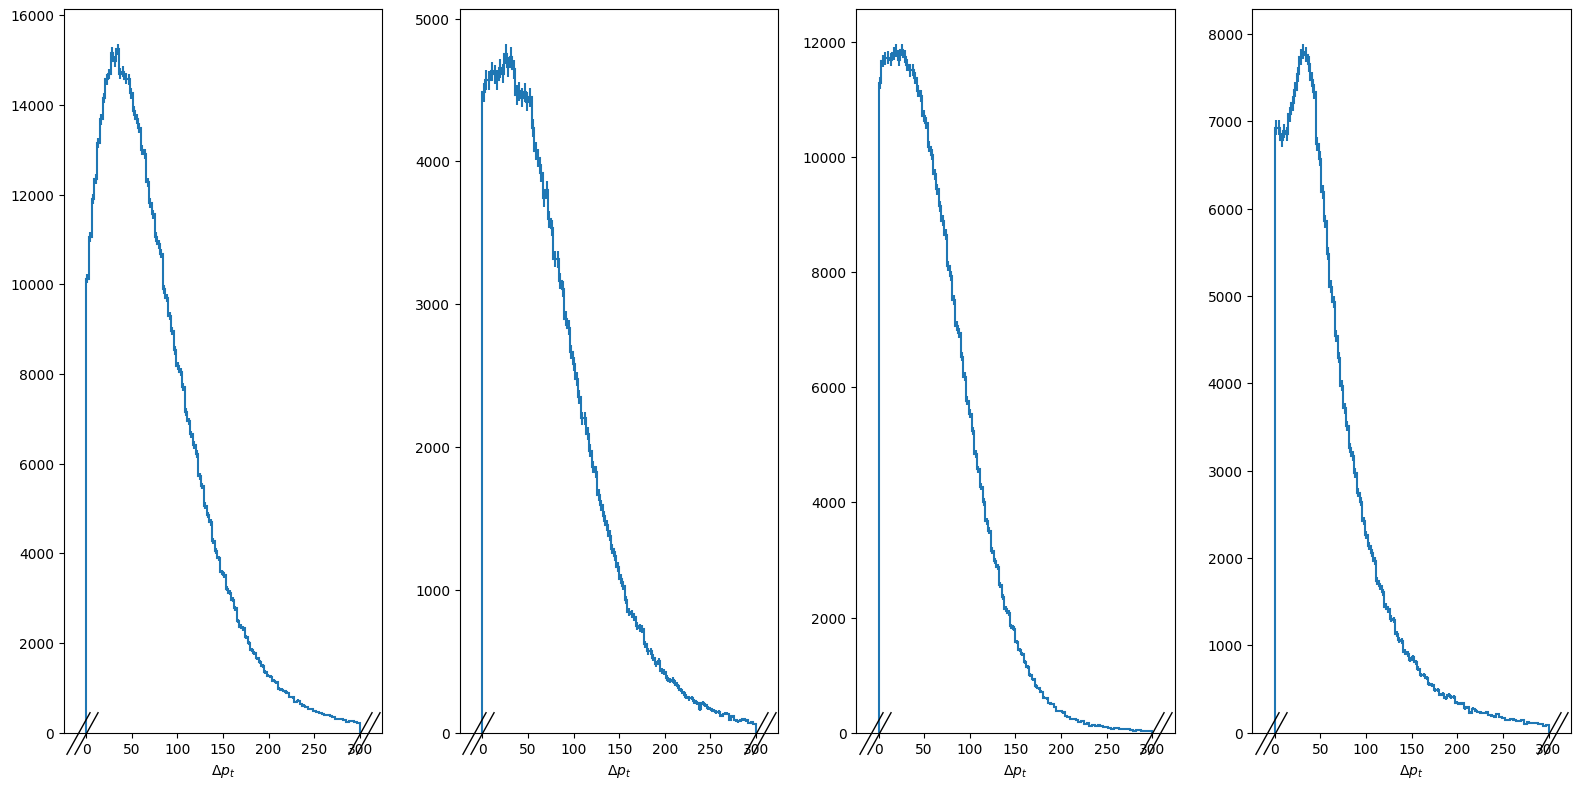

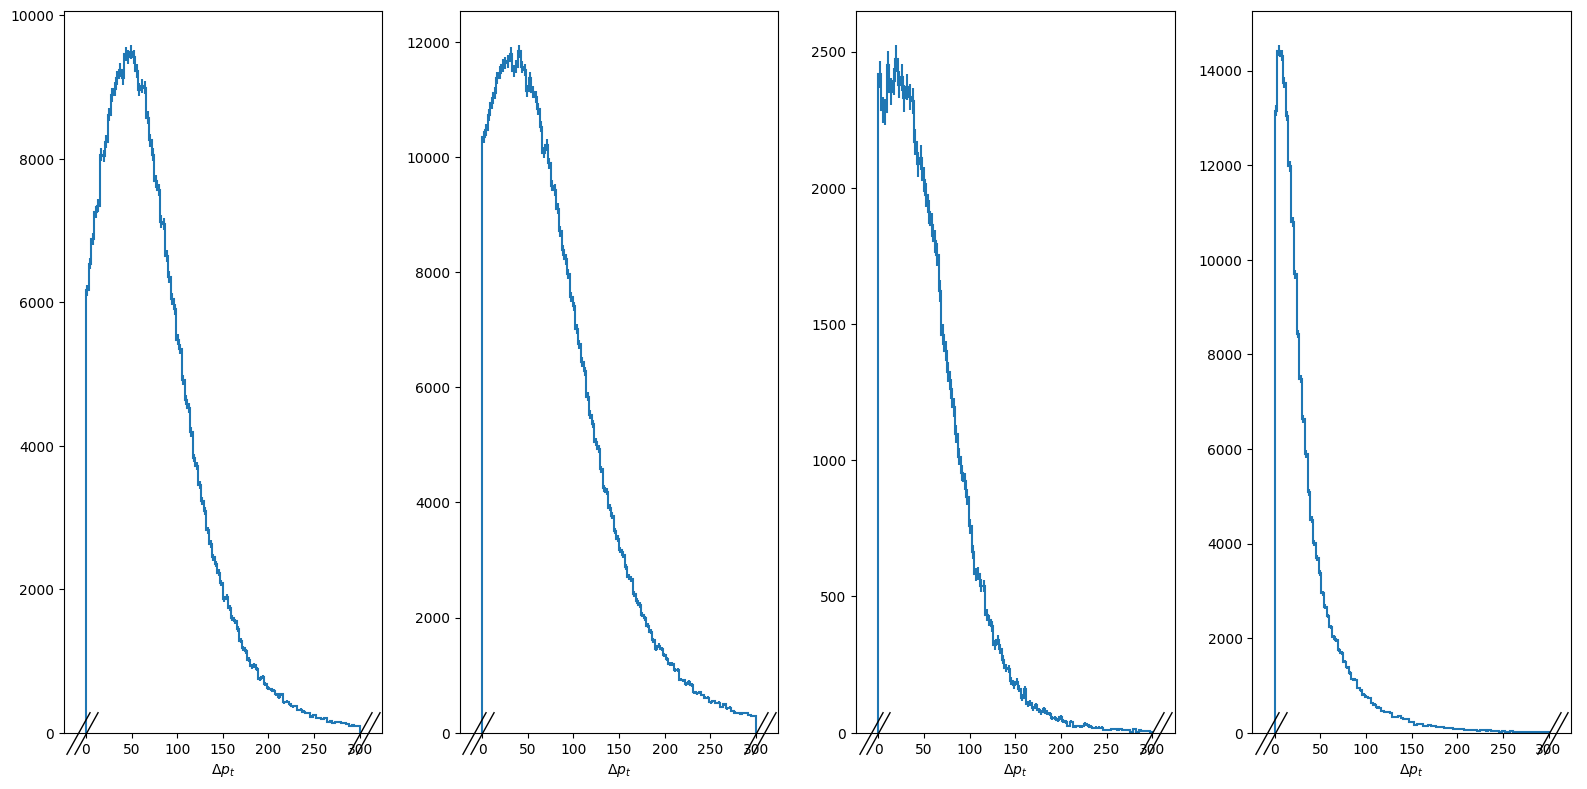

In [19]:
higgs_DiffPt = np.abs(higgsCorrect.pt - higgs.pt)
thad_DiffPt = np.abs(thadCorrect.pt - thad.pt)
tlep_DiffPt = np.abs(tlepCorrect.pt - tlep.pt)
glISR_DiffPt = np.abs(glISRCorrect.pt - glISR.pt)

plots.plot_var1d(higgs_var1=higgs_DiffPt, thad_var1=thad_DiffPt,
                 tlep_var1=tlep_DiffPt, ISR_var1=glISR_DiffPt,
                 name1='$\Delta p_t$', nameFig='21.png',
                 start1=0, stop1=500, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=False, log=False)

plots.plot_var1d(higgs_var1=higgs_DiffPt, thad_var1=thad_DiffPt,
                 tlep_var1=tlep_DiffPt, ISR_var1=glISR_DiffPt,
                 name1='$\Delta p_t$', nameFig='22.png',
                 start1=0, stop1=500, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=True, log=False)

higgs_DiffPt = higgsCorrect.pt - higgs.pt
thad_DiffPt = thadCorrect.pt - thad.pt
tlep_DiffPt = tlepCorrect.pt - tlep.pt
glISR_DiffPt = glISRCorrect.pt - glISR.pt

plots.plot_var1d(higgs_var1=higgs_DiffPt, thad_var1=thad_DiffPt,
                 tlep_var1=tlep_DiffPt, ISR_var1=glISR_DiffPt,
                 name1='$\Delta p_t$', nameFig='23.png',
                 start1=0, stop1=300, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=False, log=False)

plots.plot_var1d(higgs_var1=higgs_DiffPt, thad_var1=thad_DiffPt,
                 tlep_var1=tlep_DiffPt, ISR_var1=glISR_DiffPt,
                 name1='$\Delta p_t$', nameFig='24.png',
                 start1=0, stop1=300, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=True, log=False)

/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/work/adpetre/miniconda3/envs/dizertatie/lib/python3.11/site-packages/mplhep/utils.py:271: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is insta

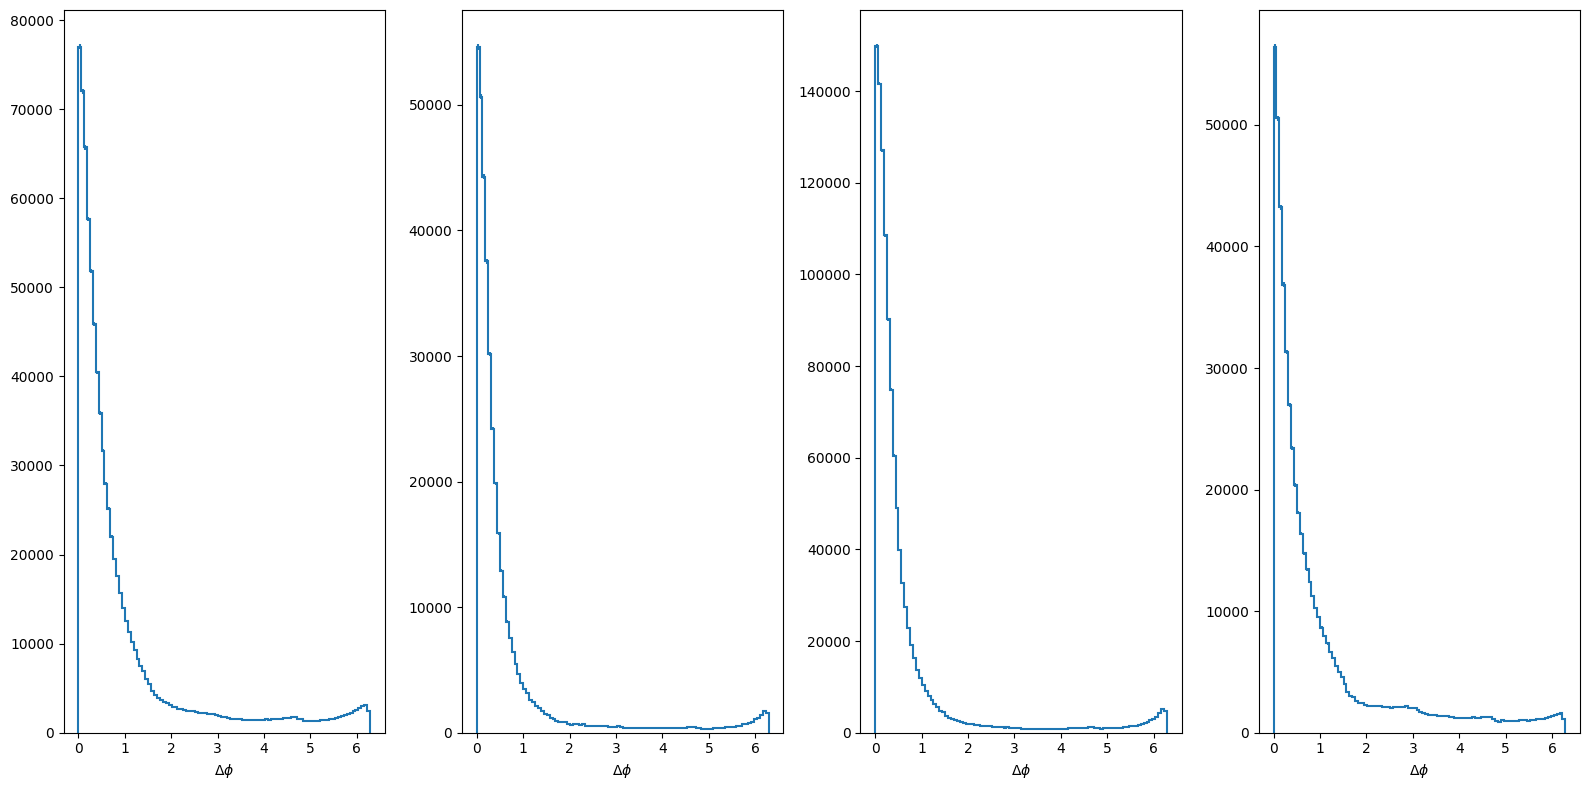

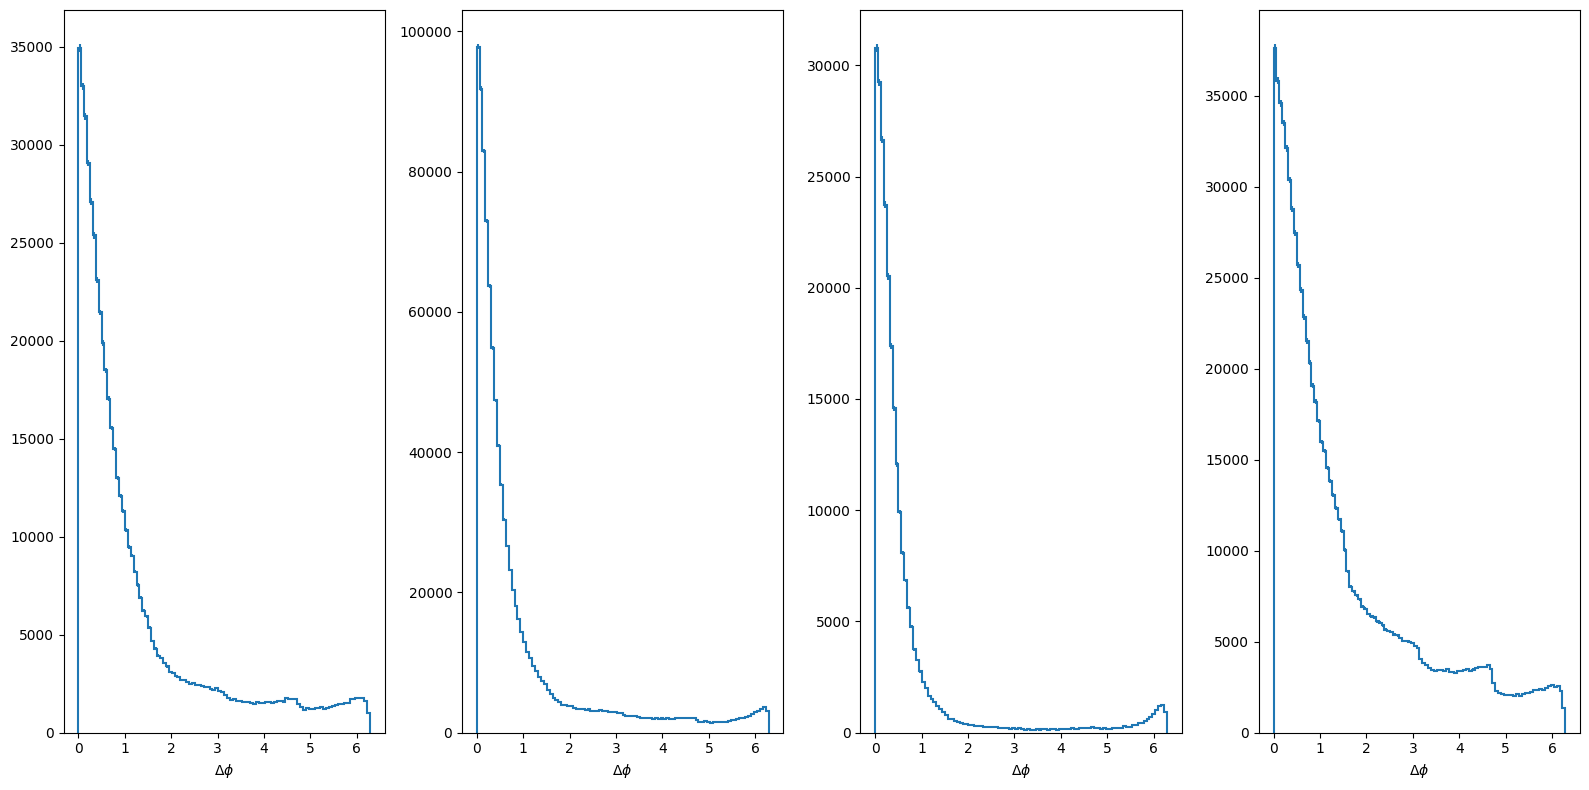

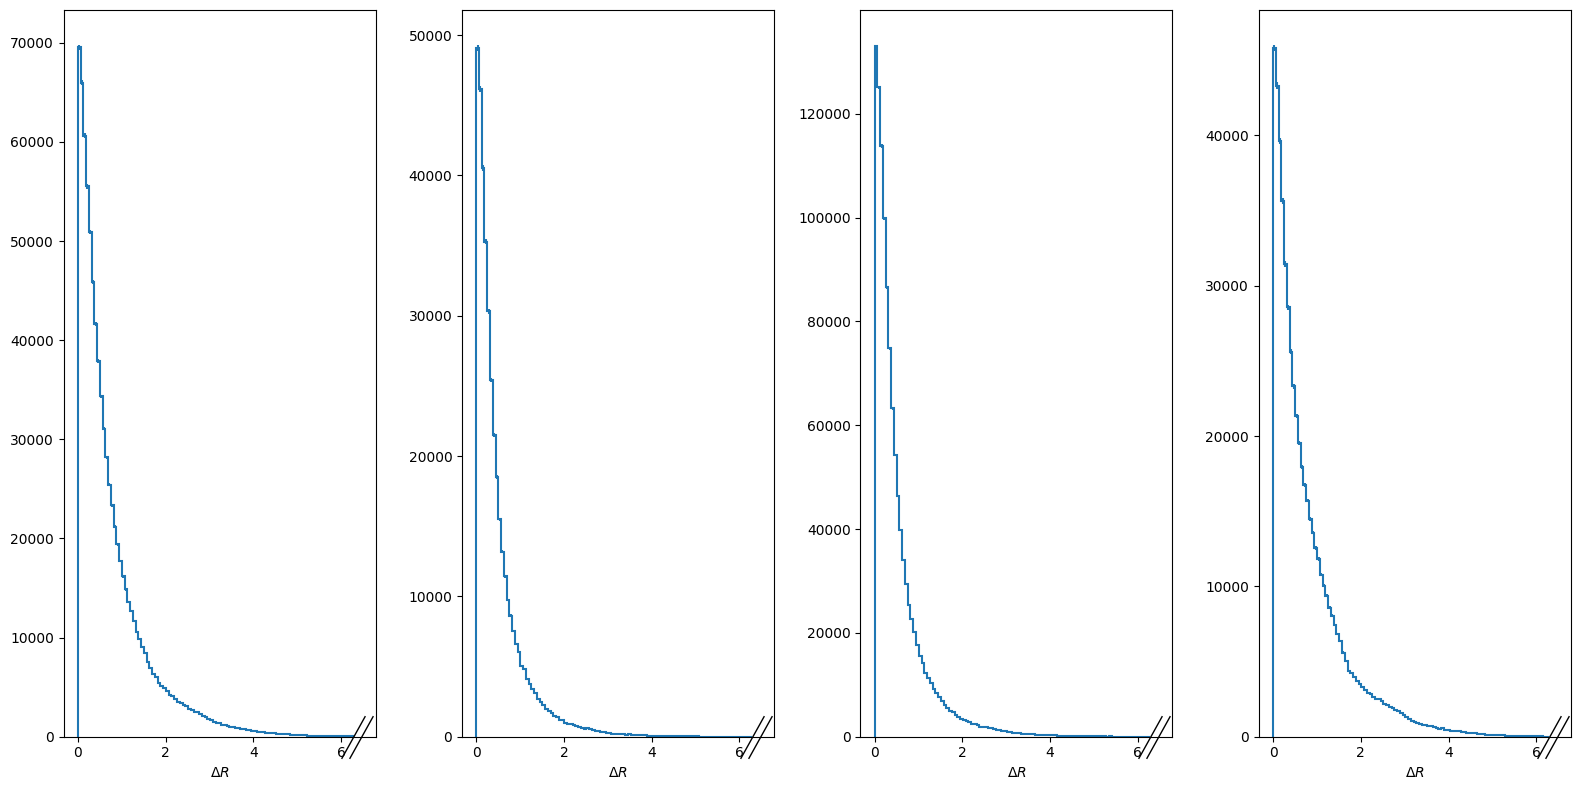

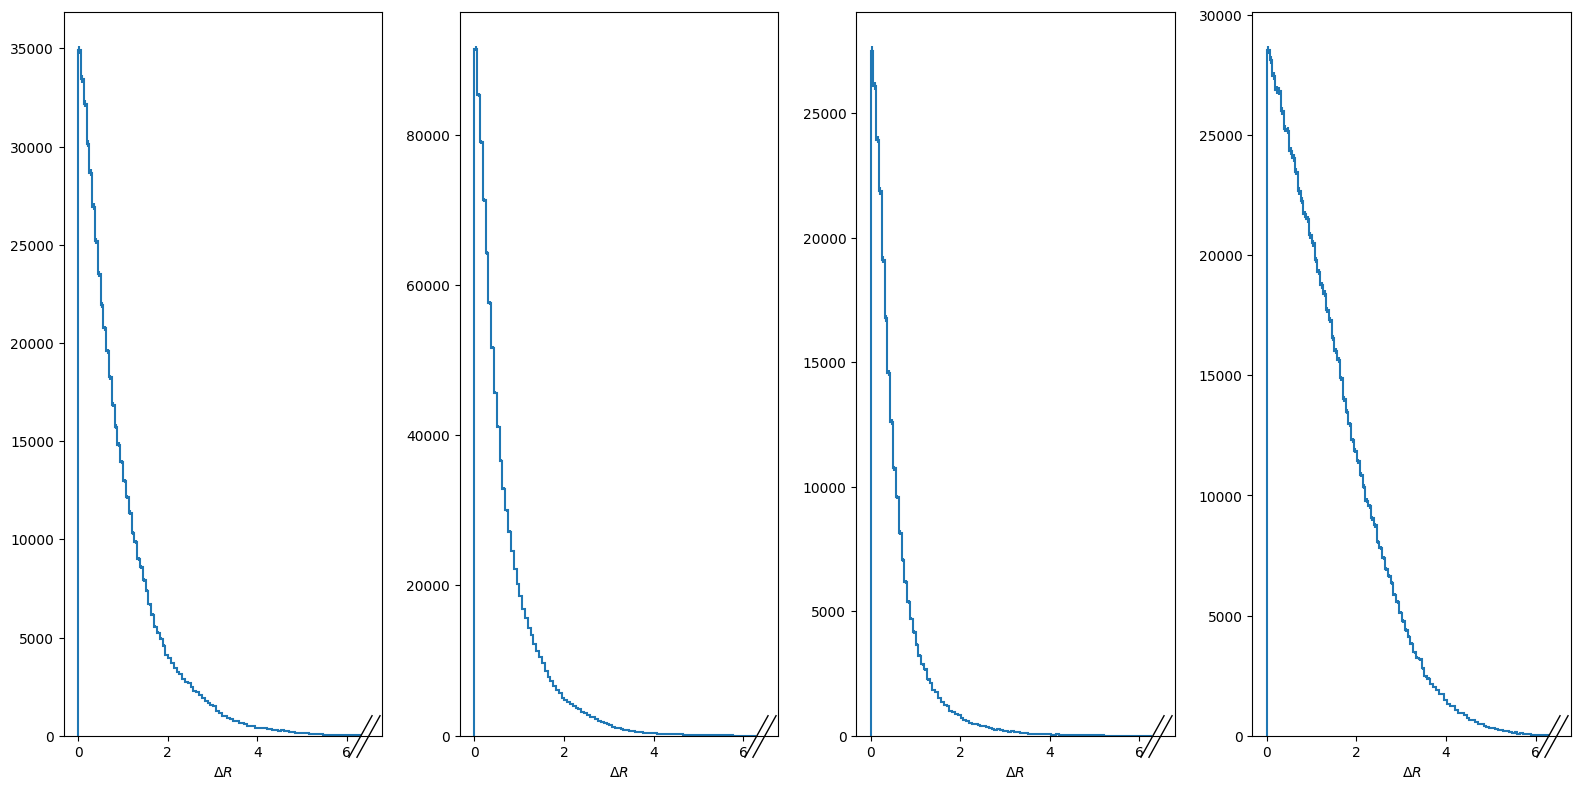

In [20]:
higgs_DiffPhi = np.abs(higgsCorrect.phi - higgs.phi)
thad_DiffPhi = np.abs(thadCorrect.phi - thad.phi)
tlep_DiffPhi = np.abs(tlepCorrect.phi - tlep.phi)
glISR_DiffPhi = np.abs(glISRCorrect.phi - glISR.phi)

plots.plot_var1d(higgs_var1=higgs_DiffPhi, thad_var1=thad_DiffPhi,
                 tlep_var1=tlep_DiffPhi, ISR_var1=glISR_DiffPhi,
                 name1='$\Delta \phi$', nameFig='25.png',
                 start1=0, stop1=2*pi, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=False, log=False)

plots.plot_var1d(higgs_var1=higgs_DiffPhi, thad_var1=thad_DiffPhi,
                 tlep_var1=tlep_DiffPhi, ISR_var1=glISR_DiffPhi,
                 name1='$\Delta \phi$', nameFig='26.png',
                 start1=0, stop1=2*pi, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=True, log=False)

higgs_DiffR = np.abs(np.sqrt(higgs.phi**2 + higgs.eta**2) -  np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2))
thad_DiffR = np.abs(np.sqrt(thad.phi**2 + thad.eta**2) -  np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2))
tlep_DiffR = np.abs(np.sqrt(tlep.phi**2 + tlep.eta**2) -  np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2))
glISR_DiffR = np.abs(np.sqrt(glISR.phi**2 + glISR.eta**2) -  np.sqrt(glISRCorrect.phi**2 + glISRCorrect.eta**2))

plots.plot_var1d(higgs_var1=higgs_DiffR, thad_var1=thad_DiffR,
                 tlep_var1=tlep_DiffR, ISR_var1=glISR_DiffR,
                 name1='$\Delta R$', nameFig='27.png',
                 start1=0, stop1=2*pi, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=False, log=False)

plots.plot_var1d(higgs_var1=higgs_DiffR, thad_var1=thad_DiffR,
                 tlep_var1=tlep_DiffR, ISR_var1=glISR_DiffR,
                 name1='$\Delta R$', nameFig='28.png',
                 start1=0, stop1=2*pi, bins1=100,
                 higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
                 neg_Mask=True, log=False)

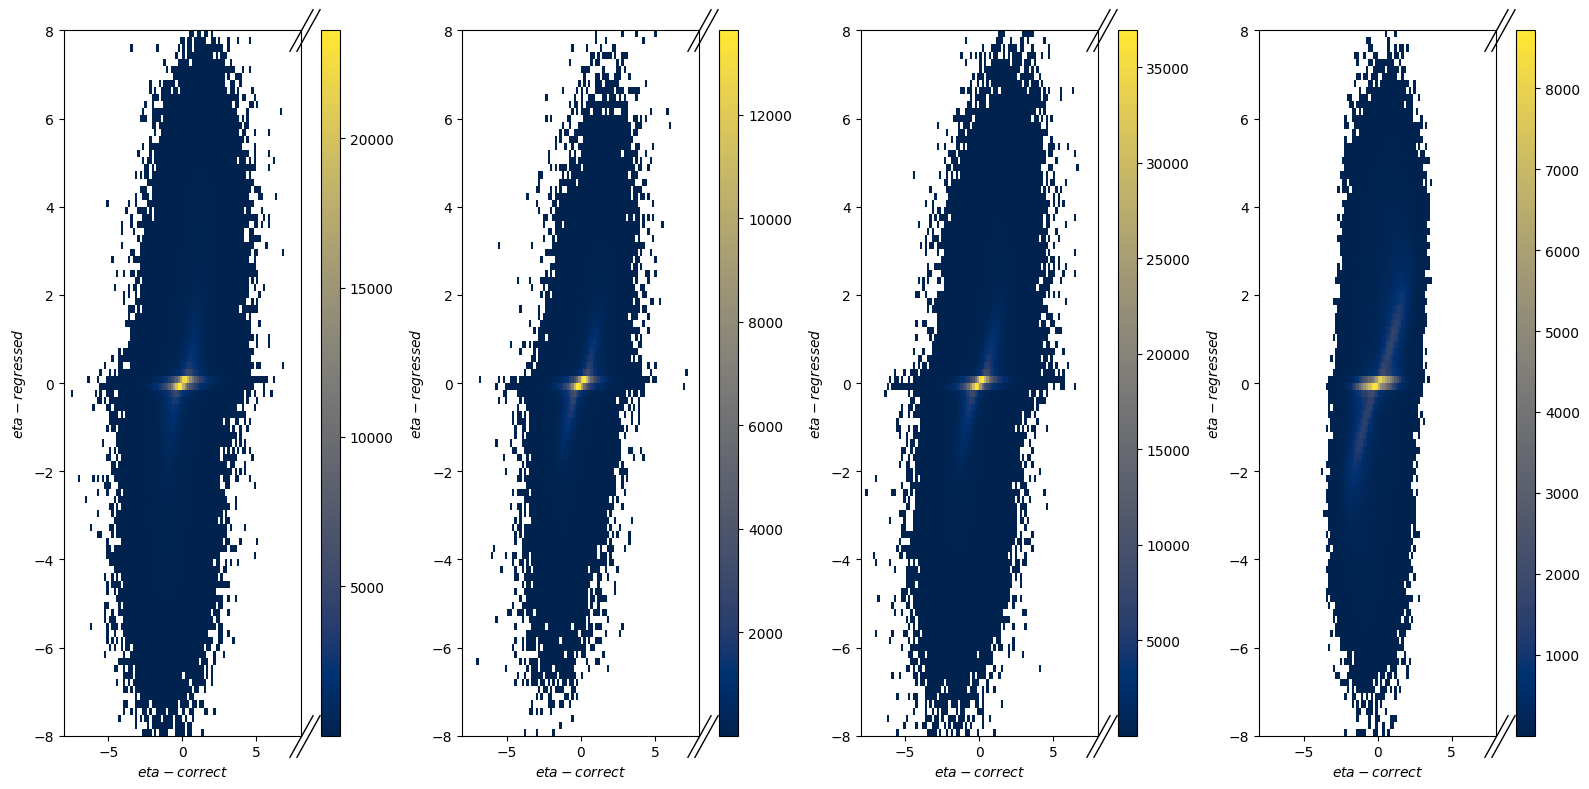

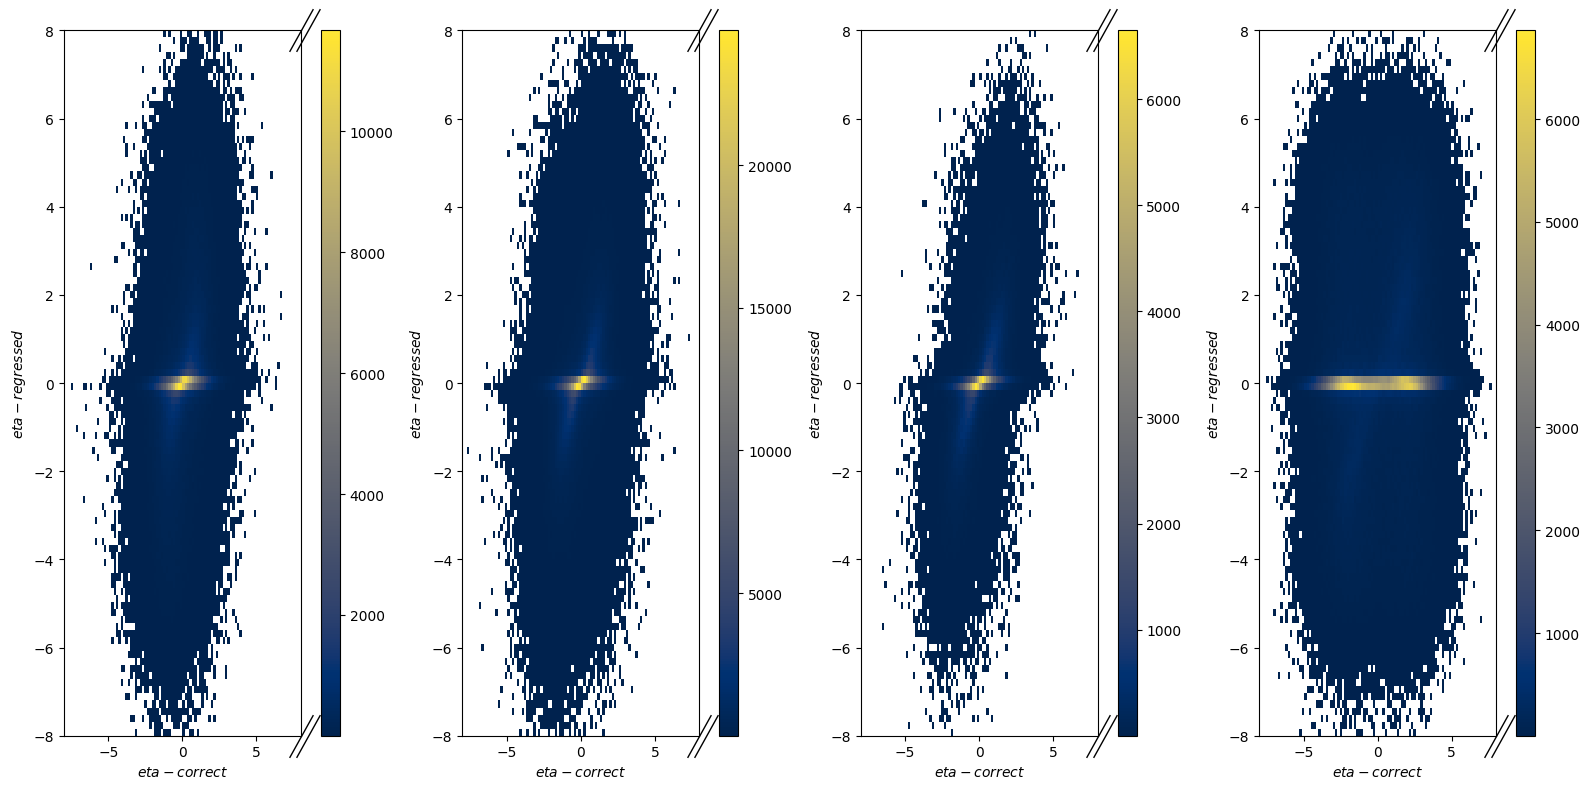

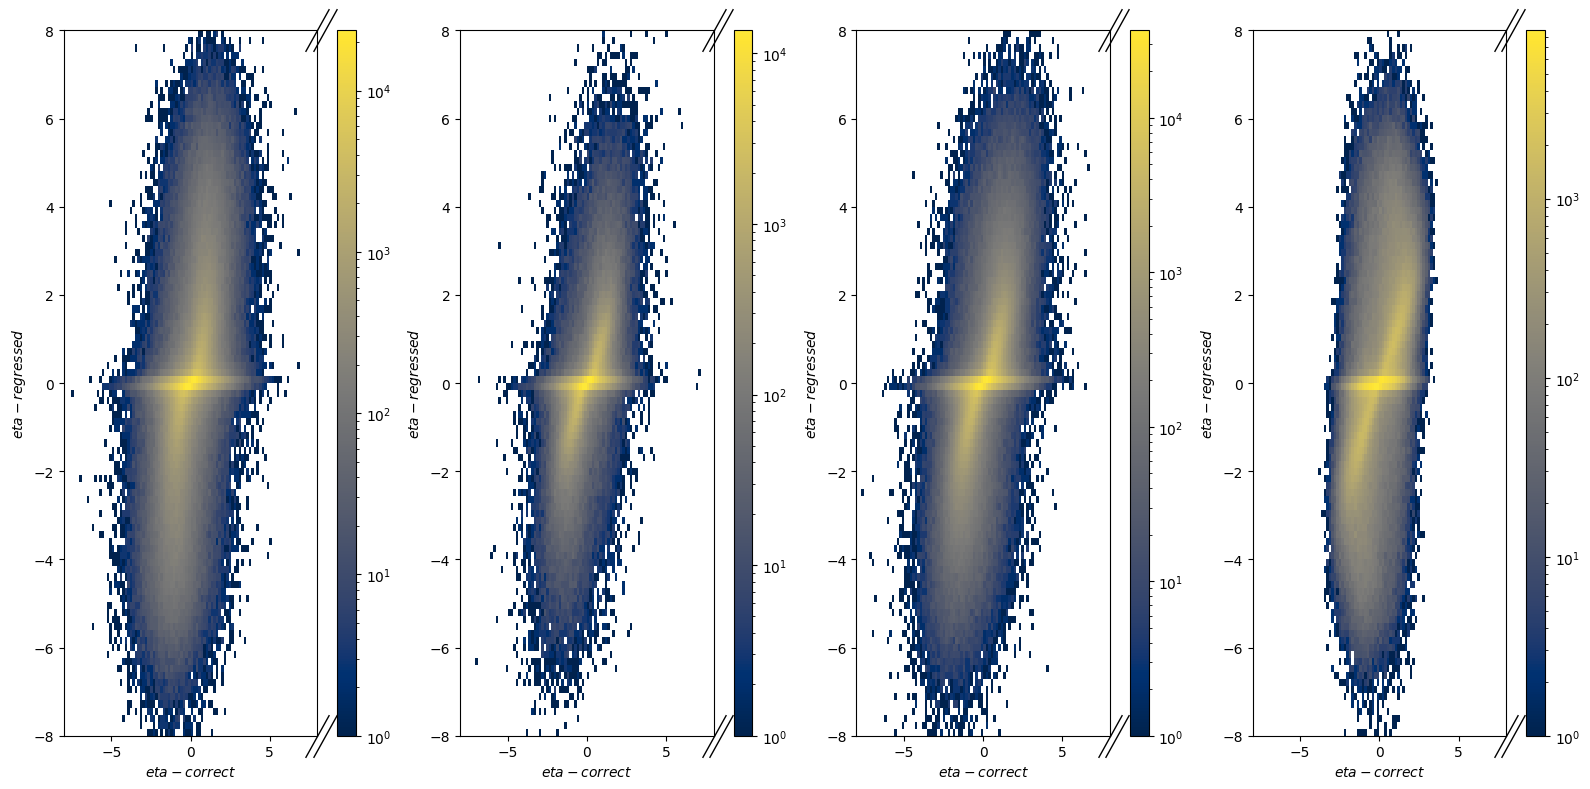

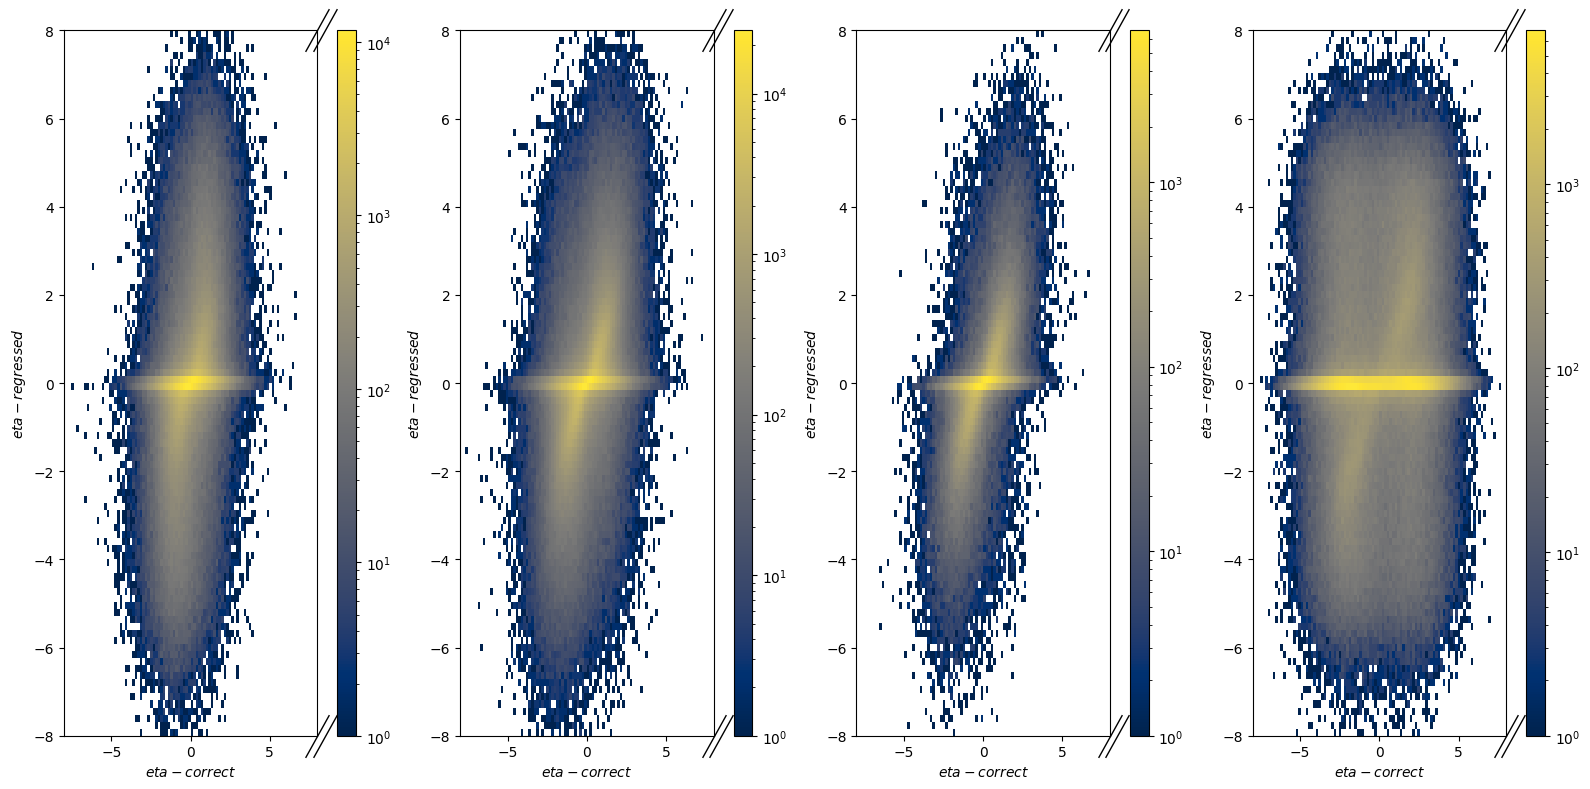

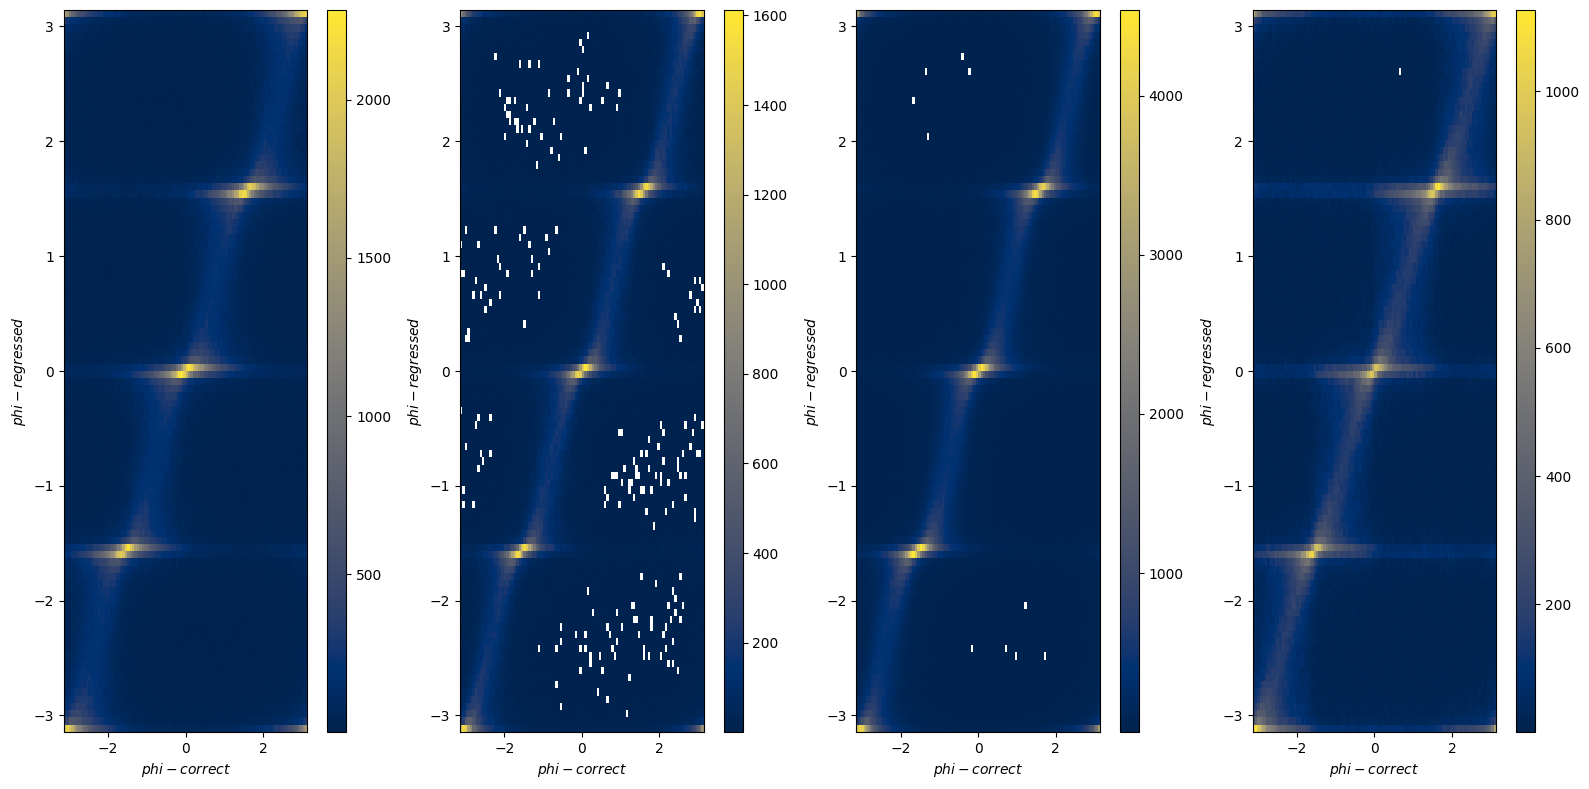

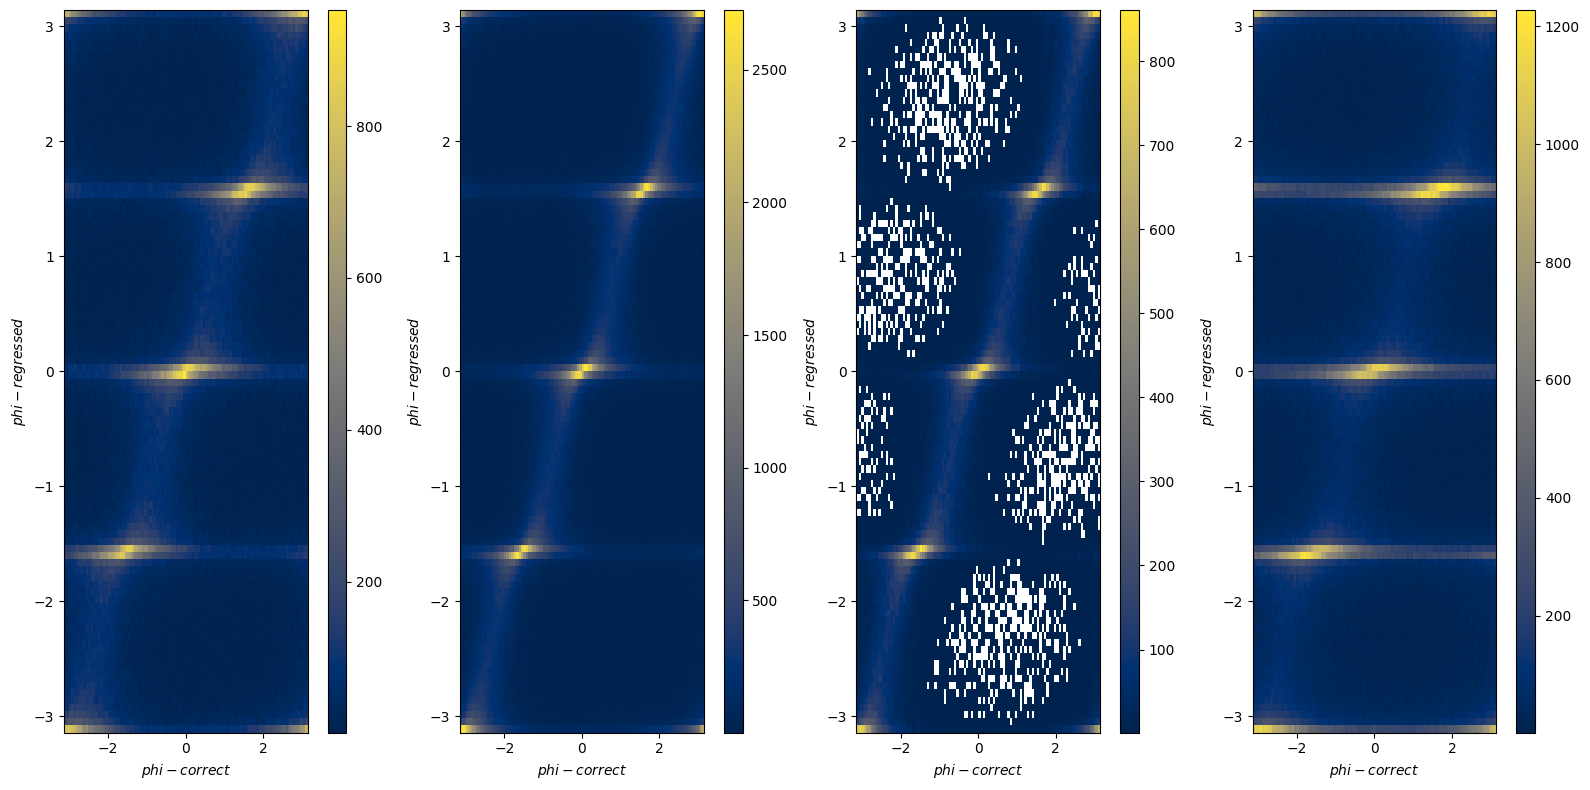

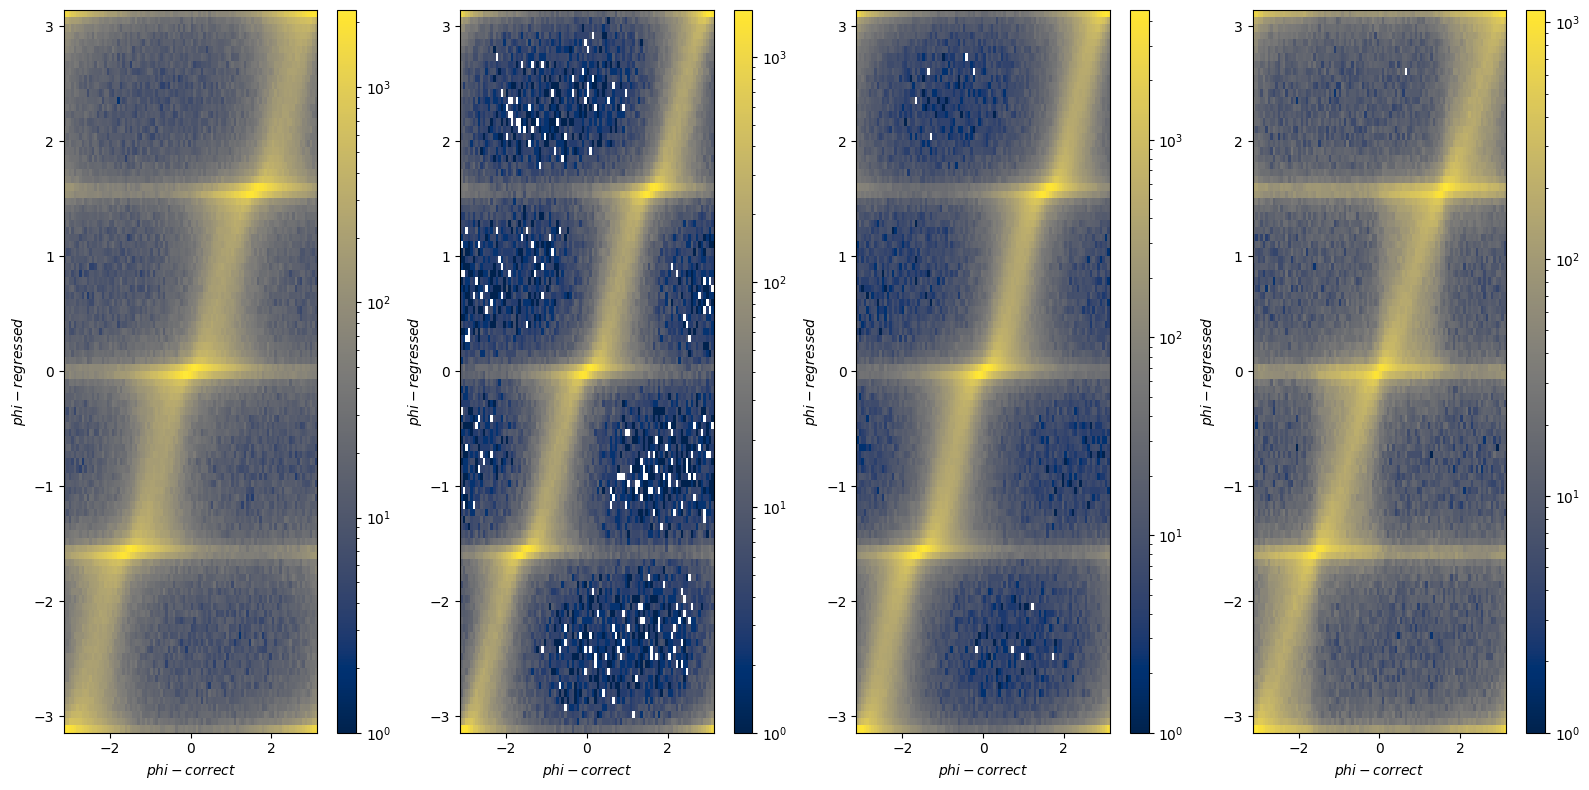

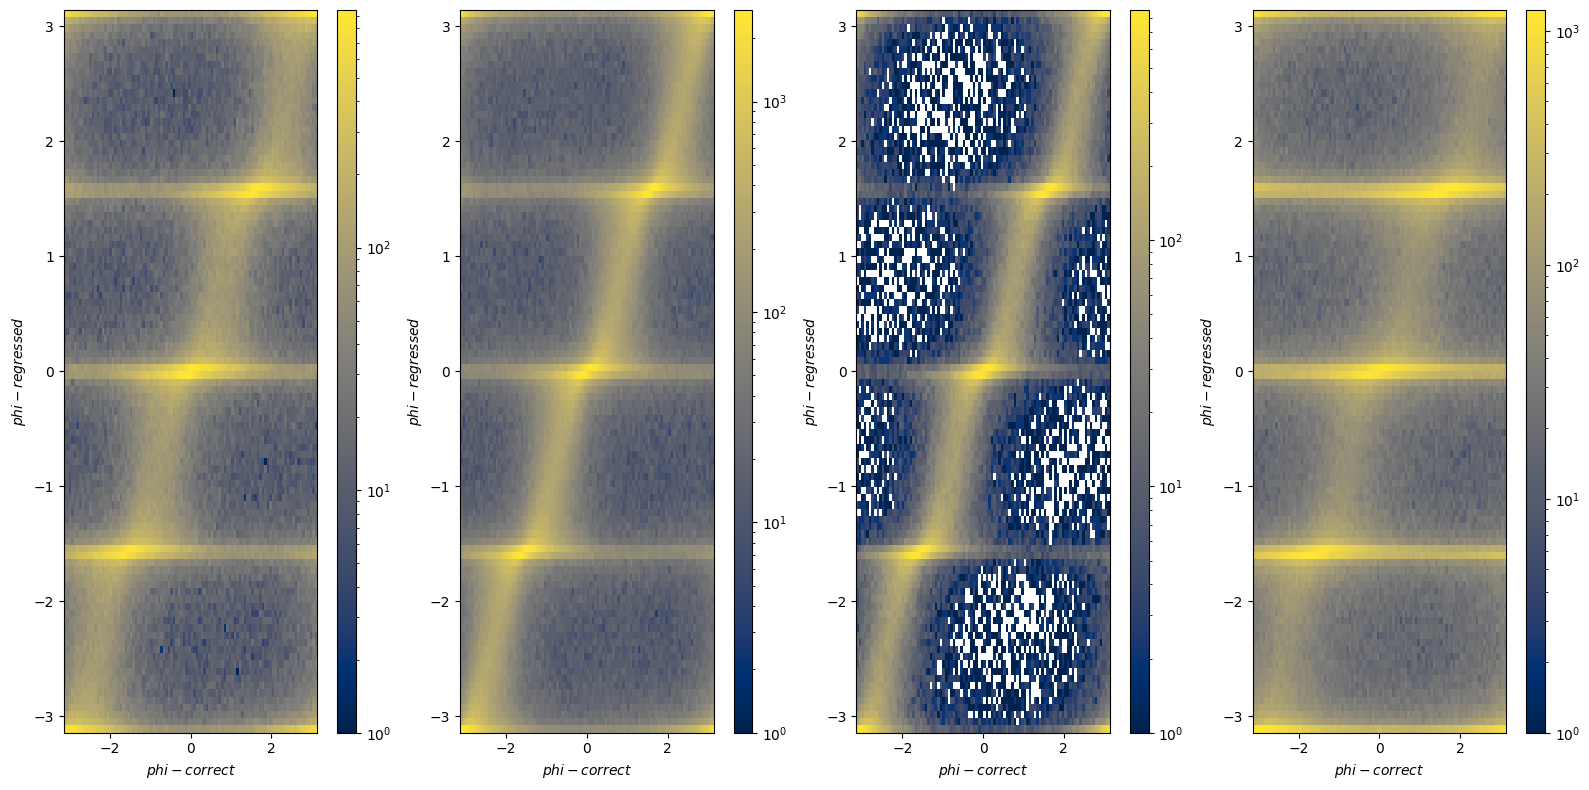

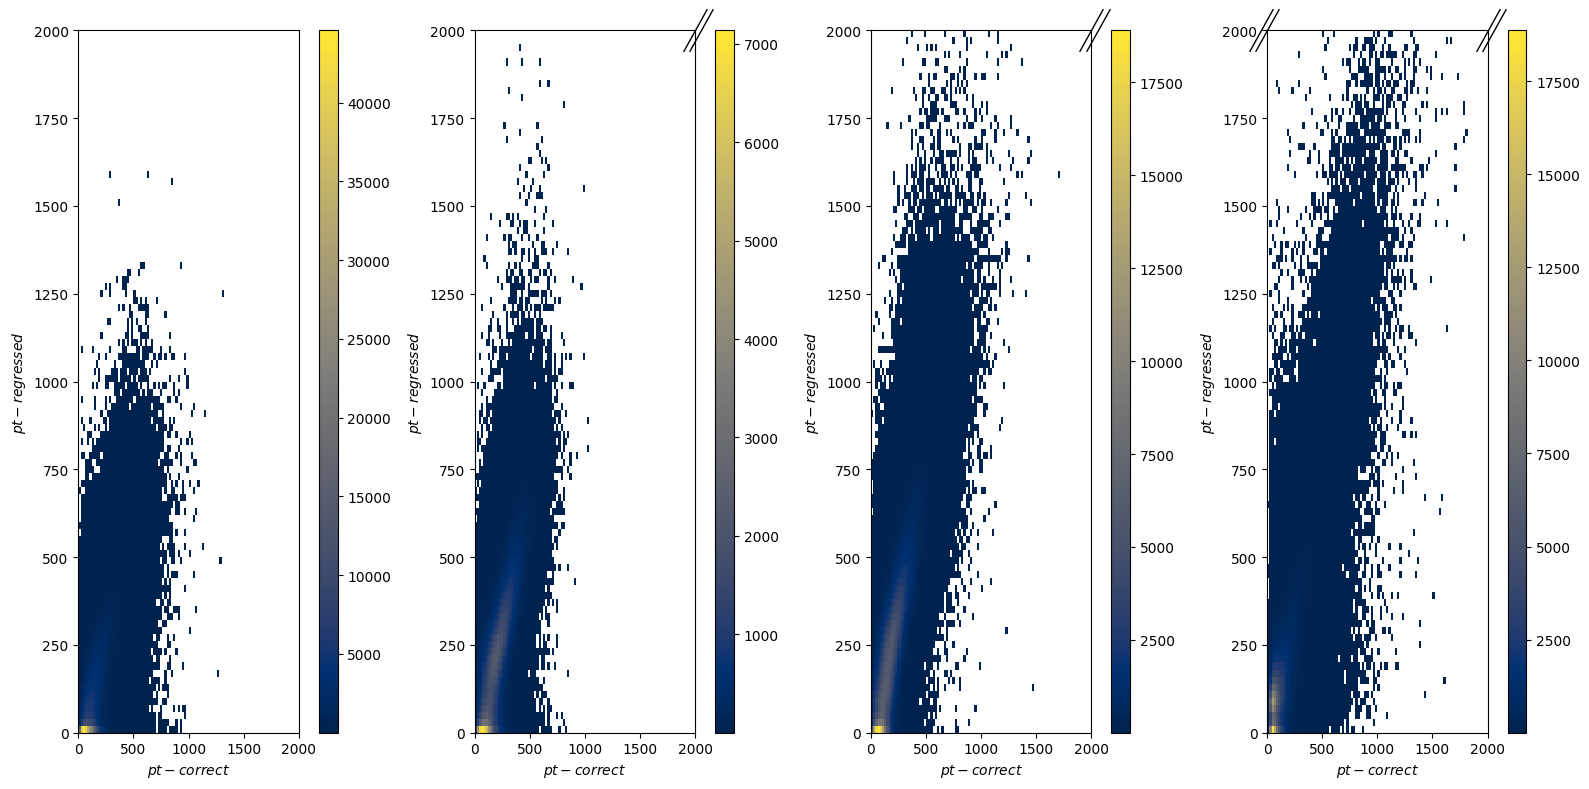

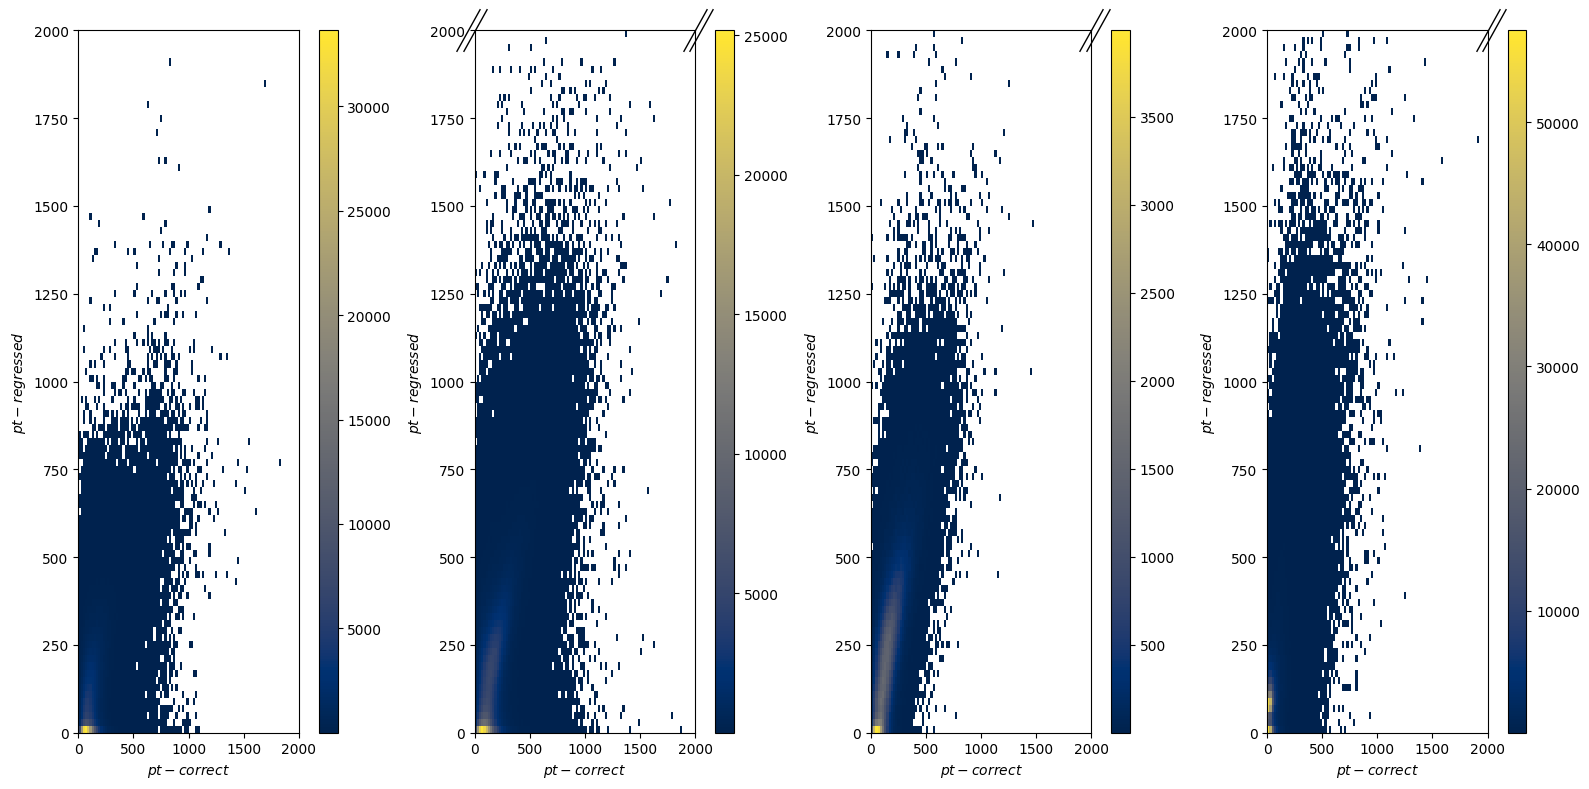

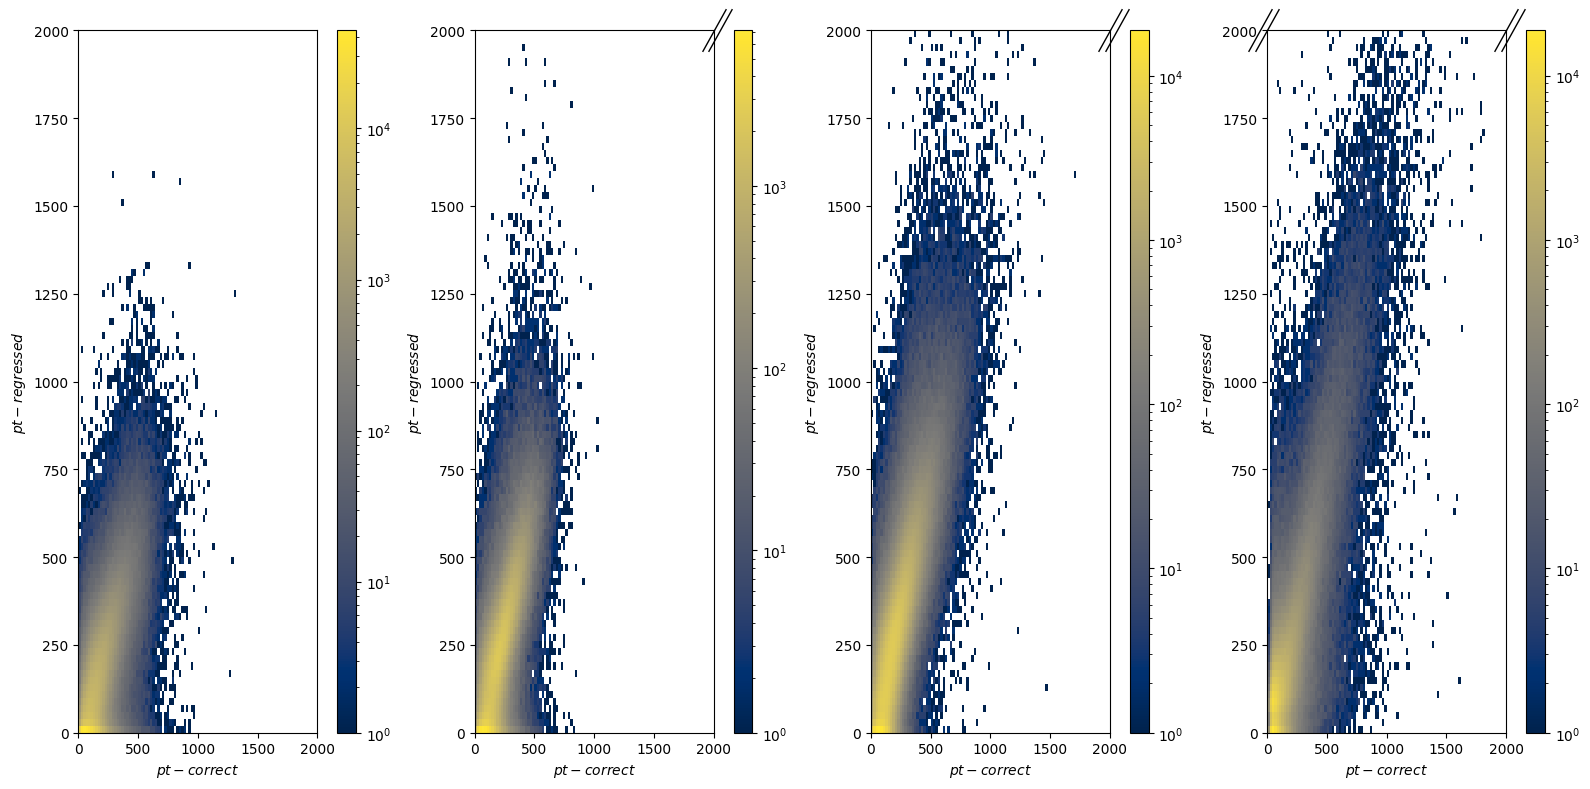

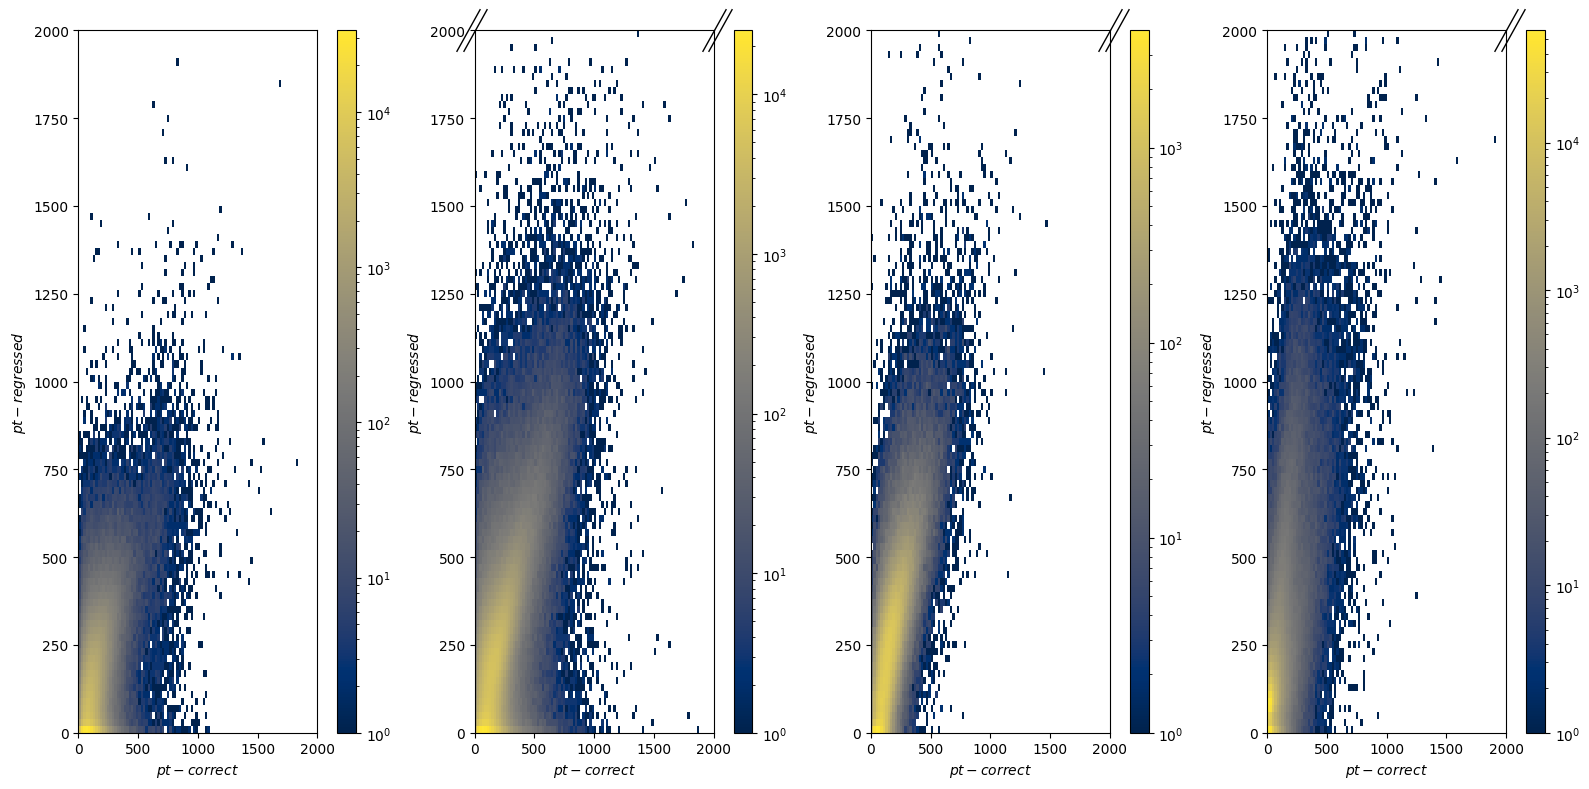

In [21]:
#eta
plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs.eta,
           thad_var1=thadCorrect.eta, thad_var2=thad.eta,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep.eta,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR.eta,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='29.png', 
           start1=-8, stop1=8, start2=-8, stop2=8, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs.eta,
           thad_var1=thadCorrect.eta, thad_var2=thad.eta,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep.eta,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR.eta,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='30.png', 
           start1=-8, stop1=8, start2=-8, stop2=8, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs.eta,
           thad_var1=thadCorrect.eta, thad_var2=thad.eta,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep.eta,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR.eta,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='31.png', 
           start1=-8, stop1=8, start2=-8, stop2=8, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=True)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs.eta,
           thad_var1=thadCorrect.eta, thad_var2=thad.eta,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep.eta,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR.eta,
           name1='$eta-correct$', name2='$eta-regressed$', nameFig='32.png', 
           start1=-8, stop1=8, start2=-8, stop2=8, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=True)


# phi
plots.plot_var2d(higgs_var1=higgsCorrect.phi, higgs_var2=higgs.phi,
           thad_var1=thadCorrect.phi, thad_var2=thad.phi,
           tlep_var1=tlepCorrect.phi, tlep_var2=tlep.phi,
           ISR_var1=glISRCorrect.phi, ISR_var2=glISR.phi,
           name1='$phi-correct$', name2='$phi-regressed$', nameFig='33.png', 
           start1=-pi, stop1=pi, start2=-pi, stop2=pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.phi, higgs_var2=higgs.phi,
           thad_var1=thadCorrect.phi, thad_var2=thad.phi,
           tlep_var1=tlepCorrect.phi, tlep_var2=tlep.phi,
           ISR_var1=glISRCorrect.phi, ISR_var2=glISR.phi,
           name1='$phi-correct$', name2='$phi-regressed$', nameFig='34.png', 
           start1=-pi, stop1=pi, start2=-pi, stop2=pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.phi, higgs_var2=higgs.phi,
           thad_var1=thadCorrect.phi, thad_var2=thad.phi,
           tlep_var1=tlepCorrect.phi, tlep_var2=tlep.phi,
           ISR_var1=glISRCorrect.phi, ISR_var2=glISR.phi,
           name1='$phi-correct$', name2='$phi-regressed$', nameFig='35.png', 
           start1=-pi, stop1=pi, start2=-pi, stop2=pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=True)

plots.plot_var2d(higgs_var1=higgsCorrect.phi, higgs_var2=higgs.phi,
           thad_var1=thadCorrect.phi, thad_var2=thad.phi,
           tlep_var1=tlepCorrect.phi, tlep_var2=tlep.phi,
           ISR_var1=glISRCorrect.phi, ISR_var2=glISR.phi,
           name1='$phi-correct$', name2='$phi-regressed$', nameFig='36.png', 
           start1=-pi, stop1=pi, start2=-pi, stop2=pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=True)

# pt
plots.plot_var2d(higgs_var1=higgsCorrect.pt, higgs_var2=higgs.pt,
           thad_var1=thadCorrect.pt, thad_var2=thad.pt,
           tlep_var1=tlepCorrect.pt, tlep_var2=tlep.pt,
           ISR_var1=glISRCorrect.pt, ISR_var2=glISR.pt,
           name1='$pt-correct$', name2='$pt-regressed$', nameFig='37.png', 
           start1=0, stop1=2000, start2=0, stop2=2000, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.pt, higgs_var2=higgs.pt,
           thad_var1=thadCorrect.pt, thad_var2=thad.pt,
           tlep_var1=tlepCorrect.pt, tlep_var2=tlep.pt,
           ISR_var1=glISRCorrect.pt, ISR_var2=glISR.pt,
           name1='$pt-correct$', name2='$pt-regressed$', nameFig='38.png', 
           start1=0, stop1=2000, start2=0, stop2=2000, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.pt, higgs_var2=higgs.pt,
           thad_var1=thadCorrect.pt, thad_var2=thad.pt,
           tlep_var1=tlepCorrect.pt, tlep_var2=tlep.pt,
           ISR_var1=glISRCorrect.pt, ISR_var2=glISR.pt,
           name1='$pt-correct$', name2='$pt-regressed$', nameFig='39.png', 
           start1=0, stop1=2000, start2=0, stop2=2000, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=True)

plots.plot_var2d(higgs_var1=higgsCorrect.pt, higgs_var2=higgs.pt,
           thad_var1=thadCorrect.pt, thad_var2=thad.pt,
           tlep_var1=tlepCorrect.pt, tlep_var2=tlep.pt,
           ISR_var1=glISRCorrect.pt, ISR_var2=glISR.pt,
           name1='$pt-correct$', name2='$pt-regressed$', nameFig='40.png', 
           start1=0, stop1=2000, start2=0, stop2=2000, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=True)

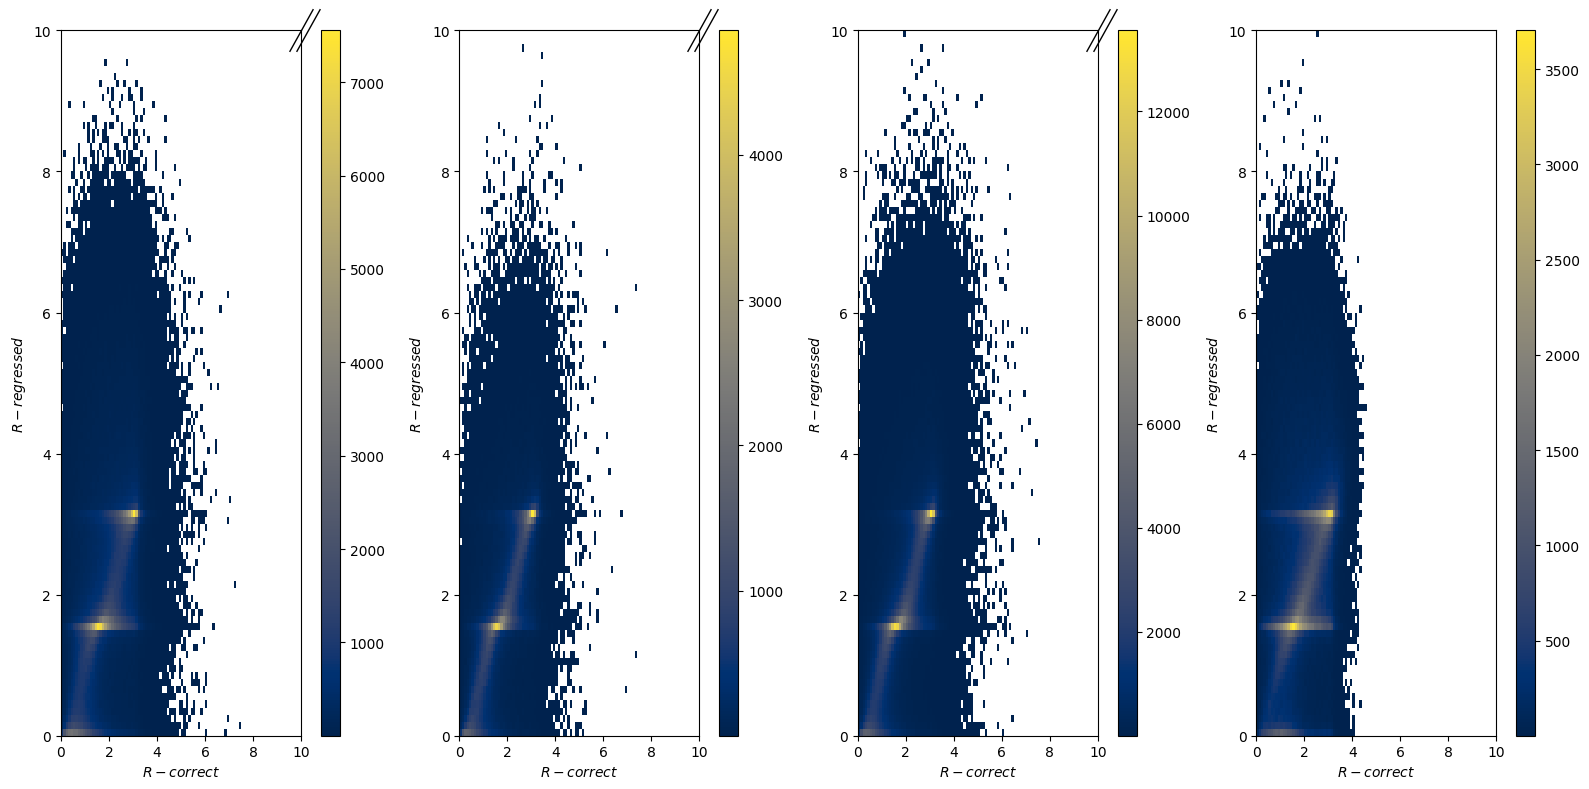

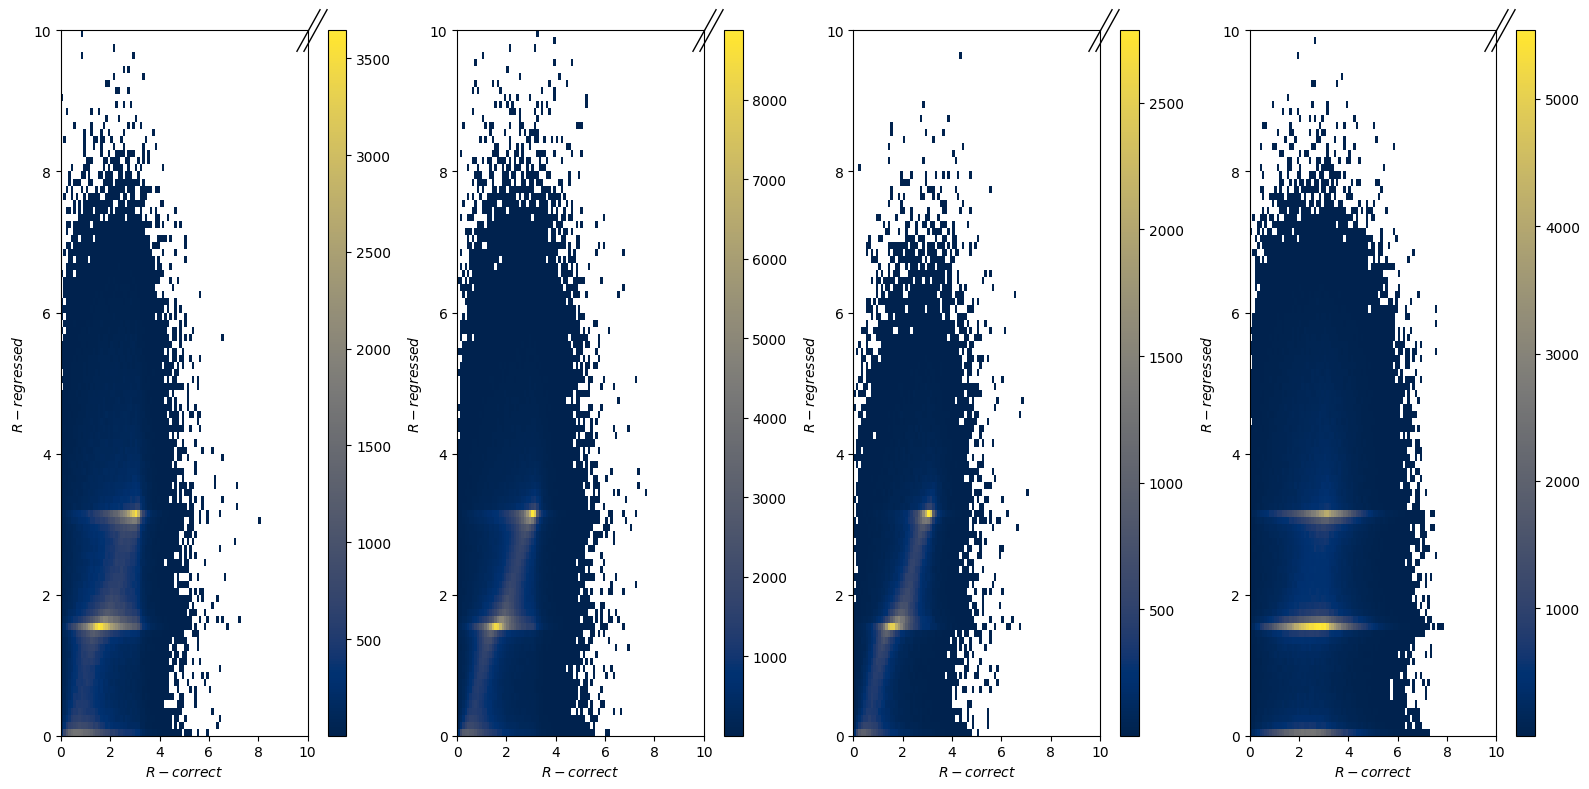

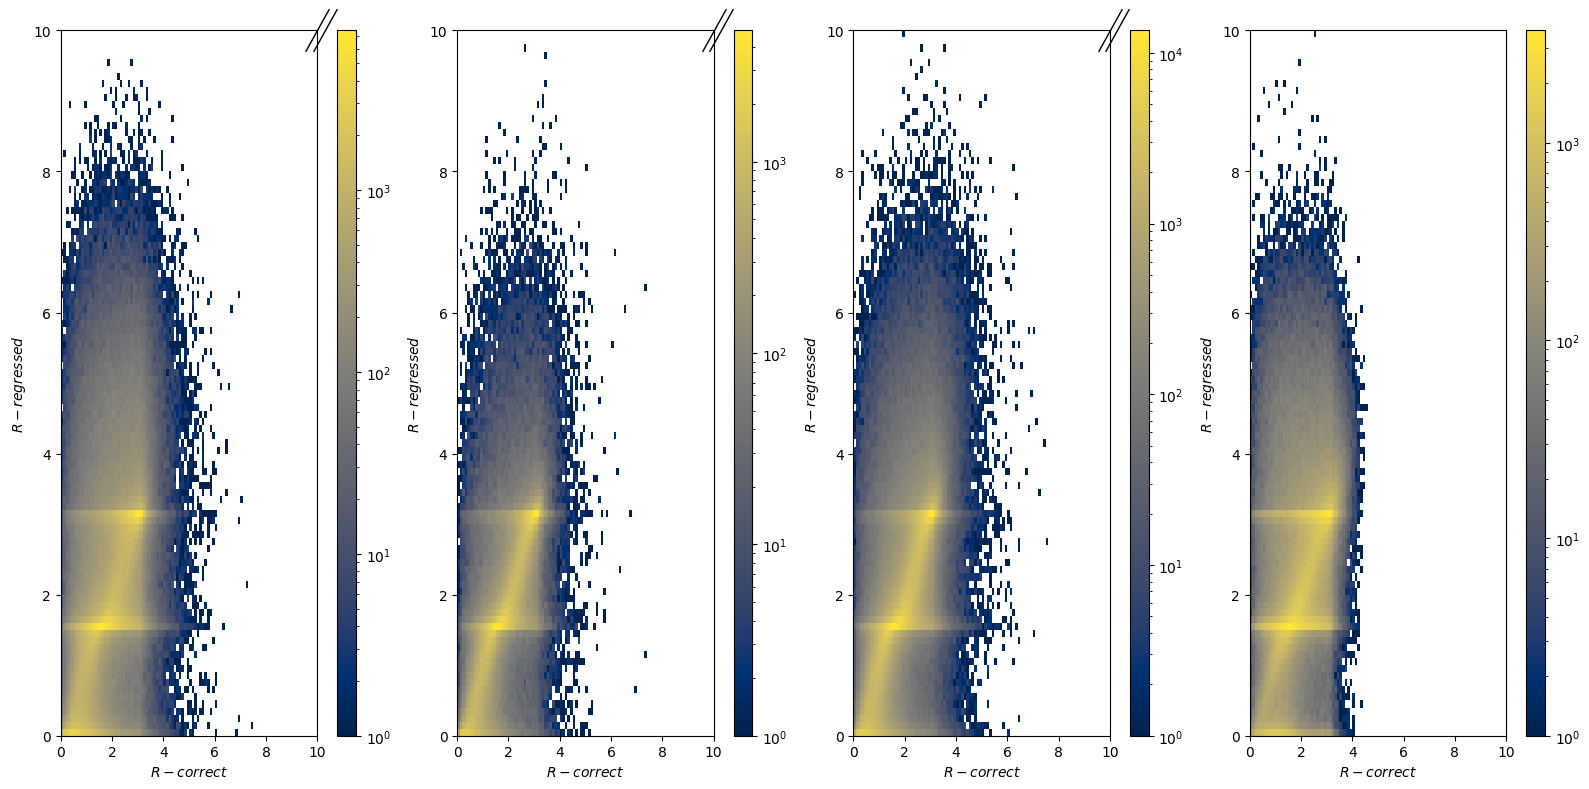

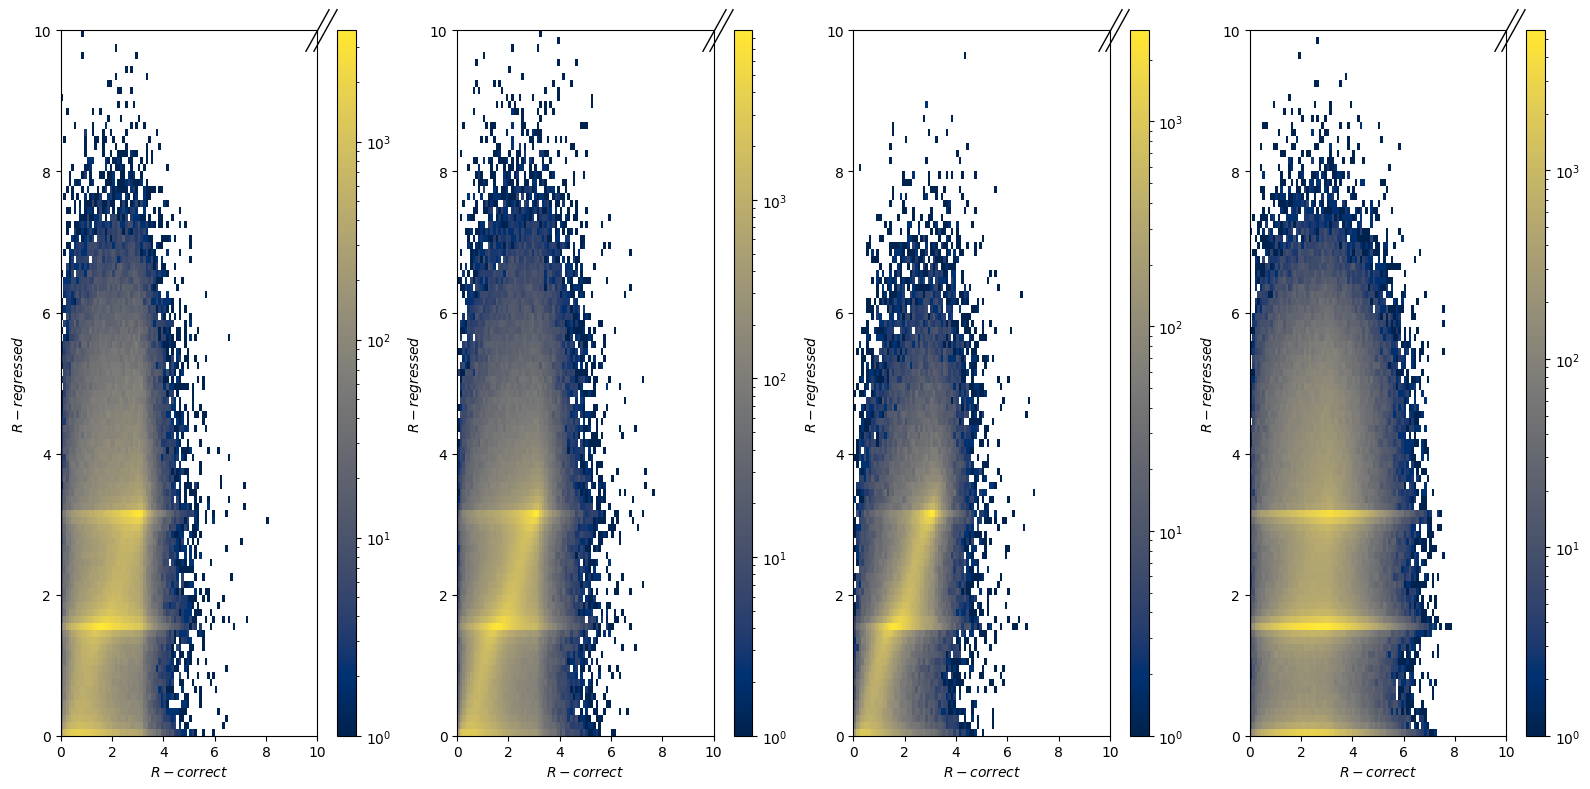

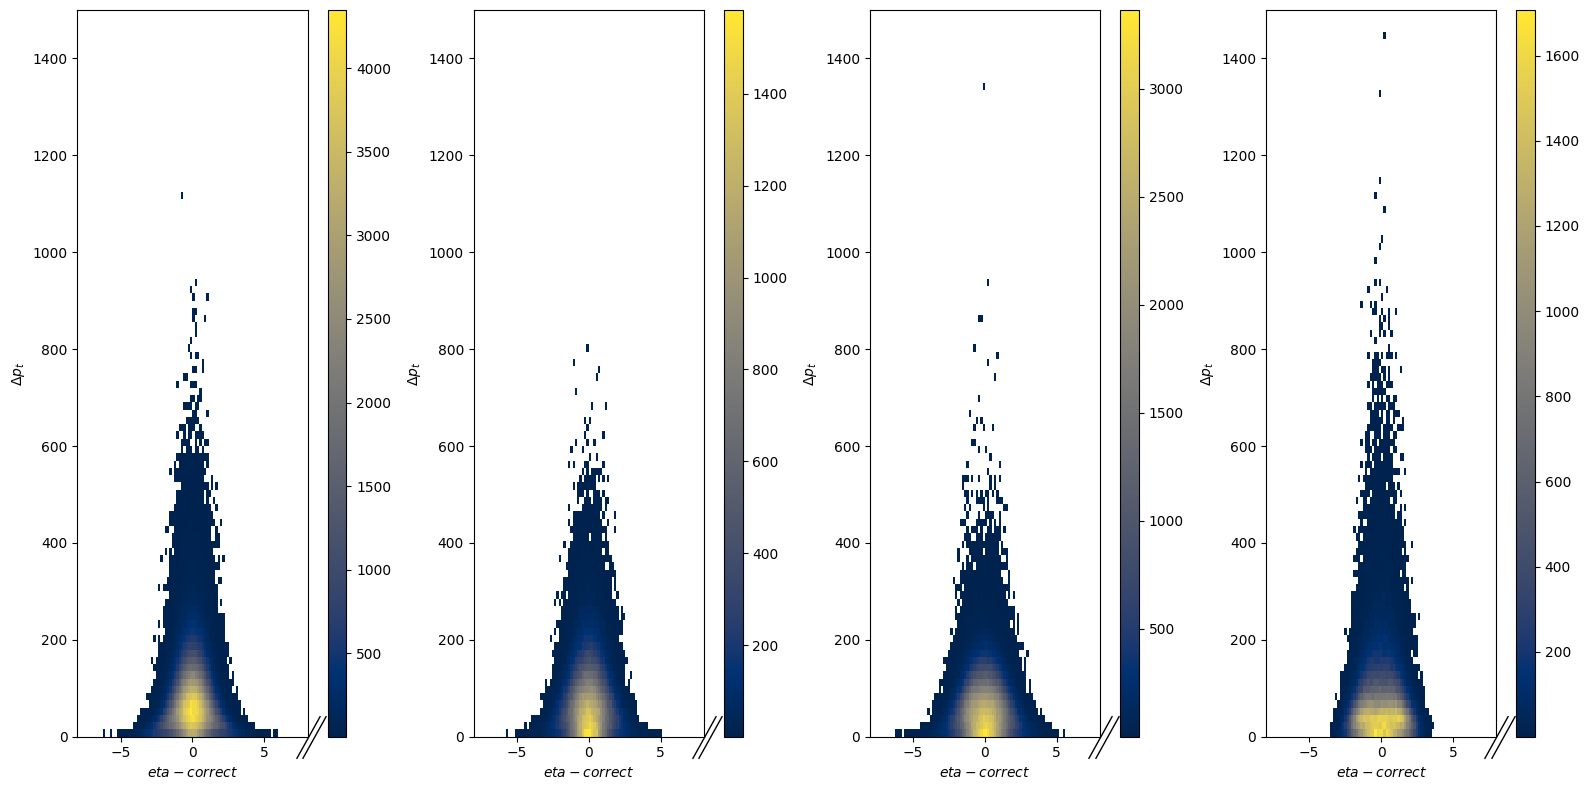

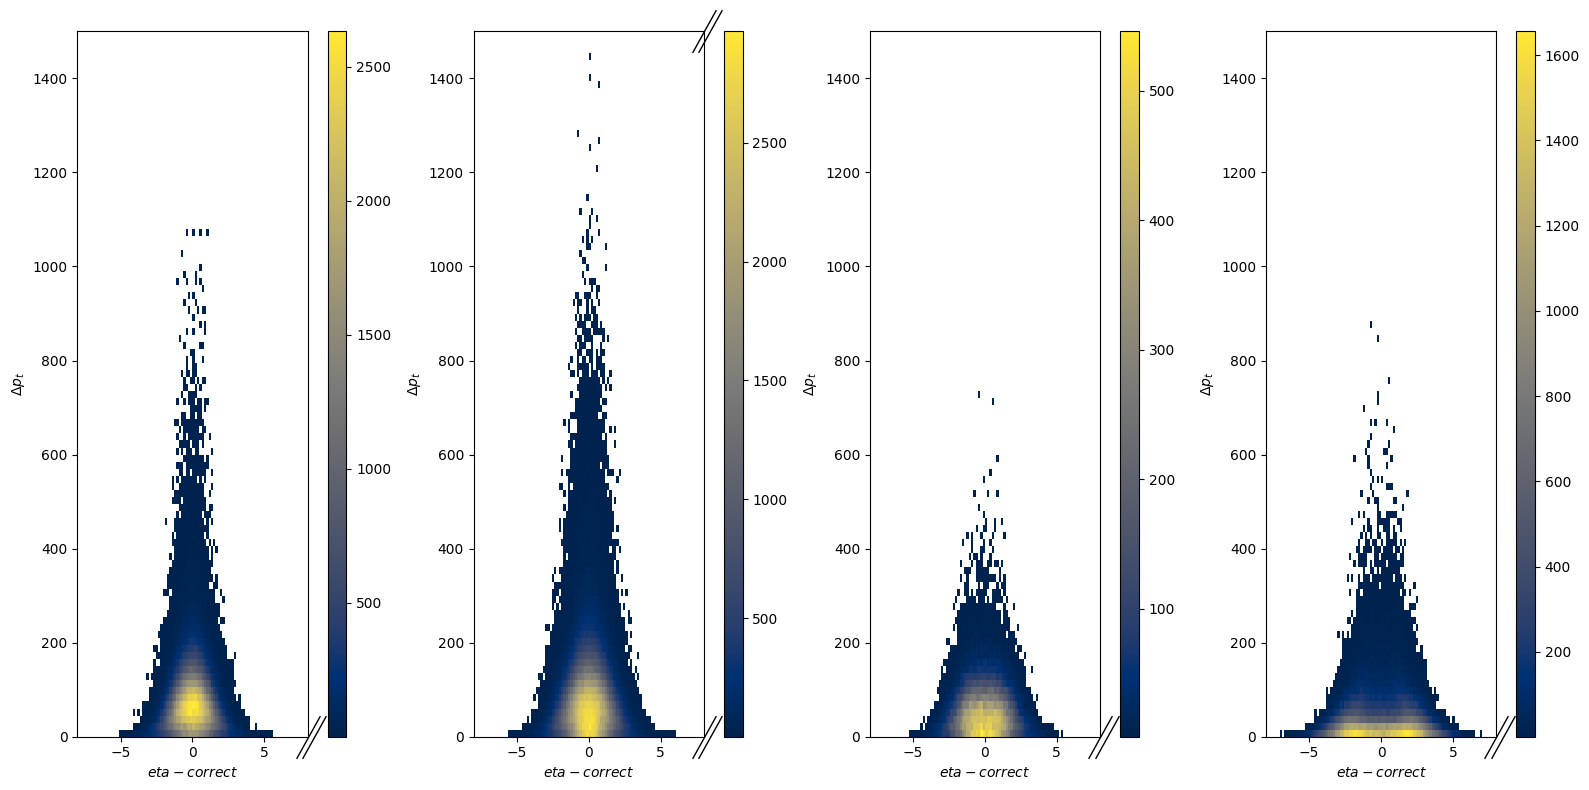

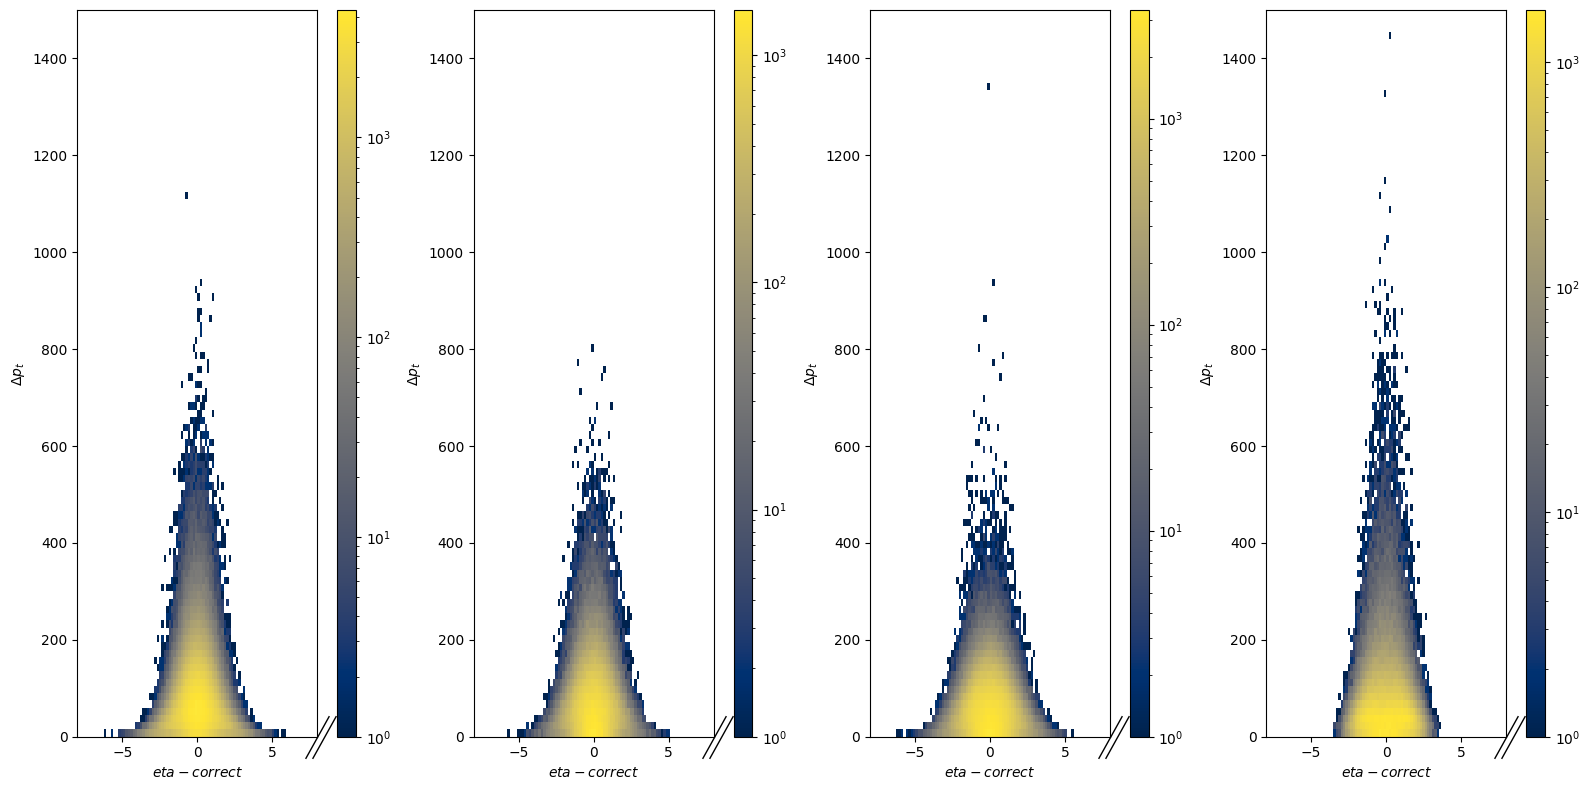

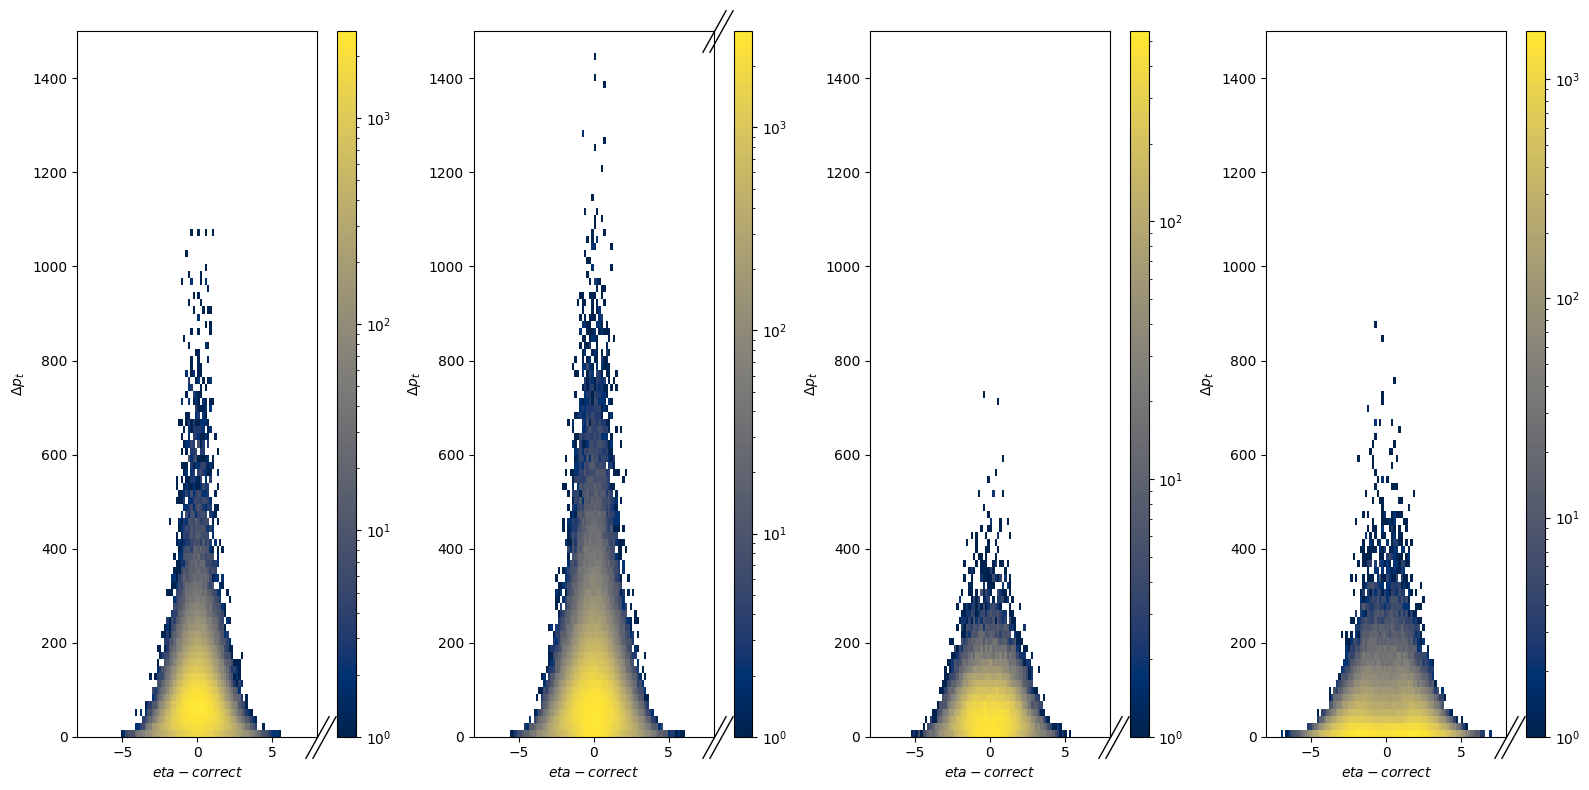

In [22]:
# R
higgsCorR = np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2)
higgsR = np.sqrt(higgs.phi**2 + higgs.eta**2)

thadCorR = np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2)
thadR = np.sqrt(thad.phi**2 + thad.eta**2)

tlepCorR = np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2)
tlepR = np.sqrt(tlep.phi**2 + tlep.eta**2)

ISRCor_R = np.sqrt(glISRCorrect.phi**2 + glISRCorrect.eta**2)
ISR_R = np.sqrt(glISR.phi**2 + glISR.eta**2)

plots.plot_var2d(higgs_var1=higgsCorR, higgs_var2=higgsR,
           thad_var1=thadCorR, thad_var2=thadR,
           tlep_var1=tlepCorR, tlep_var2=tlepR,
           ISR_var1=ISRCor_R, ISR_var2=ISR_R,
           name1='$R-correct$', name2='$R-regressed$', nameFig='41.png', 
           start1=0, stop1=10, start2=0, stop2=10, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorR, higgs_var2=higgsR,
           thad_var1=thadCorR, thad_var2=thadR,
           tlep_var1=tlepCorR, tlep_var2=tlepR,
           ISR_var1=ISRCor_R, ISR_var2=ISR_R,
           name1='$R-correct$', name2='$R-regressed$', nameFig='42.png', 
           start1=0, stop1=10, start2=0, stop2=10, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

plots.plot_var2d(higgs_var1=higgsCorR, higgs_var2=higgsR,
           thad_var1=thadCorR, thad_var2=thadR,
           tlep_var1=tlepCorR, tlep_var2=tlepR,
           ISR_var1=ISRCor_R, ISR_var2=ISR_R,
           name1='$R-correct$', name2='$R-regressed$', nameFig='43.png', 
           start1=0, stop1=10, start2=0, stop2=10, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=True)

plots.plot_var2d(higgs_var1=higgsCorR, higgs_var2=higgsR,
           thad_var1=thadCorR, thad_var2=thadR,
           tlep_var1=tlepCorR, tlep_var2=tlepR,
           ISR_var1=ISRCor_R, ISR_var2=ISR_R,
           name1='$R-correct$', name2='$R-regressed$', nameFig='44.png', 
           start1=0, stop1=10, start2=0, stop2=10, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=True)


# eta vs DiffPt
higgs_DiffPt = higgsCorrect.pt - higgs.pt
thad_DiffPt = thadCorrect.pt - thad.pt
tlep_DiffPt = tlepCorrect.pt - tlep.pt
glISR_DiffPt = glISRCorrect.pt - glISR.pt

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffPt,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffPt,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffPt,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffPt,
           name1='$eta-correct$', name2='$\Delta p_t$', nameFig='45.png', 
           start1=-8, stop1=8, start2=0, stop2=1500, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffPt,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffPt,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffPt,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffPt,
           name1='$eta-correct$', name2='$\Delta p_t$', nameFig='46.png', 
           start1=-8, stop1=8, start2=0, stop2=1500, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffPt,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffPt,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffPt,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffPt,
           name1='$eta-correct$', name2='$\Delta p_t$', nameFig='47.png', 
           start1=-8, stop1=8, start2=0, stop2=1500, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=True)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffPt,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffPt,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffPt,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffPt,
           name1='$eta-correct$', name2='$\Delta p_t$', nameFig='48.png', 
           start1=-8, stop1=8, start2=0, stop2=1500, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=True)



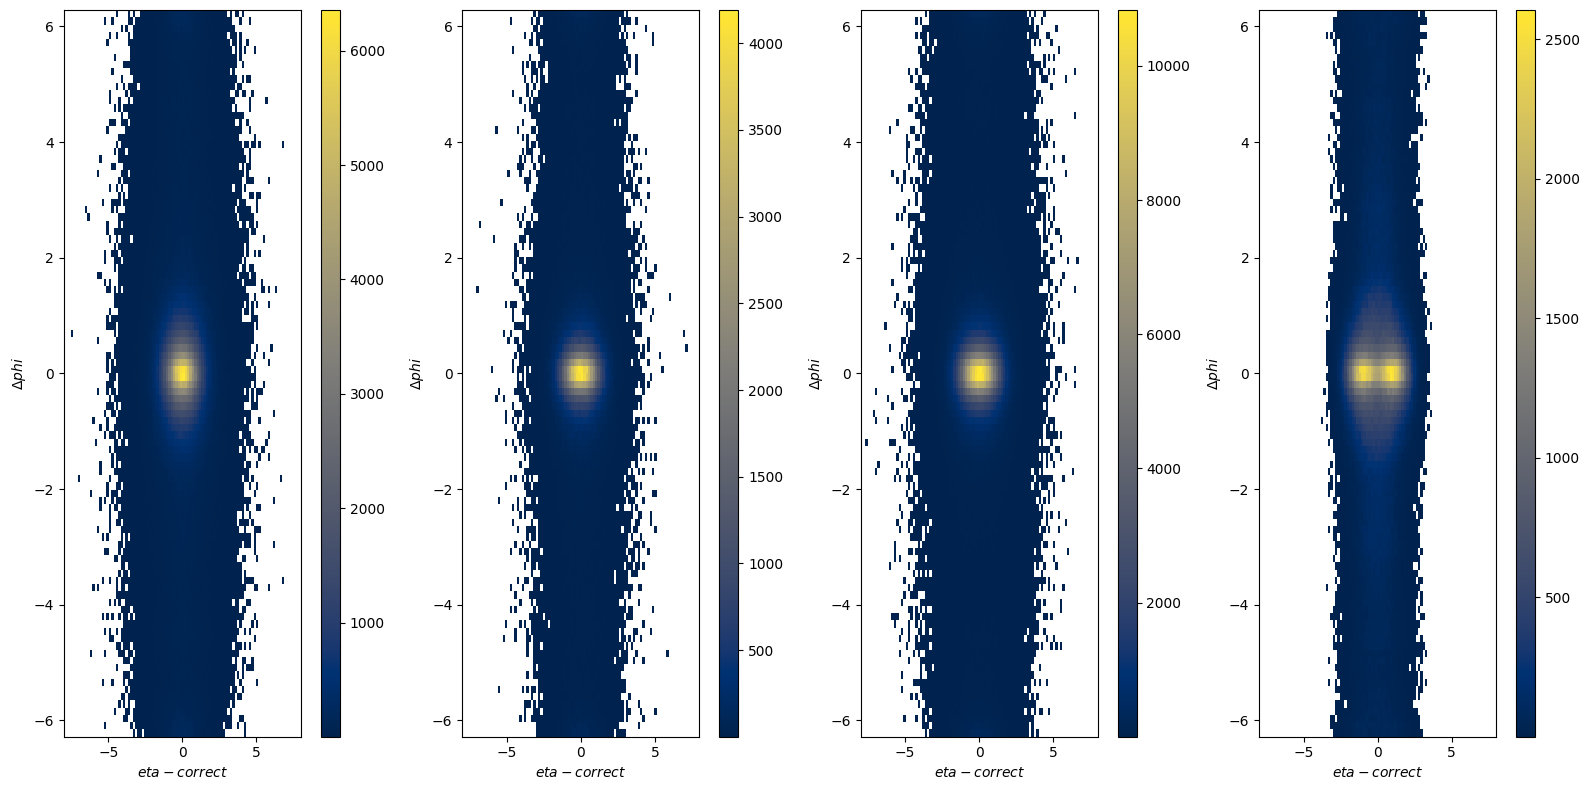

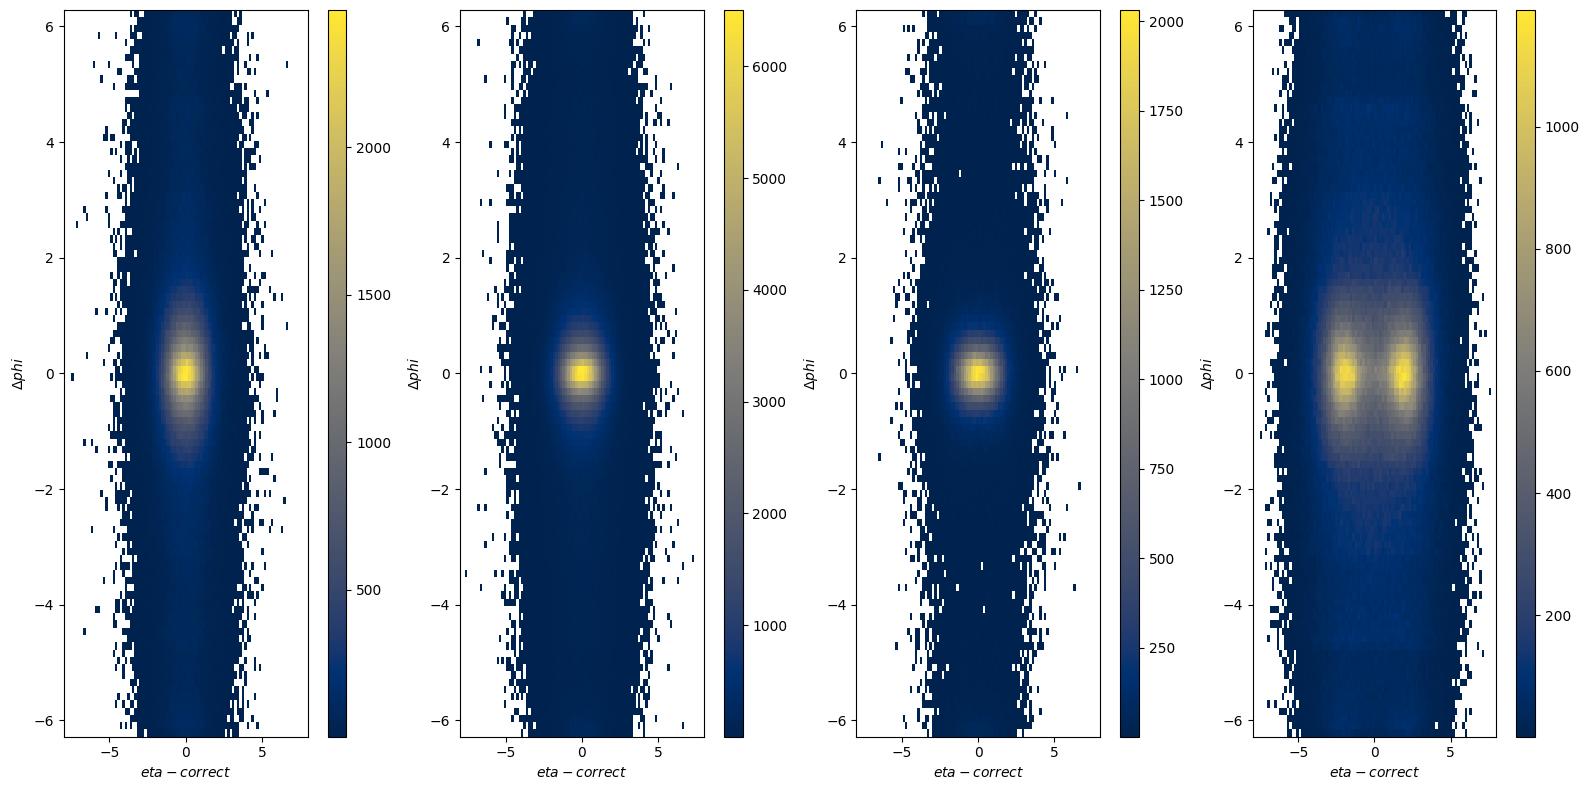

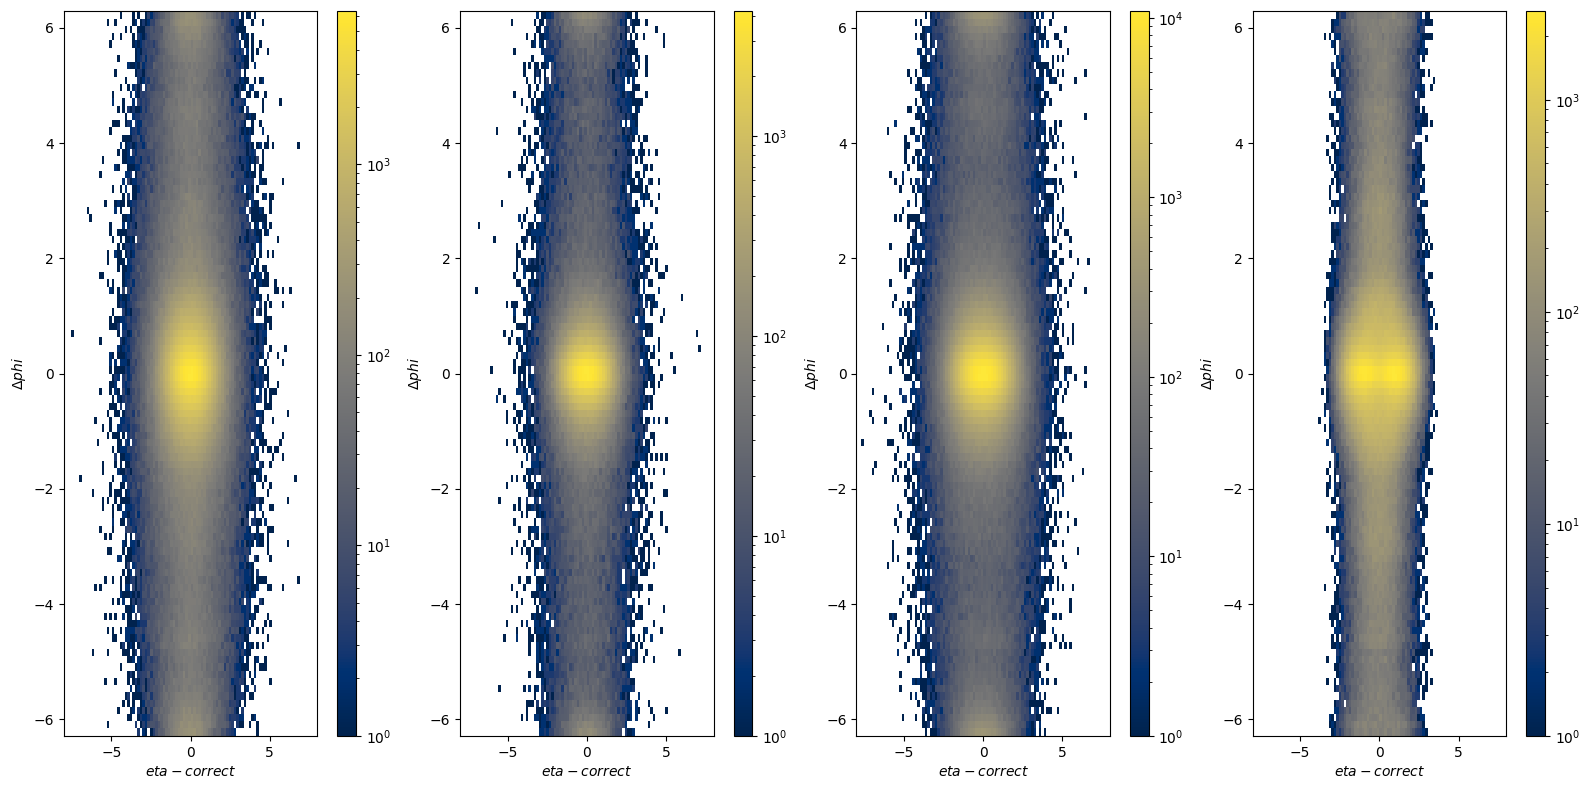

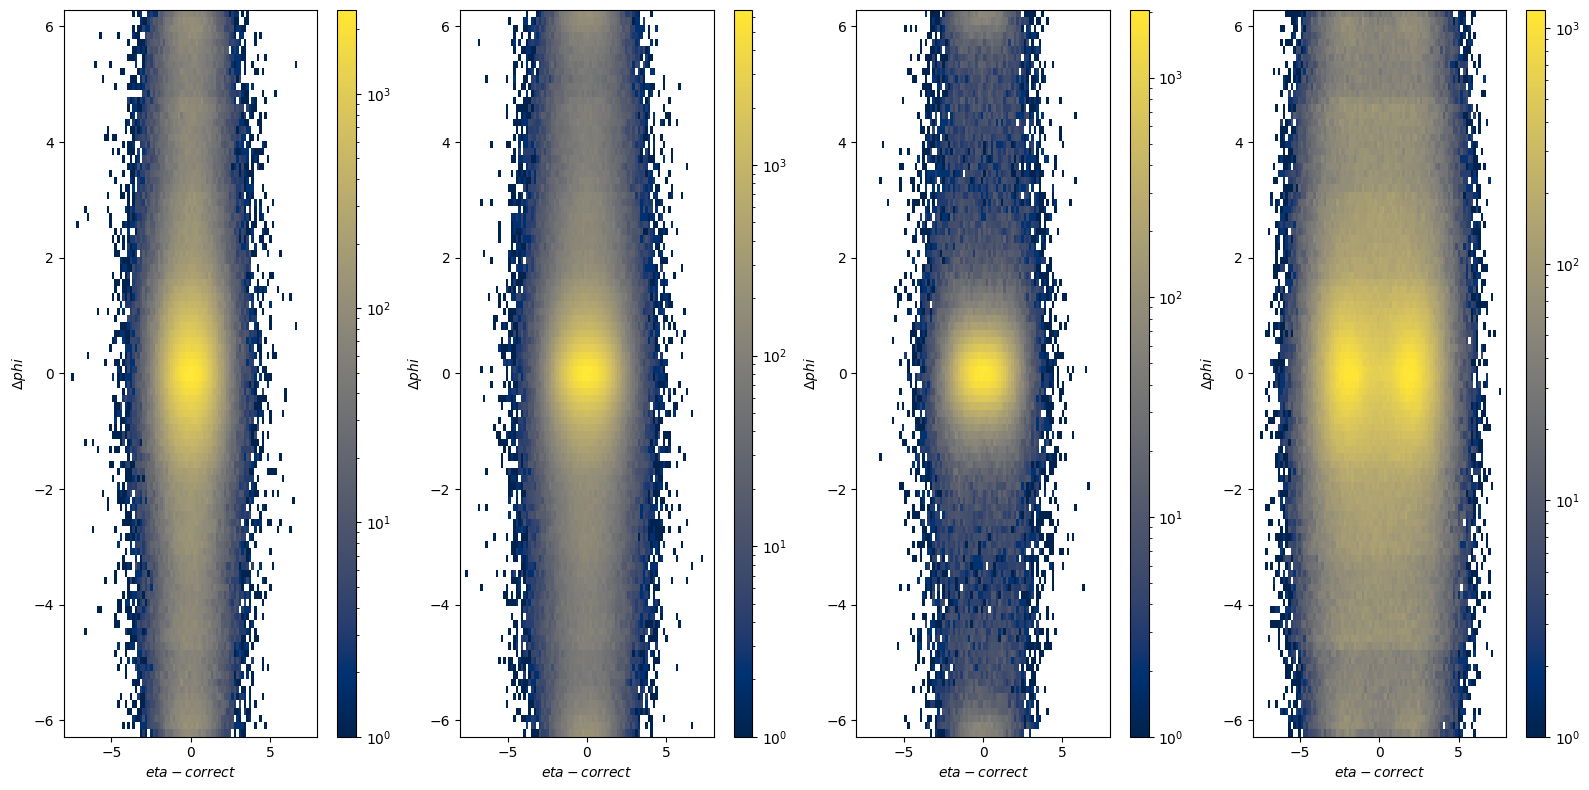

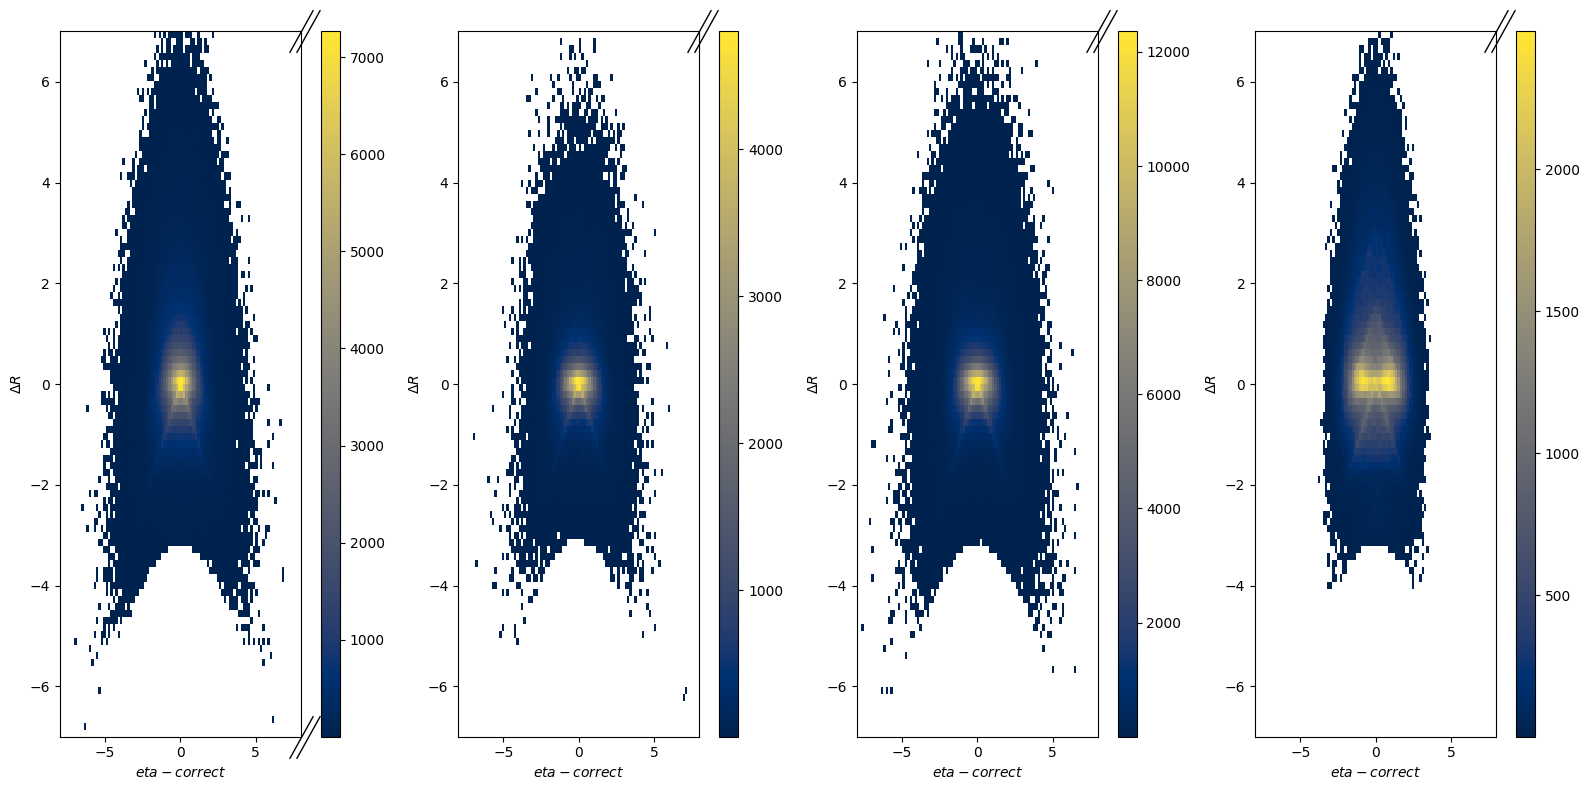

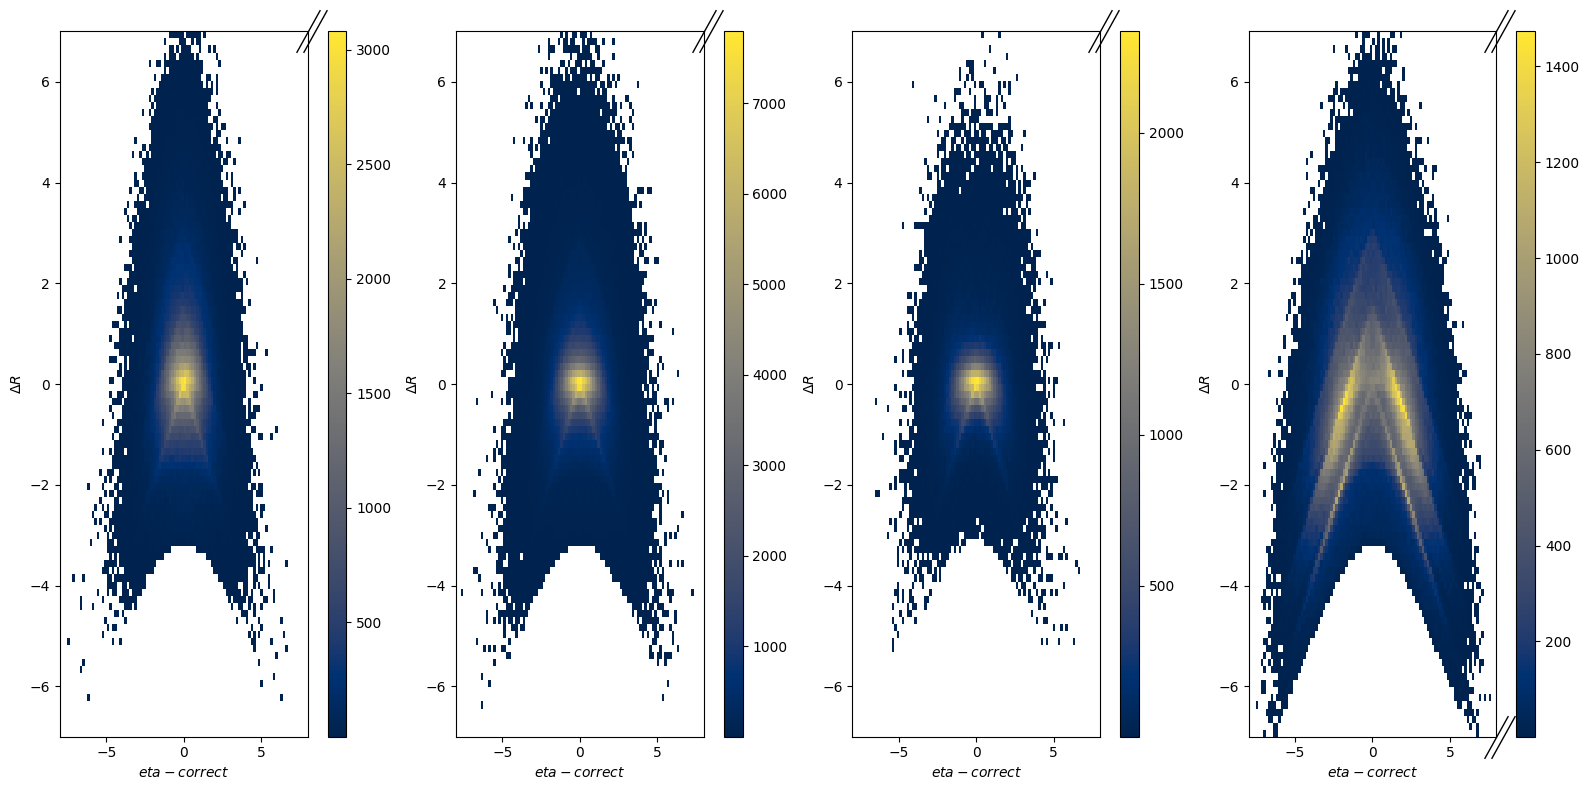

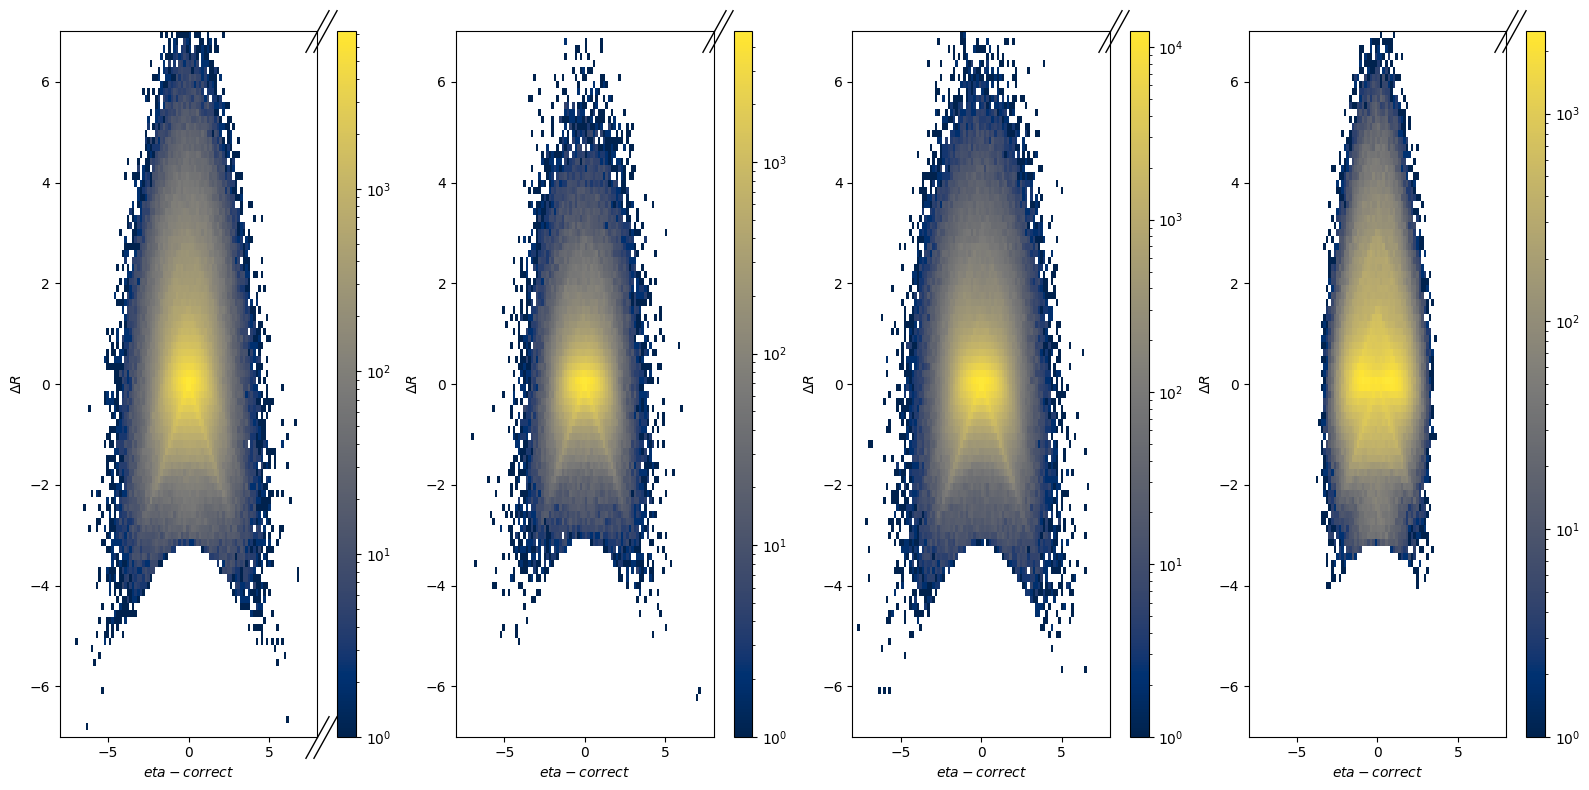

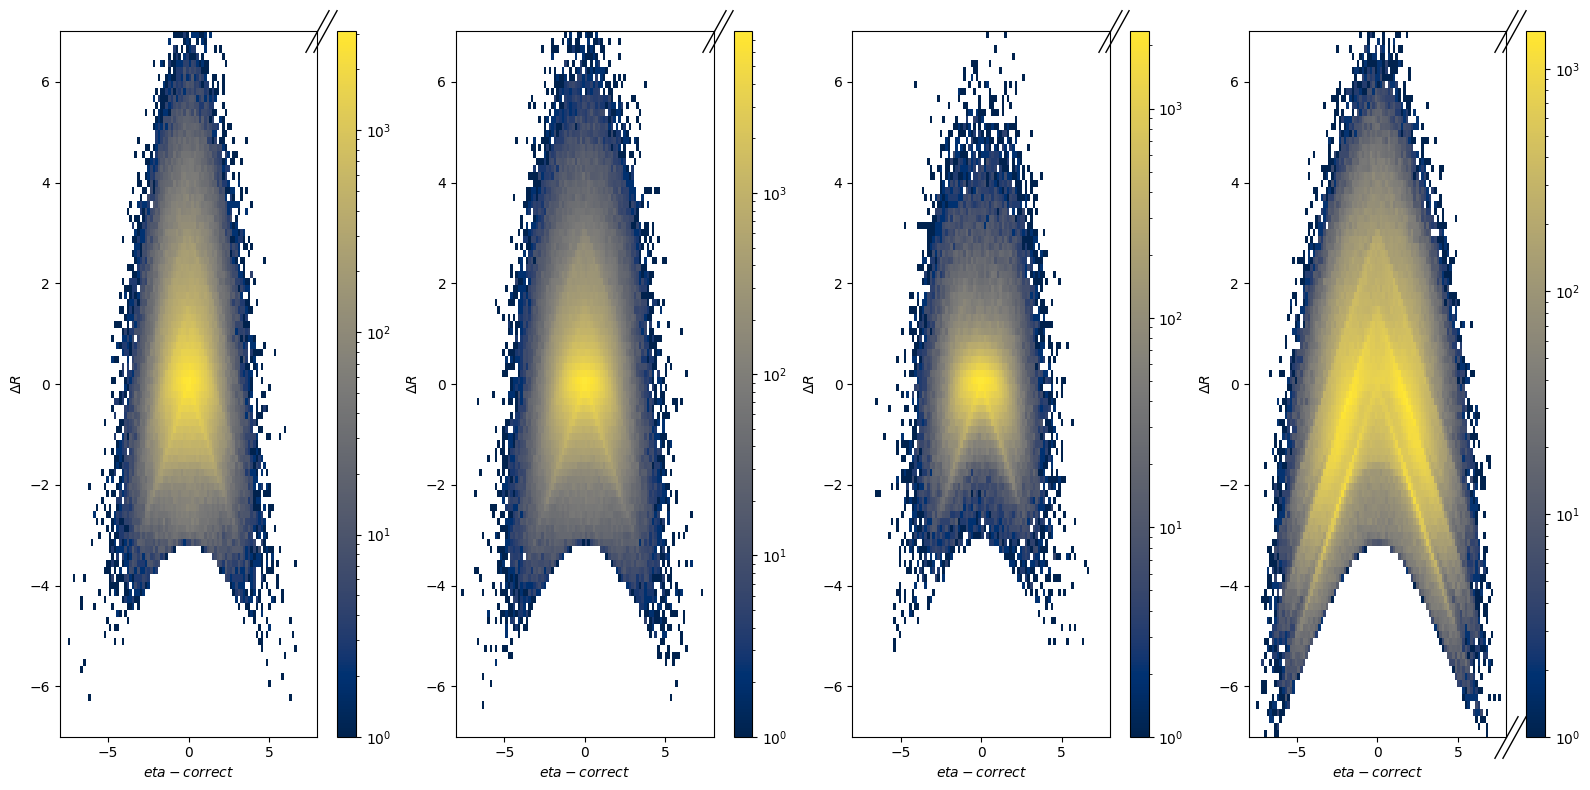

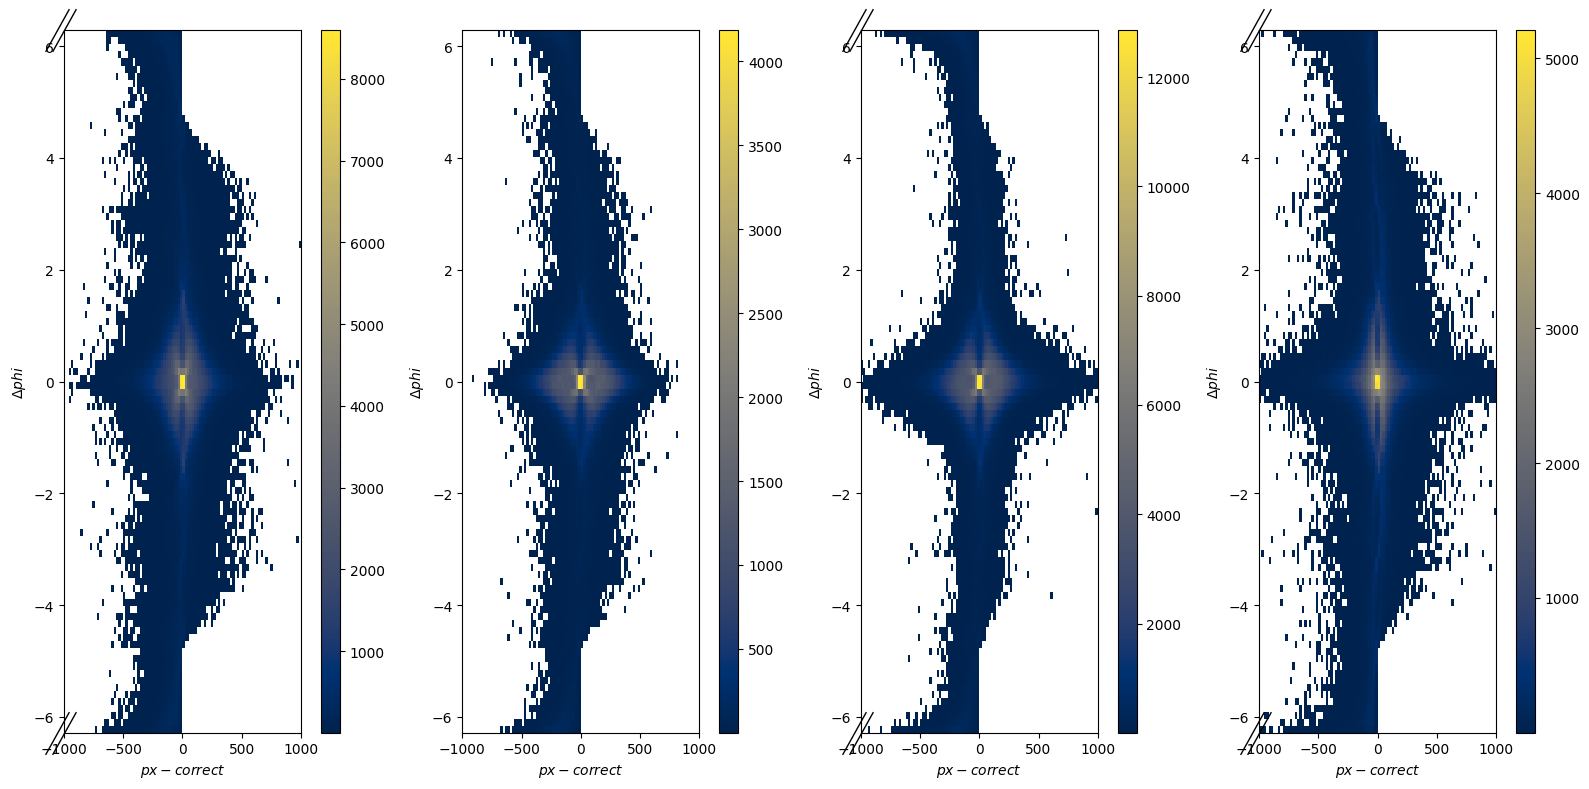

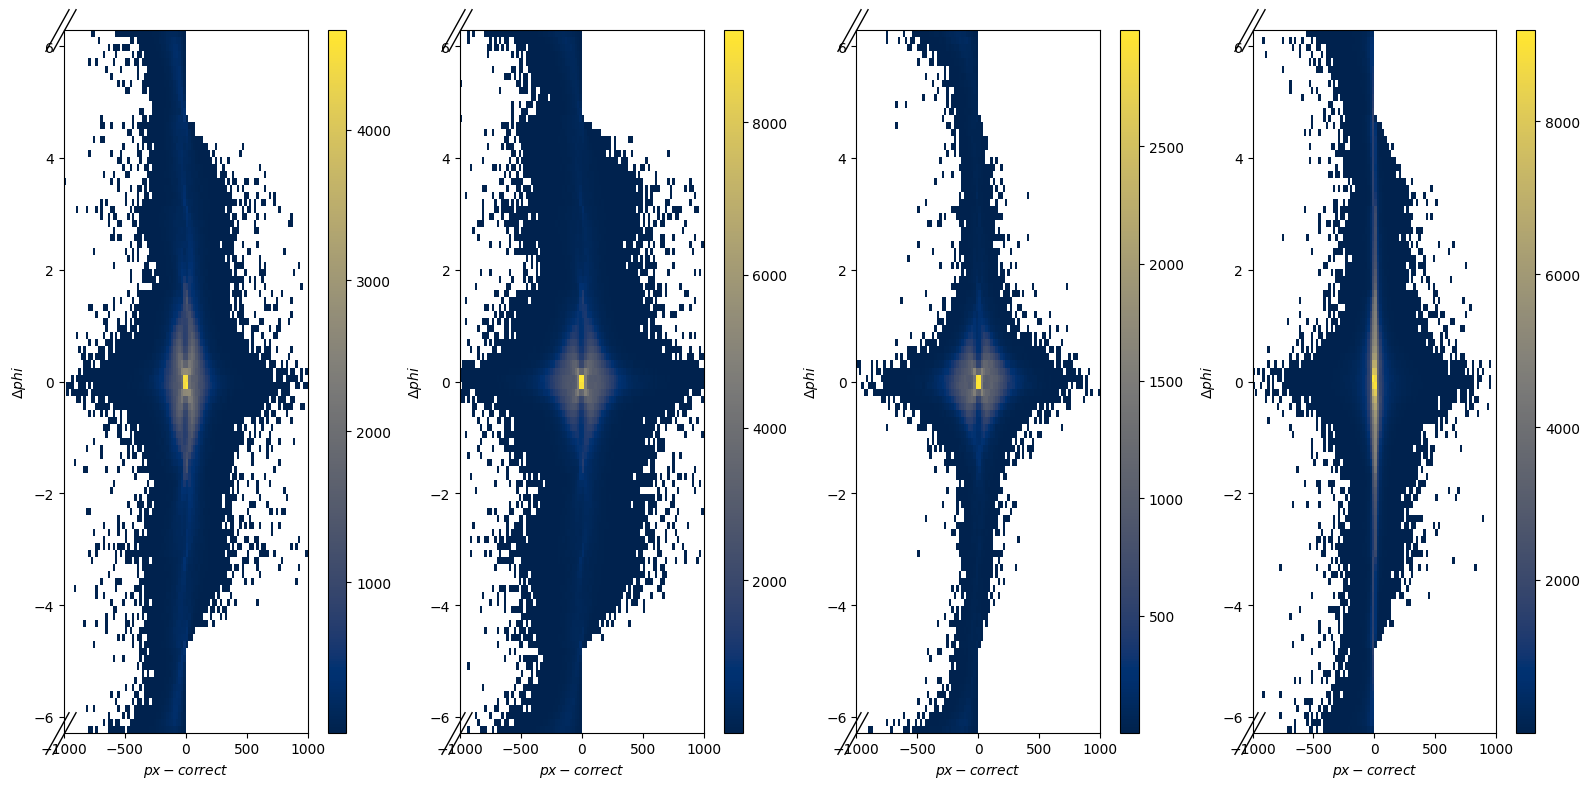

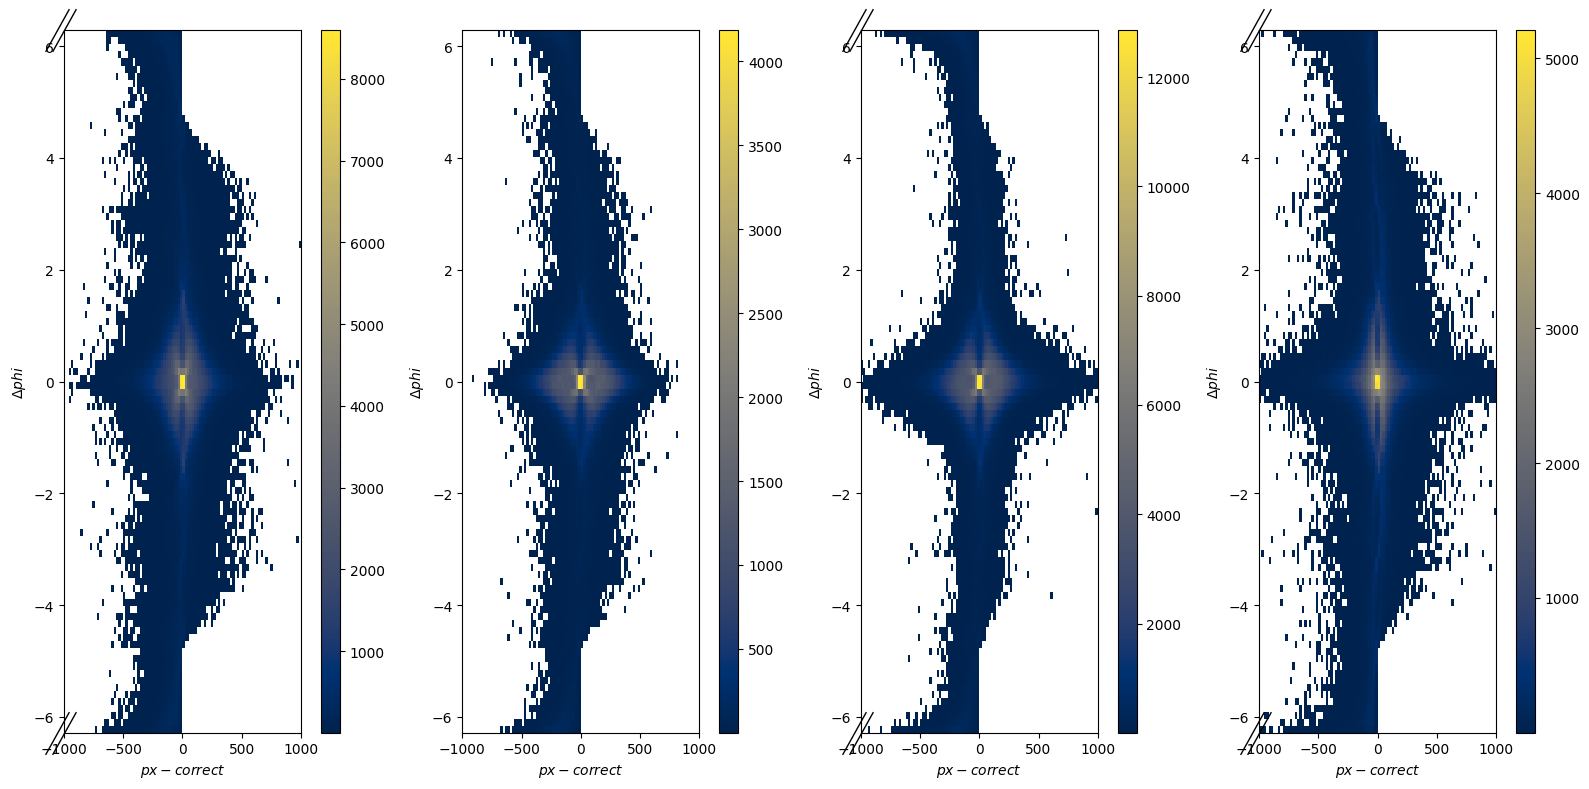

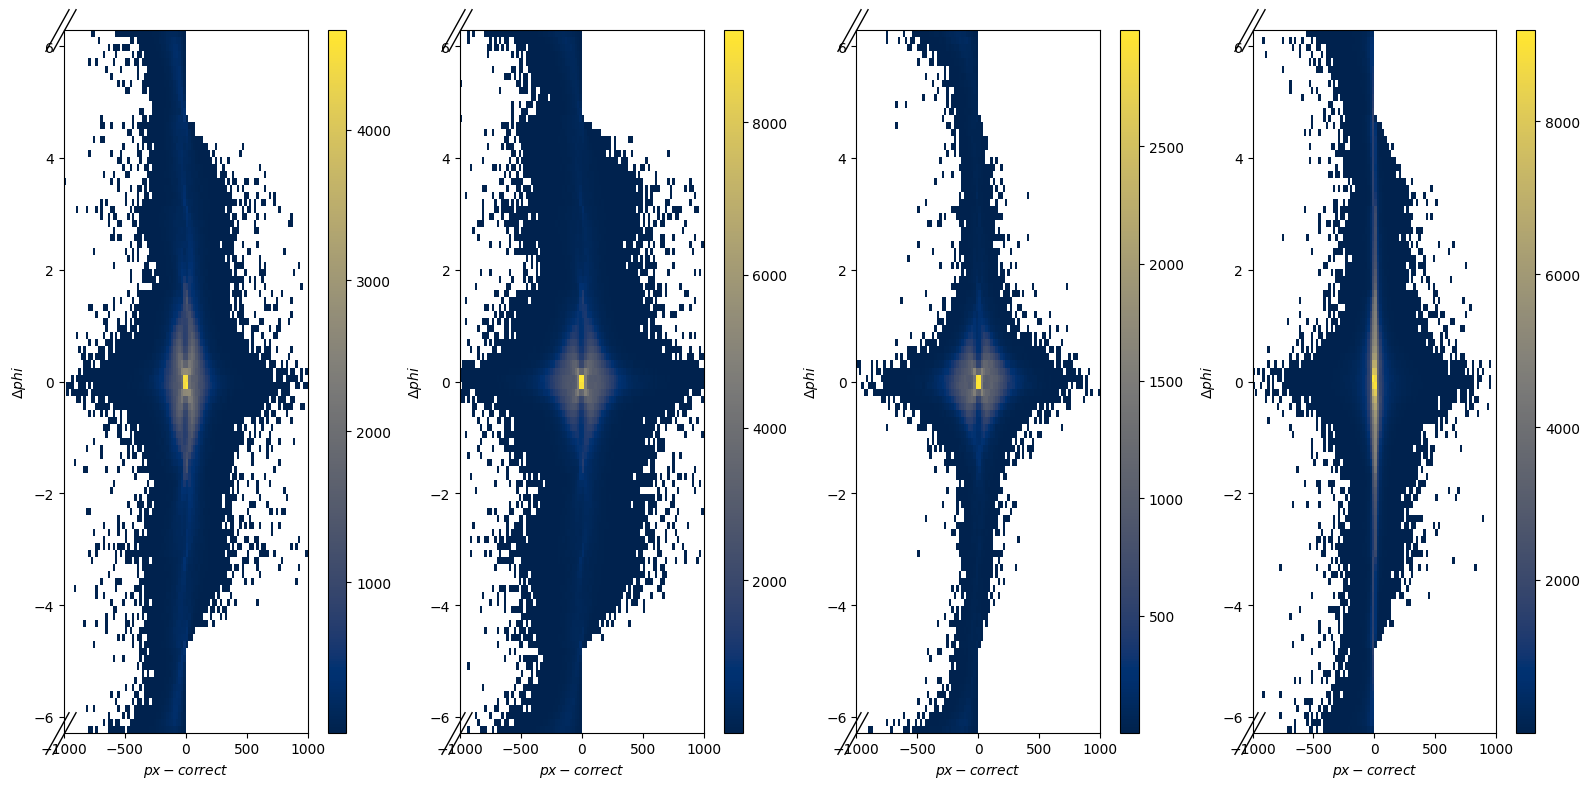

In [23]:
#eta vs diff_phi
higgs_DiffPhi = higgsCorrect.phi - higgs.phi
thad_DiffPhi = thadCorrect.phi - thad.phi
tlep_DiffPhi = tlepCorrect.phi - tlep.phi
glISR_DiffPhi = glISRCorrect.phi - glISR.phi

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffPhi,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffPhi,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffPhi,
           name1='$eta-correct$', name2='$\Delta phi$', nameFig='49.png', 
           start1=-8, stop1=8, start2=-2*pi, stop2=2*pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffPhi,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffPhi,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffPhi,
           name1='$eta-correct$', name2='$\Delta phi$', nameFig='50.png', 
           start1=-8, stop1=8, start2=-2*pi, stop2=2*pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffPhi,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffPhi,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffPhi,
           name1='$eta-correct$', name2='$\Delta phi$', nameFig='51.png', 
           start1=-8, stop1=8, start2=-2*pi, stop2=2*pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=True)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffPhi,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffPhi,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffPhi,
           name1='$eta-correct$', name2='$\Delta phi$', nameFig='52.png', 
           start1=-8, stop1=8, start2=-2*pi, stop2=2*pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=True)

# eta vs Diff_R
higgs_DiffR = np.sqrt(higgs.phi**2 + higgs.eta**2) -  np.sqrt(higgsCorrect.phi**2 + higgsCorrect.eta**2)
thad_DiffR = np.sqrt(thad.phi**2 + thad.eta**2) -  np.sqrt(thadCorrect.phi**2 + thadCorrect.eta**2)
tlep_DiffR = np.sqrt(tlep.phi**2 + tlep.eta**2) -  np.sqrt(tlepCorrect.phi**2 + tlepCorrect.eta**2)
glISR_DiffR = np.sqrt(glISR.phi**2 + glISR.eta**2) -  np.sqrt(glISRCorrect.phi**2 + glISRCorrect.eta**2)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffR,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffR,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffR,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffR,
           name1='$eta-correct$', name2='$\Delta R$', nameFig='53.png', 
           start1=-8, stop1=8, start2=-7, stop2=7, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffR,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffR,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffR,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffR,
           name1='$eta-correct$', name2='$\Delta R$', nameFig='54.png', 
           start1=-8, stop1=8, start2=-7, stop2=7, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffR,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffR,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffR,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffR,
           name1='$eta-correct$', name2='$\Delta R$', nameFig='55.png', 
           start1=-8, stop1=8, start2=-7, stop2=7, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=True)

plots.plot_var2d(higgs_var1=higgsCorrect.eta, higgs_var2=higgs_DiffR,
           thad_var1=thadCorrect.eta, thad_var2=thad_DiffR,
           tlep_var1=tlepCorrect.eta, tlep_var2=tlep_DiffR,
           ISR_var1=glISRCorrect.eta, ISR_var2=glISR_DiffR,
           name1='$eta-correct$', name2='$\Delta R$', nameFig='56.png', 
           start1=-8, stop1=8, start2=-7, stop2=7, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=True)

#px vs diff_phi

plots.plot_var2d(higgs_var1=higgsCorrect.px, higgs_var2=higgs_DiffPhi,
           thad_var1=thadCorrect.px, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorrect.px, tlep_var2=tlep_DiffPhi,
           ISR_var1=glISRCorrect.px, ISR_var2=glISR_DiffPhi,
           name1='$px-correct$', name2='$\Delta phi$', nameFig='57.png', 
           start1=-1000, stop1=1000, start2=-2*pi, stop2=2*pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.px, higgs_var2=higgs_DiffPhi,
           thad_var1=thadCorrect.px, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorrect.px, tlep_var2=tlep_DiffPhi,
           ISR_var1=glISRCorrect.px, ISR_var2=glISR_DiffPhi,
           name1='$px-correct$', name2='$\Delta phi$', nameFig='58.png', 
           start1=-1000, stop1=1000, start2=-2*pi, stop2=2*pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.px, higgs_var2=higgs_DiffPhi,
           thad_var1=thadCorrect.px, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorrect.px, tlep_var2=tlep_DiffPhi,
           ISR_var1=glISRCorrect.px, ISR_var2=glISR_DiffPhi,
           name1='$px-correct$', name2='$\Delta phi$', nameFig='59.png', 
           start1=-1000, stop1=1000, start2=-2*pi, stop2=2*pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=False, log=False)

plots.plot_var2d(higgs_var1=higgsCorrect.px, higgs_var2=higgs_DiffPhi,
           thad_var1=thadCorrect.px, thad_var2=thad_DiffPhi,
           tlep_var1=tlepCorrect.px, tlep_var2=tlep_DiffPhi,
           ISR_var1=glISRCorrect.px, ISR_var2=glISR_DiffPhi,
           name1='$px-correct$', name2='$\Delta phi$', nameFig='60.png', 
           start1=-1000, stop1=1000, start2=-2*pi, stop2=2*pi, bins1=100, bins2=100,
           higgs_mask=higgs_mask, thad_mask=thad_mask, tlep_mask=tlep_mask, ISR_mask=ISR_mask,
           neg_Mask=True, log=False)

# Rambo

In [24]:
data_phasespace = data.parton_data.phasespace_intermediateParticles
data_phasespaceDet = data.parton_data.phasespace_rambo_detjacobian
data_boostReco = data.reco_data.data_boost.squeeze(axis=1)

E_CM = 13000
phasespace = PhaseSpace(E_CM, [21, 21], [25, 6, -6, 21], dev="cpu")

# Using Boost from reco data

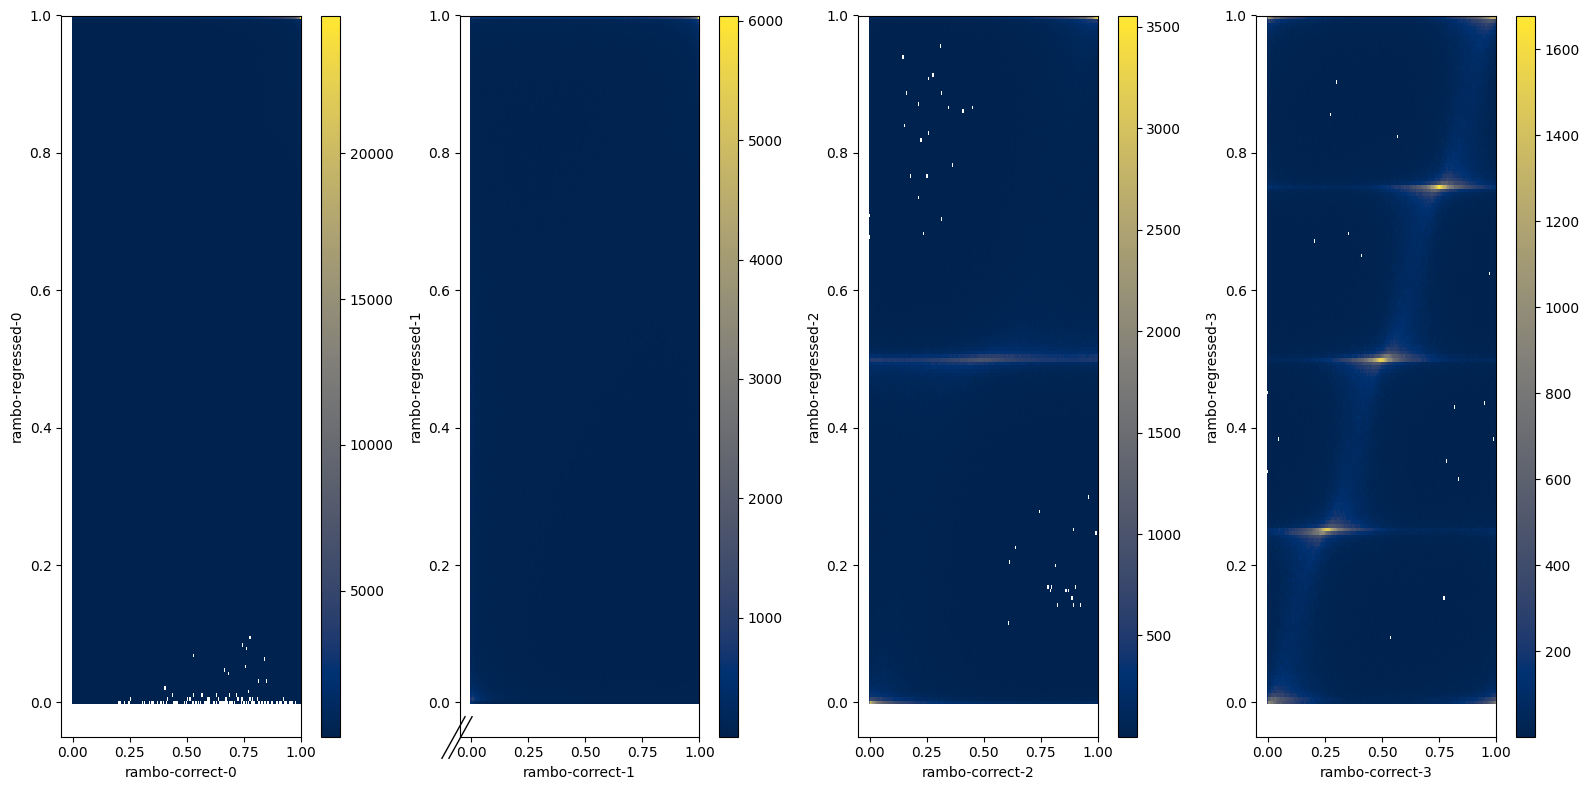

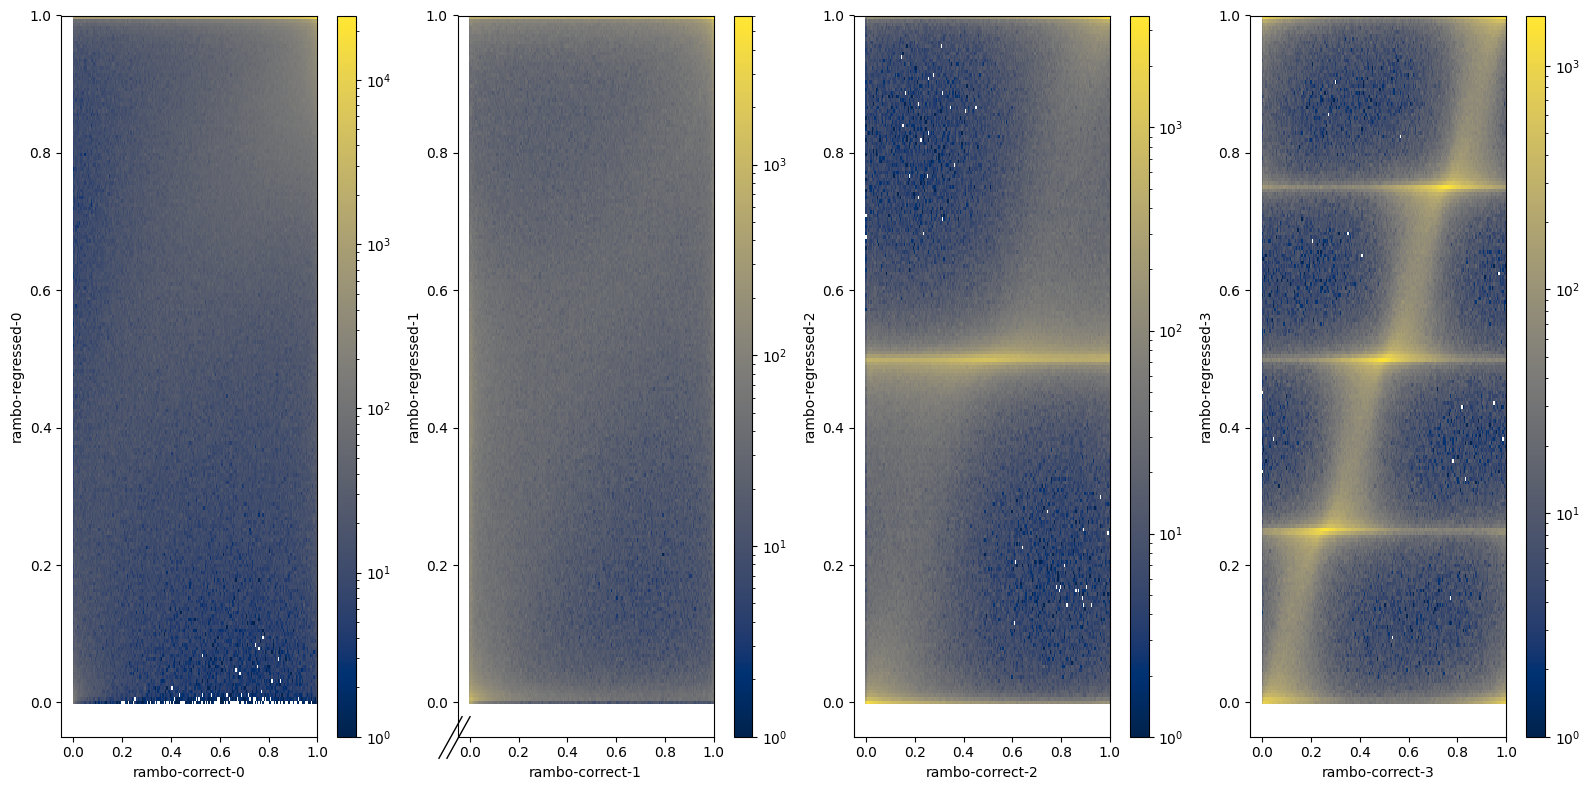

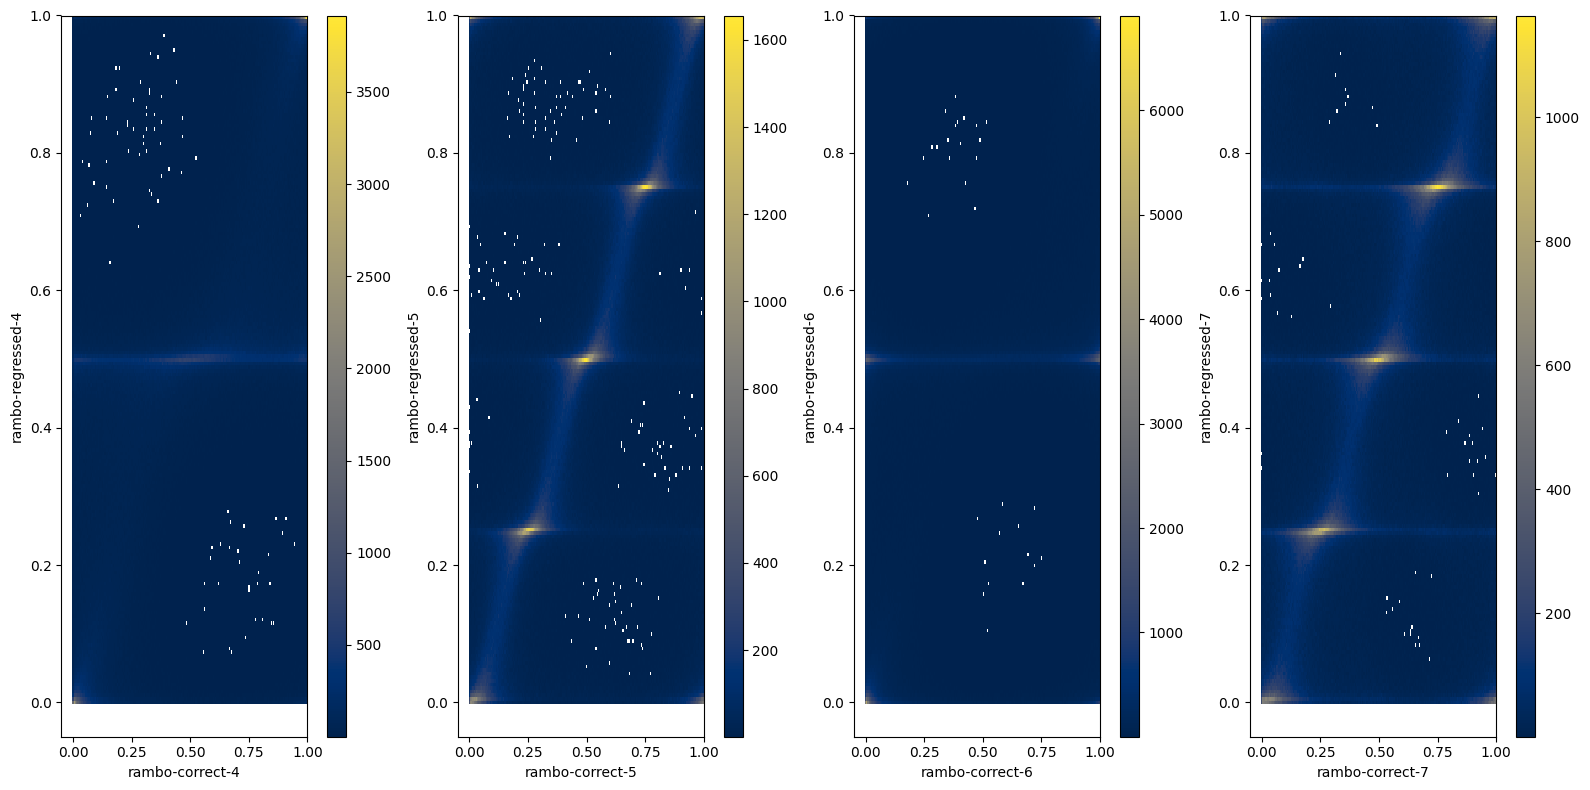

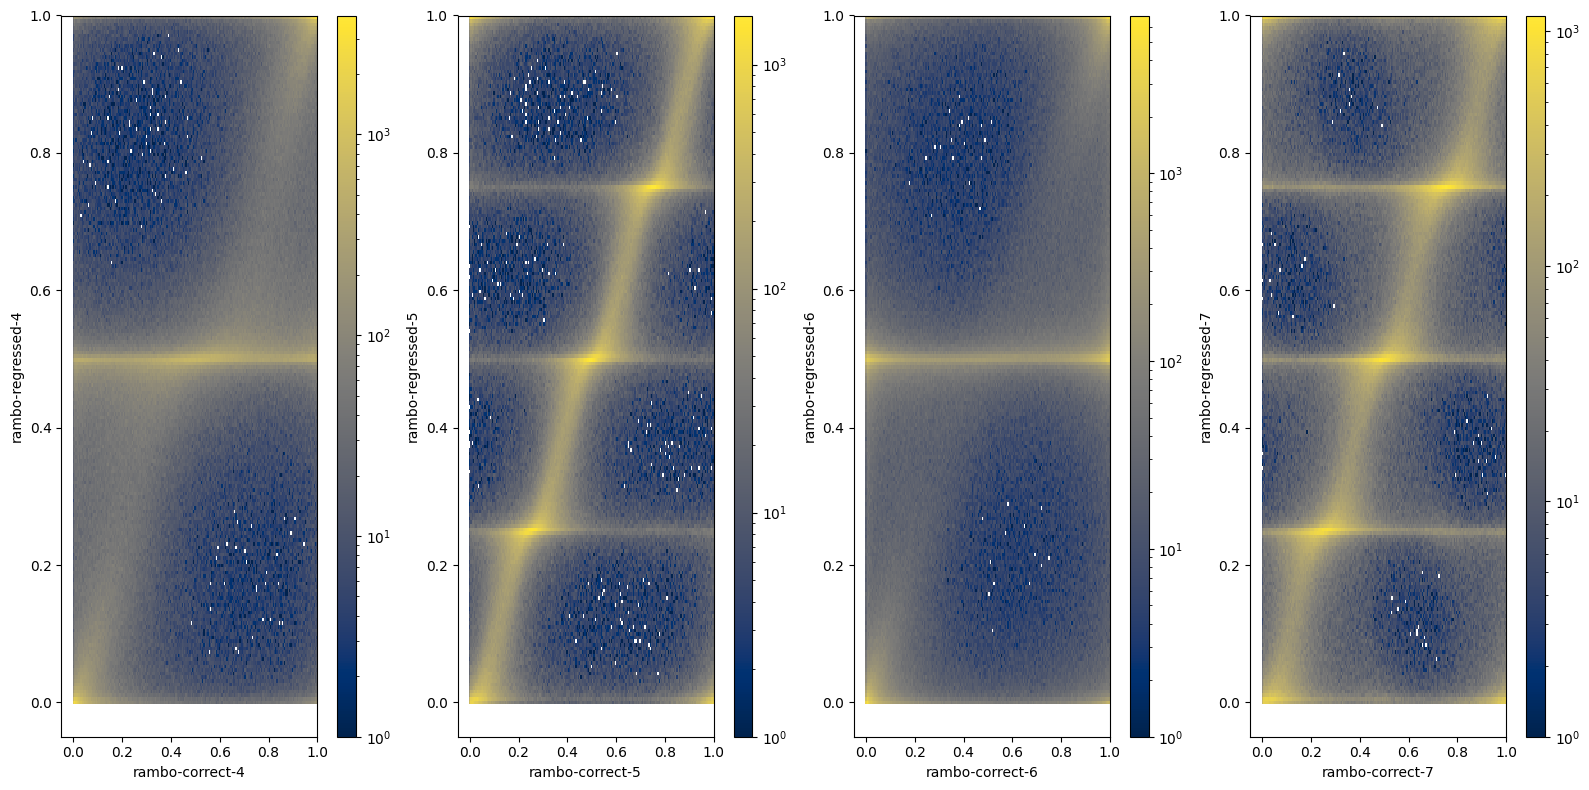

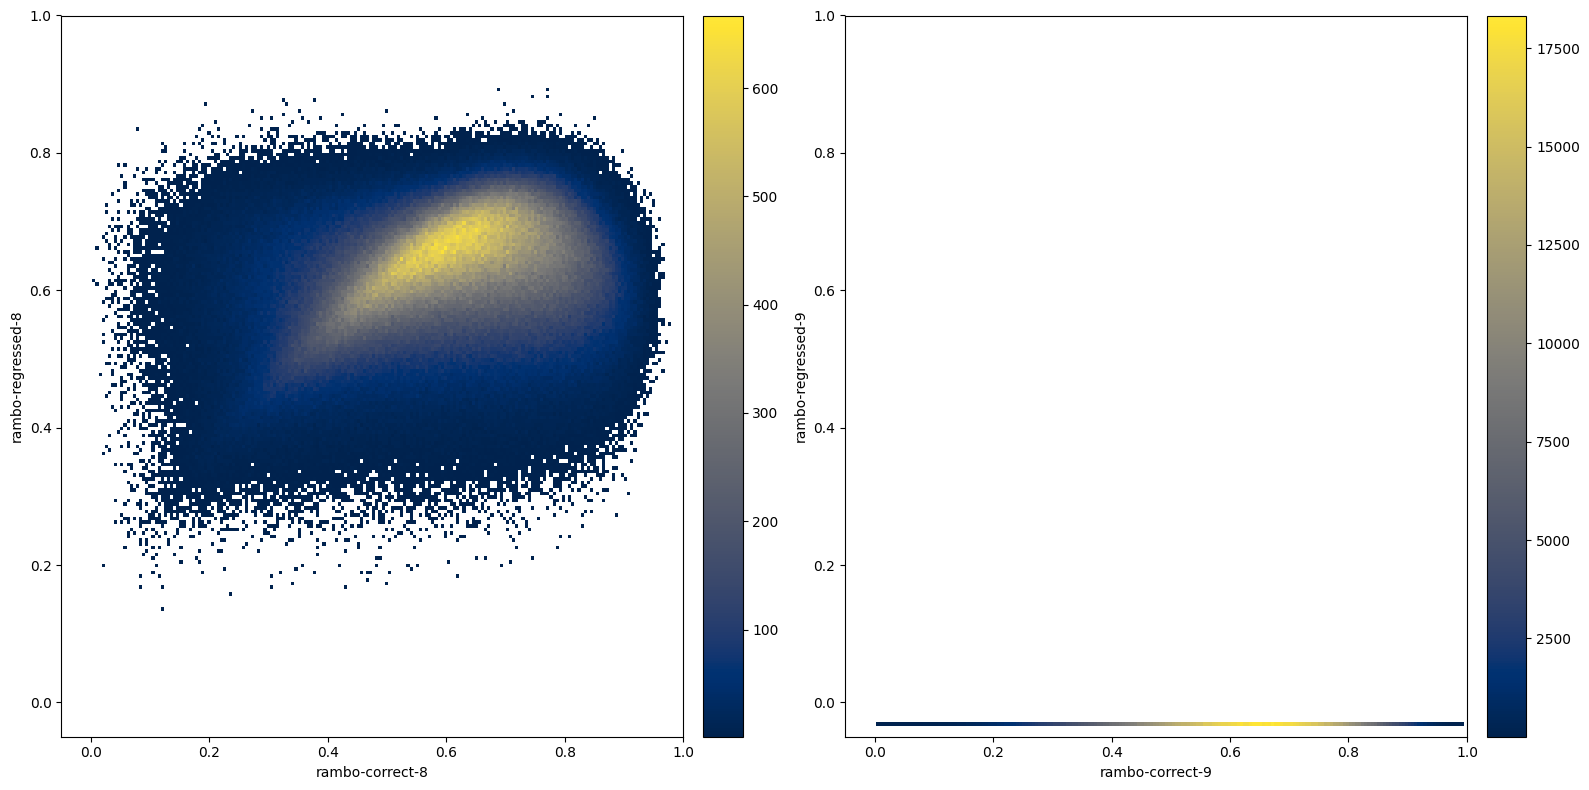

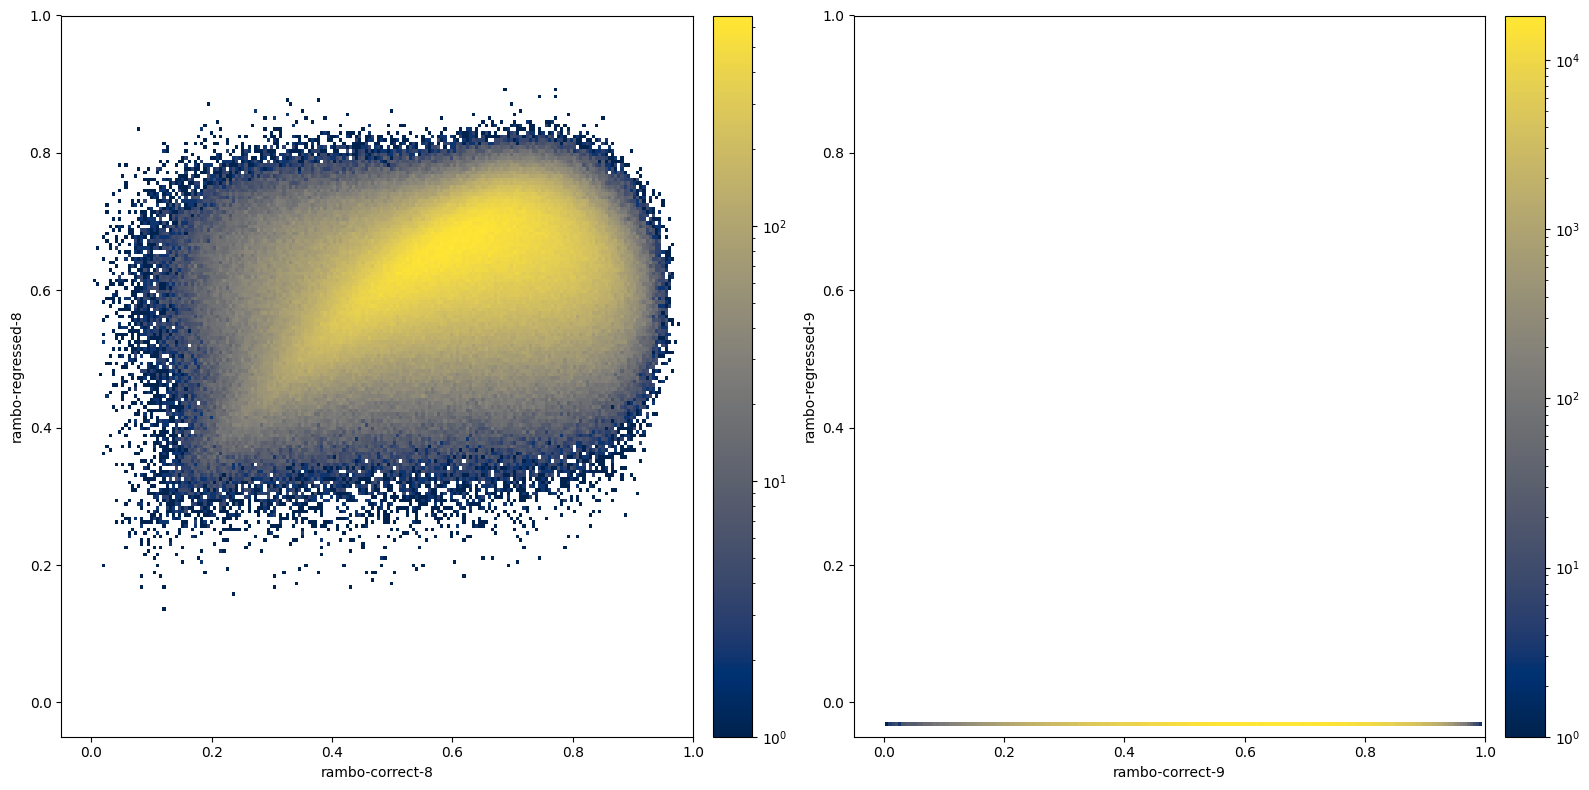

In [25]:
x1 = (data_boostReco[:, 0] + data_boostReco[:, 3]) / E_CM
x2 = (data_boostReco[:, 0] - data_boostReco[:, 3]) / E_CM
    
ps_regressed, detjinv_regressed = phasespace.get_ps_from_momenta(new_data_regressed, x1, x2, ensure_CM=True)
ps_regressed = torch.nan_to_num(ps_regressed, nan=-0.03)

for i in range(3):
        numberFig = 61+2*i
        plots.plot_rambo(data_phasespace.detach().numpy(), ps_regressed.detach().numpy(),
                         nameFig=f'{numberFig}.png', typePlot=i, log=False)
        
        plots.plot_rambo(data_phasespace.detach().numpy(), ps_regressed.detach().numpy(),
                         nameFig=f'{numberFig+1}.png', typePlot=i, log=True)

# Using Boost from regressed data

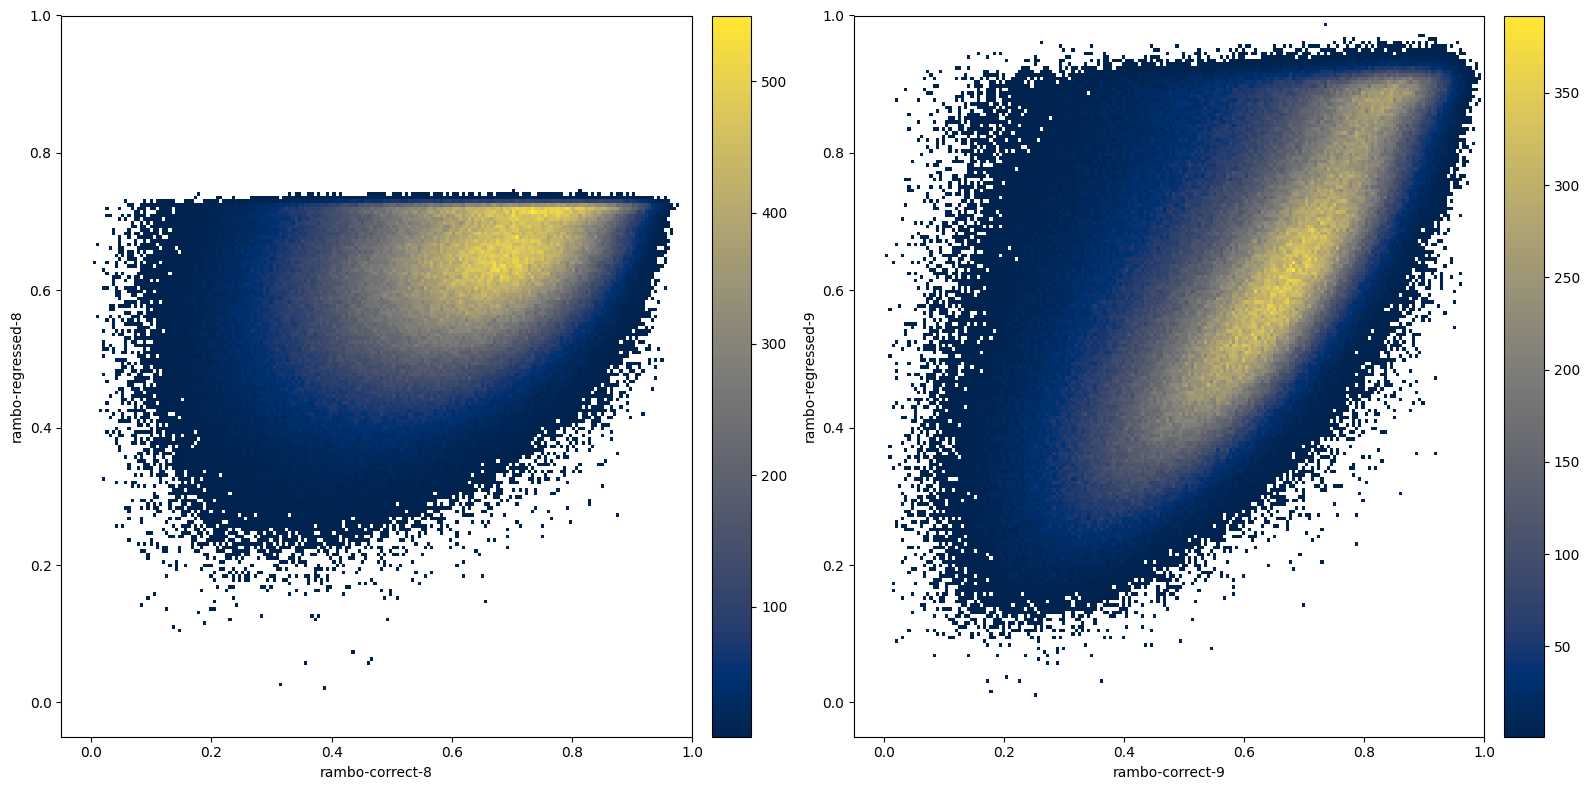

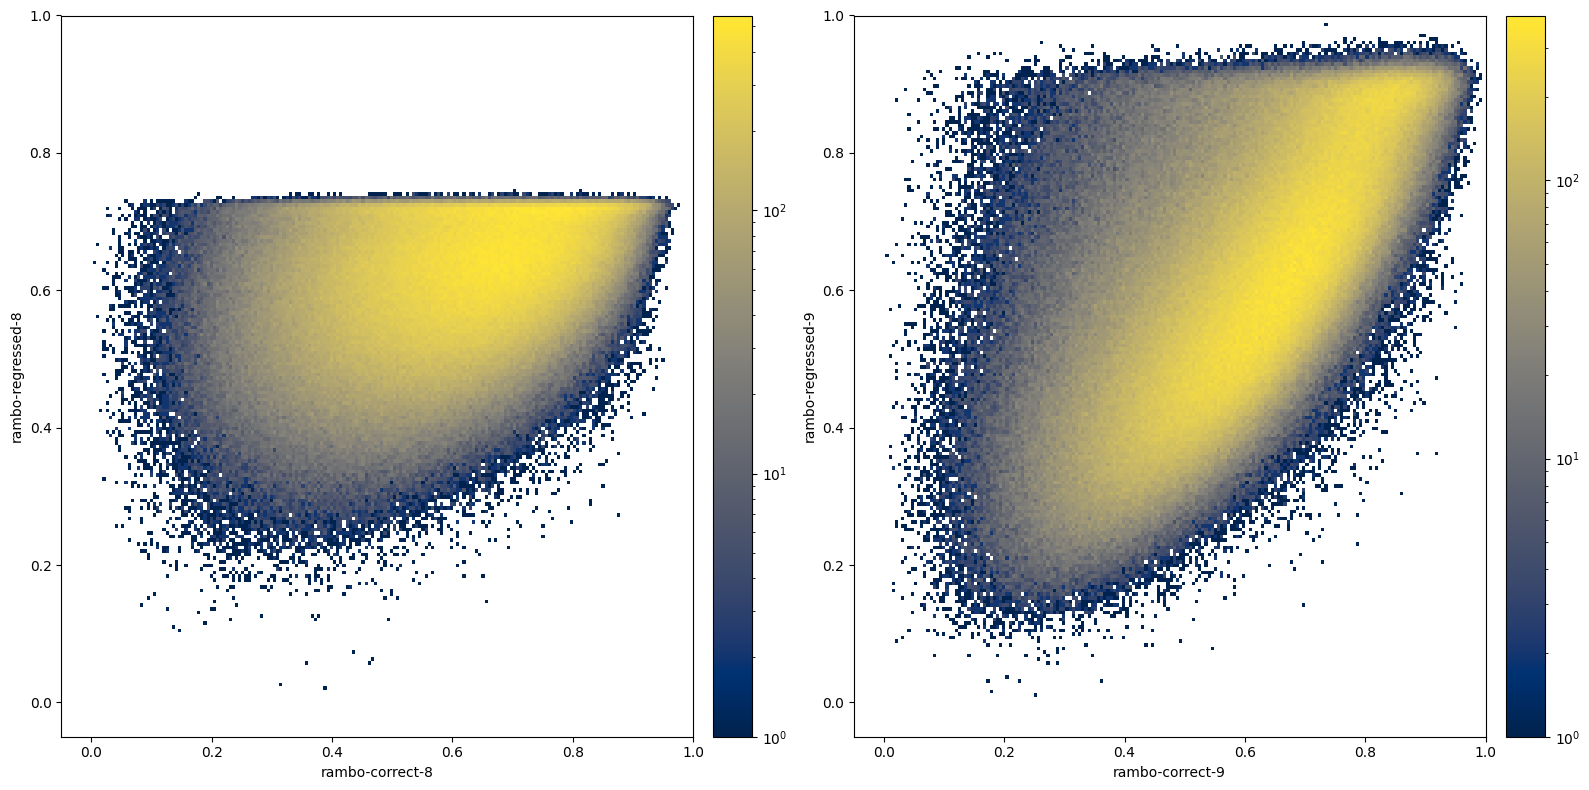

In [27]:
x1 = (boost_regressed[:, 0] + boost_regressed[:, 3]) / E_CM
x2 = (boost_regressed[:, 0] - boost_regressed[:, 3]) / E_CM
    
ps_regressed, detjinv_regressed = phasespace.get_ps_from_momenta(new_data_regressed, x1, x2, ensure_CM=True)
ps_regressed = torch.nan_to_num(ps_regressed, nan=-0.03)

numberFig = 67
# Here compute only x1/x2 (rest of plots look the same as above)
plots.plot_rambo(data_phasespace.detach().numpy(), ps_regressed.detach().numpy(),
                         nameFig=f'{numberFig}.png', typePlot=2, log=False)
        
plots.plot_rambo(data_phasespace.detach().numpy(), ps_regressed.detach().numpy(),
                         nameFig=f'{numberFig+1}.png', typePlot=2, log=True)